In [1]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import re
import scipy.sparse as sp
import matplotlib.ticker as mticker


from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.sparse import csr_matrix #to create sparse matrices, which can speed up training
from scipy import sparse
from sklearn.model_selection import KFold
from scipy import stats
from scipy.stats import pearsonr

from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, mean_squared_error
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn import model_selection, metrics, preprocessing


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Data Pre-Processing, Set up environment

In [ ]:
# path = "USE YOUR DATA PATH" 
movie_ratings = pd.read_csv(f"{path}/ratings.csv")
movie_ratings = movie_ratings.drop(columns=['timestamp'])

movie_movies = pd.read_csv(f"{path}/movies.csv")

# book_ratings = pd.read_csv(f"{path}/BX-Book-Ratings.csv")
# book_books = pd.read_csv(f"{path}/BX-Books.csv")
# book_users = pd.read_csv(f"{path}/BX-Users.csv")

# to speed up the prgoress, we try to reduce the data size
# create different sample sizes
movie_ratings = pd.merge(movie_ratings, movie_movies[['movieId', 'genres', 'title']], on='movieId')


In [3]:
movie_ratings

,userId,movieId,rating,genres,title
0,1,2,3.5,Adventure|Children|Fantasy,Jumanji (1995)
1,1,29,3.5,Adventure|Drama|Fantasy|Mystery|Sci-Fi,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,Mystery|Sci-Fi|Thriller,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
3,1,47,3.5,Mystery|Thriller,Seven (a.k.a. Se7en) (1995)
4,1,50,3.5,Crime|Mystery|Thriller,"Usual Suspects, The (1995)"
...,...,...,...,...,...
20000258,138493,68954,4.5,Adventure|Animation|Children|Drama,Up (2009)
20000259,138493,69526,4.5,Action|Adventure|Sci-Fi|IMAX,Transformers: Revenge of the Fallen (2009)
20000260,138493,69644,3.0,Action|Adventure|Animation|Children|Comedy|Rom...,Ice Age: Dawn of the Dinosaurs (2009)
20000261,138493,70286,5.0,Mystery|Sci-Fi|Thriller,District 9 (2009)


In [4]:
# We extract the year from the title

def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    if match:
        return match.group(1)
    return None
movie_ratings['year'] = movie_ratings['title'].apply(extract_year)


# remove the data which has missing year
movie_ratings = movie_ratings.dropna(subset=['year'])

In [5]:
movie_ratings

,userId,movieId,rating,genres,title,year
0,1,2,3.5,Adventure|Children|Fantasy,Jumanji (1995),1995
1,1,29,3.5,Adventure|Drama|Fantasy|Mystery|Sci-Fi,"City of Lost Children, The (Cité des enfants p...",1995
2,1,32,3.5,Mystery|Sci-Fi|Thriller,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),1995
3,1,47,3.5,Mystery|Thriller,Seven (a.k.a. Se7en) (1995),1995
4,1,50,3.5,Crime|Mystery|Thriller,"Usual Suspects, The (1995)",1995
...,...,...,...,...,...,...
20000258,138493,68954,4.5,Adventure|Animation|Children|Drama,Up (2009),2009
20000259,138493,69526,4.5,Action|Adventure|Sci-Fi|IMAX,Transformers: Revenge of the Fallen (2009),2009
20000260,138493,69644,3.0,Action|Adventure|Animation|Children|Comedy|Rom...,Ice Age: Dawn of the Dinosaurs (2009),2009
20000261,138493,70286,5.0,Mystery|Sci-Fi|Thriller,District 9 (2009),2009


In [6]:
unique_genres1 = set()
# Splitting the genre with seperatror: |
for genres in movie_ratings['genres']:
    genres_list = genres.split('|')
    unique_genres1.update(genres_list)


# Sorting the genres
unique_genres_list = sorted(list(unique_genres1))


In [7]:
# this section is used to create the utility matrix (using csr_matrix: sparse matrix to speed up calculation)
movie_rating_utility_matrix = movie_ratings[['userId', 'movieId', 'rating']].copy()

movie_rating_utility_matrix['userId'] = movie_rating_utility_matrix['userId'].astype(int)
movie_rating_utility_matrix['movieId'] = movie_rating_utility_matrix['movieId'].astype(int)

user_ids = movie_rating_utility_matrix['userId'].unique()
movie_ids = movie_rating_utility_matrix['movieId'].unique()

user_id_map = {id: i for i, id in enumerate(user_ids)}
movie_id_map = {id: i for i, id in enumerate(movie_ids)}

rows = [user_id_map[id] for id in movie_ratings['userId']]
cols = [movie_id_map[id] for id in movie_ratings['movieId']]
data = movie_ratings['rating'].values

# The Utility Matrix represents the user-item matrix in our raw data
sparse_utility_matrix = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))

In [8]:
# Function that remove inactive users, setup the threshold to be 1
# which means we'll keep the users who have at least one rating in the dataset
def remove_inactive_users(sparse_matrix, threshold=1):
    """
    Remove inactive users (user below a certain threshold)
    :param sparse_matrix: sparse matrix (csr_matrix)
    :return: sparse matrix with active usersonly
    """
    # count the number of non-zero elements in each row
    row_nnz = np.diff(sparse_matrix.indptr)
    
    # only keep users with at least one rating
    active_users = row_nnz >= threshold
    
    # create a new sparse matrix with only active users
    active_matrix = sparse_matrix[active_users]
    
    return active_matrix

# This is the function to sample users from the utility matrix
# The function will return a new sparse matrix with only a fraction of users
def sparse_matrix_sample_users(sparse_matrix, fraction, random_state=42):
    """
    Sample a fraction of users from the utility matrix

    :param sparse_matrix: The uitility matrix
    :param fraction: fraction of users to sample
    :param random_state: random seed
    :return: sampled sparse matrix, user_id_map(for future rempaing)
    """
    if not 0 < fraction <= 1:
        raise ValueError("Fraction must be between 0 and 1")
    
    n_users = sparse_matrix.shape[0]
    n_sampled_users = int(n_users * fraction)
    rng = np.random.RandomState(random_state)
    
    # create a mapping from original user ID to index
    original_user_ids = list(user_id_map.keys())
    
    # sample users
    sampled_user_ids = rng.choice(original_user_ids, n_sampled_users, replace=False)
    
    # create a mapping from sampled user ID to index
    new_user_id_map = {user_id: i for i, user_id in enumerate(sampled_user_ids)}
    
    # create new sparse matrix
    rows = []
    cols = []
    data = []
    for user_id in sampled_user_ids:
        old_index = user_id_map[user_id]
        user_ratings = sparse_matrix[old_index, :].tocoo()
        rows.extend([new_user_id_map[user_id]] * len(user_ratings.col))
        cols.extend(user_ratings.col)
        data.extend(user_ratings.data)
    
    sampled_sparse = csr_matrix((data, (rows, cols)), shape=(n_sampled_users, sparse_matrix.shape[1]))
    
    return sampled_sparse, new_user_id_map

# define different sampling fractions
fraction1 = 0.01

# remove inactive users
model_validation1, user_id_map1 = sparse_matrix_sample_users(sparse_utility_matrix, fraction1, random_state=42)

index_to_user_id1 = {i: id for id, i in user_id_map1.items()}
index_to_movie_id = {i: id for id, i in movie_id_map.items()}

# This will be the ground truth data we will be using in the future evaluation
model_validation1 = remove_inactive_users(model_validation1, 5)  


In [9]:
print(f"\nSample fraction: {fraction1}")
print(f"Original matrix shape: {sparse_utility_matrix.shape}")
print(f"Sampled matrix shape: {model_validation1.shape}")
print(f"Original non-zero elements: {sparse_utility_matrix.nnz}")
print(f"Sampled non-zero elements: {model_validation1.nnz}")
# density
density = model_validation1.nnz / (model_validation1.shape[0] * model_validation1.shape[1])
print(f"Matrix density: {density:.6f}")

print("--------------------------------------------------------------")



Sample fraction: 0.01
Original matrix shape: (138493, 26722)
Sampled matrix shape: (1384, 26722)
Original non-zero elements: 19999858
Sampled non-zero elements: 199829
Matrix density: 0.005403
--------------------------------------------------------------


In [10]:
def get_alluser_with_original_ID(target_sparse_matrix, index_to_user_id):
    """
    Get the original user IDs that exist in the new sparse matrix
    :param model_validation: The sparse matrix (model_validation1)
    :param index_to_user_id: Mapping from matrix indices to user IDs
    :return: list of original user IDs that exist in the new sparse matrix
    """
    # Get the indices of rows (users) that have at least one non-zero element
    active_user_indices = np.unique(target_sparse_matrix.nonzero()[0])
    
    # Map these indices back to original user IDs
    original_ids_in_new_matrix = [index_to_user_id[i] for i in active_user_indices]
    
    return original_ids_in_new_matrix

# Using the function:
original_ids_in_new_matrix = get_alluser_with_original_ID(model_validation1, index_to_user_id1)
print(f"Number of users in our sample: {len(original_ids_in_new_matrix)}")
print(f"First 5 user IDs: {original_ids_in_new_matrix[:5]}")

Number of users in our sample: 1384
First 5 user IDs: [9761, 28327, 59407, 76329, 10882]


In [11]:
# We'll use this function to remove certain percentage of ratings for a specific user,
# and then use it as a testing data to run the recommendation model
def remove_user_ratings(sparse_matrix, user_id, user_id_map, percentage, random_state=42):
    """
    Remove a percentage of ratings for a specific user and return a new sparse matrix.
    
    :param sparse_matrix: The Utility Matrix
    :param user_id: The user ID of the particular user whose ratings we want to partially remove
    :param user_id_map: Mapping from user ID to matrix index
    :param percentage: Percentage of ratings to remove for particular user (0-100)
    :param random_state: Random state for reproducibility
    :return: A new sparse matrix with some ratings removed for the specified user
    """
    # Make sure the ID exists in the matrix
    if user_id not in user_id_map:
        raise ValueError(f"User ID {user_id} not found in the matrix")
    
    # Get the index of the user from the mapping
    user_index = user_id_map[user_id]
    user_ratings = sparse_matrix[user_index].tocsr()
    
    # Get non-zero ratings
    # this part, we want to make sure we reomve non-zero ratings,
    # since the oringal matrix is a very sparse matrix
    _, cols = user_ratings.nonzero()
    
    # Calculate number of ratings to remove
    n_remove = int(len(cols) * (percentage / 100))
    
    # Randomly select ratings to remove
    np.random.seed(random_state)
    remove_indices = np.random.choice(cols, n_remove, replace=False)
    
    # Create a copy of the original matrix
    new_matrix = sparse_matrix.copy()
    
    # Remove the selected ratings
    new_matrix[user_index, remove_indices] = 0
    
    # Eliminate zero entries!!!!!!!!!!!!!! This is important, since the value should be removed not just set to 0
    new_matrix.eliminate_zeros()
    
    return new_matrix

# Use the function to create model1_partial1
user_id = 128258 # 9178, 41892 # 136296
user_id_to_remove = user_id
removal_percentage = 30

model1_partial1 = remove_user_ratings(model_validation1, user_id_to_remove, user_id_map1, removal_percentage)


In [12]:
def remove_all_user_ratings(sparse_matrix, user_id, user_id_map):
    """
    Remove all ratings for a specific user and return a new sparse matrix.
    This is used for mimicing the cold-start user probelem.
    
    :param sparse_matrix: The Utility Matrix
    :param user_id: The user ID of the particular user whose ratings we want to partially remove
    :param user_id_map: Mapping from user ID to matrix index
    :return: A new sparse matrix with some ratings removed for the specified user
    """

    # make sure the user ID exists in the matrix
    if user_id not in user_id_map:
        raise ValueError(f"User ID {user_id} not found in the matrix")
    
    # Get the index of the user from the mapping
    user_index = user_id_map[user_id]
    
    # Create a copy of the original matrix
    new_matrix = sparse_matrix.copy()
    
    # Get the indices of the user's ratings
    _, user_rating_indices = new_matrix[user_index].nonzero()
    
    # Remove all ratings for the specified user
    new_matrix[user_index, user_rating_indices] = 0
    
    # Eliminate zero entries, again this is important to not leaving any zero values
    # zero values can be misleading in the future calculation
    new_matrix.eliminate_zeros()
    
    return new_matrix

# Use the function to create Model1_cold_start
# we use the same user_id as before to compare
user_id_to_remove = user_id

# Assuming we're using model1_validation1 as our base matrix
model1_cold_start1 = remove_all_user_ratings(model_validation1, user_id_to_remove, user_id_map1)


# Verify that the user has no ratings left
assert model1_cold_start1[user_id_map1[user_id_to_remove]].getnnz() == 0, "User should have no ratings left"
print("Verification passed: User has no ratings left in the new matrix.")

Verification passed: User has no ratings left in the new matrix.


In [13]:
print(f"Model1_partial1 shape: {model1_partial1.shape}")
print(f"Model1_partial1 nnz: {model1_partial1.nnz}")

print("--------------------------------------------------------------")

print(f"Model1_cold_start1 shape: {model1_cold_start1.shape}")
print(f"Model1_cold nnz: {model1_cold_start1.nnz}")

print("--------------------------------------------------------------")
print(f"Validation shape: {model_validation1.shape}")
print(f"Validation nnz: {model_validation1.nnz}")

Model1_partial1 shape: (1384, 26722)
Model1_partial1 nnz: 198976
--------------------------------------------------------------
Model1_cold_start1 shape: (1384, 26722)
Model1_cold nnz: 196985
--------------------------------------------------------------
Validation shape: (1384, 26722)
Validation nnz: 199829


In [14]:
user_ratings_partial = model1_partial1[137, :].toarray().flatten()
user_ratings_cold_start = model1_cold_start1[137, :].toarray().flatten()
user_ratings_validation = model_validation1[137, :].toarray().flatten()
mask = user_ratings_validation != 0
mask2 = user_ratings_partial != 0
mask3 = user_ratings_cold_start != 0

user_gt_ratings = user_ratings_validation[mask]
user_ratings_partial = user_ratings_partial[mask2]
user_ratings_cold_start = user_ratings_cold_start[mask3]


(array([1.000e+00, 1.100e+01, 1.300e+01, 9.600e+01, 1.480e+02, 1.002e+03,
        5.400e+02, 8.170e+02, 1.590e+02, 5.700e+01]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

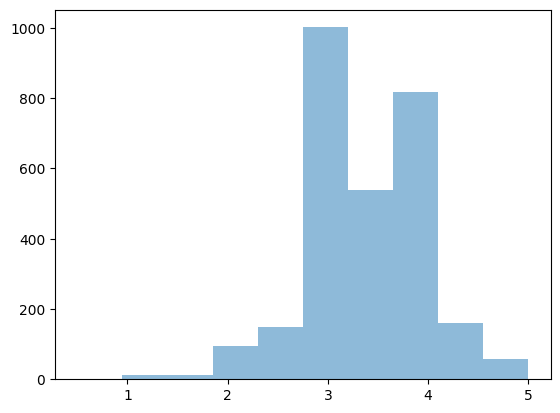

In [15]:
plt.hist(user_gt_ratings, bins=10, alpha=0.5, label='ground truth')

(array([ 10.,  10.,  65., 111.,   0., 690., 369., 598., 101.,  37.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

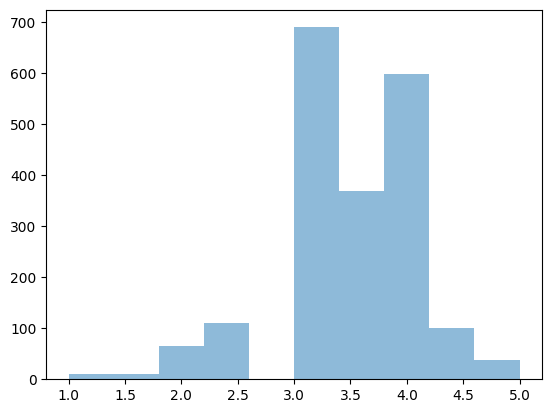

In [16]:
plt.hist(user_ratings_partial, bins=10, alpha=0.5, label='Partial')


Value 1 Counts: 11
Value 2 Counts: 96
Value 3 Counts: 1002
Value 4 Counts: 817
Value 5 Counts: 57


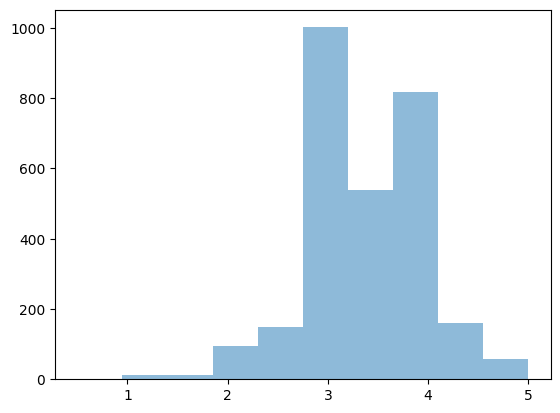

In [17]:
test_user_id = user_id_map1[user_id_to_remove]
original_ratings = model_validation1[test_user_id].toarray().flatten()

values, counts = np.unique(original_ratings, return_counts=True)
count_dict = dict(zip(values, counts))

mask = original_ratings != 0
final_count = original_ratings[mask]

for i in range(1, 6):
    print(f"Value {i} Counts: {count_dict.get(i, 0)}")

plt.hist(final_count, bins=10, alpha=0.5, label='Original')
plt.show()

In [18]:
def print_evaluation(version):
    cold_start_metrics = {
        "Accuracy": f"accuracy_cold{version}",
        "Recall": f"recall_cold{version}",
        "Precision": f"precision_cold{version}",
        "F1 Score": f"f1_cold{version}",
        "RMSE": f"rmse_cold{version}"
    }
    
    partial_ratings_metrics = {
        "Accuracy": f"accuracy_partial{version}",
        "Recall": f"recall_partial{version}",
        "Precision": f"precision_partial{version}",
        "F1 Score": f"f1_partial{version}",
        "RMSE": f"rmse_partial{version}"
    }
    
    print(f"\nEvaluation for cold start user (version {version}):")
    for metric, var_name in cold_start_metrics.items():
        value = globals().get(var_name, "N/A")
        print(f"{metric}: {value:.4f}" if isinstance(value, (int, float)) else f"{metric}: {value}")
    
    print(f"\nEvaluation for partial ratings user (version {version}):")
    for metric, var_name in partial_ratings_metrics.items():
        value = globals().get(var_name, "N/A")
        print(f"{metric}: {value:.4f}" if isinstance(value, (int, float)) else f"{metric}: {value}")

def scale_score(original_prediction, new_min=1, new_max=5):
    old_min = min(original_prediction)
    old_max = max(original_prediction)
    
    if old_min != old_max:
        return [
            ((x - old_min) / (old_max - old_min)) * (new_max - new_min) + 1
            for x in original_prediction
                ]
    else:
        return [
            ((x - old_min ) / (old_max - old_min)) * (new_max - new_min) + 1
            for x in original_prediction
                ]



# Content Based Filtering

In [19]:
# Function that transfer the genre into feature vectors,
# we use TfidfVectorizer to do the job
# This is used for the content-based recommendation
def prepare_movie_features(movies_df):
    tfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
    tfidf_matrix = tfidf.fit_transform(movies_df['genres'])
    return tfidf_matrix

# -------------------------------------------------------------------------------------------------------------------
# This section is how we can the prediction value via the content-based recommendation
# both for the partial and cold start model (sharing similar structure)

def predict_ratings_partial(user_ratings, movie_features):
    user_ratings = user_ratings.toarray().flatten() if scipy.sparse.issparse(user_ratings) else user_ratings.flatten()
    
    user_feature_preference = np.zeros(movie_features.shape[1])
    rated_movies = np.nonzero(user_ratings)[0]

    # We loop through the rated movies and calculate the user's feature preference
    for movie in rated_movies:
        user_feature_preference += movie_features[movie].toarray()[0] * user_ratings[movie]
    user_feature_preference /= len(rated_movies)
    
    # by dot product, we can get the predicted ratings
    predicted_ratings = movie_features.dot(user_feature_preference)
    
    # min_rating, max_rating = 1, 5
    # Normalize the ratings to be within the min and max rating
    # predicted_ratings = min_rating + (max_rating - min_rating) * (predicted_ratings - predicted_ratings.min()) / (predicted_ratings.max() - predicted_ratings.min())
    
    return predicted_ratings


# This is the function to calculate the user profile, the profile of the users interest in our disseration
def calculate_user_profile(user_ratings, movie_features):
    if sparse.issparse(user_ratings):
        user_ratings = user_ratings.toarray().flatten()
    else:
        user_ratings = user_ratings.flatten()
    
    # Consider non-zero ratings only
    rated_movies = np.nonzero(user_ratings)[0]
    
    if len(rated_movies) == 0:
        return np.zeros(movie_features.shape[1])
    
    rated_features = movie_features[rated_movies]
    rated_ratings = user_ratings[rated_movies]
    
    # Compute the weighted sum of movie features
    weighted_features = rated_features.multiply(rated_ratings[:, np.newaxis])
    weighted_sum = weighted_features.sum(axis=0)
    
    # Compute the sum of numbers of ratings
    ratings_sum = rated_ratings.sum()
    
    # Compute the user profile in weighted average
    user_profile = weighted_sum / ratings_sum
    
    return user_profile.A.flatten()


# getring the movie rating aftger the user profile is calculated can be easy.
# Just calculate the dot product of the user profile and the movie features
def predict_ratings(user_profile, movie_features):
    # Compute the predicted ratings
    raw_predictions = movie_features.dot(user_profile)
    
    # Normalize the ratings to be within the min and max rating
    min_rating, max_rating = 1, 5
    scaled_predictions = min_rating + (max_rating - min_rating) * (raw_predictions - raw_predictions.min()) / (raw_predictions.max() - raw_predictions.min())
    
    return scaled_predictions



def evaluate_recommendations(true_ratings, predicted_ratings, threshold=4):
    if sparse.issparse(true_ratings):
        true_ratings = true_ratings.toarray().flatten()
    else:
        true_ratings = np.asarray(true_ratings).flatten()
    
    if sparse.issparse(predicted_ratings):
        predicted_ratings = predicted_ratings.toarray().flatten()
    else:
        predicted_ratings = np.asarray(predicted_ratings).flatten()
    
    assert len(true_ratings) == len(predicted_ratings), "Ratings arrays must have the same length"
    
    # Calculate non-zero mask for true ratings
    valid_mask = (true_ratings != 0) & (~np.isnan(true_ratings))
    
    true_ratings = true_ratings[valid_mask]
    predicted_ratings = predicted_ratings[valid_mask]
    
    # Remove NaN values from predicted ratings
    non_nan_mask = ~np.isnan(predicted_ratings)
    true_ratings = true_ratings[non_nan_mask]
    predicted_ratings = predicted_ratings[non_nan_mask]
    
    true_liked = true_ratings >= threshold
    pred_liked = predicted_ratings >= threshold
    
    precision, recall, f1, _ = precision_recall_fscore_support(true_liked, pred_liked, average='binary', zero_division=0)
    accuracy = accuracy_score(true_liked, pred_liked)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    
    return recall, precision, accuracy, rmse, f1


def ensure_array(X):
    if isinstance(X, np.matrix):
        return np.asarray(X)
    return X



In [20]:
# prepare movie features, using the original index
original_movie_ids = [index_to_movie_id[i] for i in range(len(movie_ids))]

movies_df = pd.DataFrame({
'movieId': range(len(movie_ids)), 
'genres': [movie_movies.loc[movie_movies['movieId'] == original_id, 'genres'].values[0] for original_id in original_movie_ids]
})

movie_features = prepare_movie_features(movies_df)

In [21]:
# Use threshold 3.5, when ever we have ratings > 3.5 we consider it as a liked movies
# Calculate cold start model once
all_user_profiles = [calculate_user_profile(user_ratings, movie_features) for user_ratings in model1_partial1]
average_profile = np.mean(all_user_profiles, axis=0)
predicted_ratings_cold = predict_ratings(average_profile, movie_features)

# Initialize variables outside the loop
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}

# Use threshold 3.5, when ratings > 3.5 we consider it as liked movies
for userID in range(n_users):
    # 30% of ratings removed model
    user_ratings_partial = model1_partial1[userID]
    user_profile_partial = calculate_user_profile(user_ratings_partial, movie_features)
    predicted_ratings_partial = predict_ratings(user_profile_partial, movie_features)

    # Evaluate partial model
    results_partial = evaluate_recommendations(model_validation1[userID], predicted_ratings_partial, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations(model_validation1[userID], predicted_ratings_cold, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / n_users for k, v in metrics_partial.items()}
metrics_cold = {k: v / n_users for k, v in metrics_cold.items()}

# Unpack results
recall_partial1_1, precision_partial1_1, accuracy_partial1_1, rmse_partial1_1, f1_partial1_1 = metrics_partial.values()
recall_cold1_1, precision_cold1_1, accuracy_cold1_1, rmse_cold1_1, f1_cold1_1 = metrics_cold.values()

print_evaluation("1_1")


# recall_partial1_1, precision_partial1_1, accuracy_partial1_1, rmse_partial1_1, f1_partial1_1 = evaluate_recommendations(
#     model_validation1[user_index], predicted_ratings_partial, threshold=3.5
# )

# recall_cold1_1, precision_cold1_1, accuracy_cold1_1, rmse_cold1_1, f1_cold1_1 = evaluate_recommendations(
#     model_validation1[user_index], predicted_ratings_cold, threshold=3.5
# )



Evaluation for cold start user (version 1_1):
Accuracy: 0.4425
Recall: 0.2884
Precision: 0.6187
F1 Score: 0.3749
RMSE: 1.2619

Evaluation for partial ratings user (version 1_1):
Accuracy: 0.5297
Recall: 0.5081
Precision: 0.6518
F1 Score: 0.5522
RMSE: 1.2677


# Collaborative Filtering

In [22]:
def predict_ratings_partial(user_ratings, user_ratings_matrix, user_similarity, k=5):
    """
    Predict ratings for a user based on the ratings of similar users.

    :Param user_ratings: A 1D array of the user's ratings
    :Param user_ratings_matrix: The Utility = (user, movie) and values = ratings
    :Param k: The number of similar users to consider

    :Returns: A 1D array of predicted ratings for the user
    """
    # ensure user_ratings is a 1D array
    if scipy.sparse.issparse(user_ratings):
        user_ratings = user_ratings.toarray().flatten()
    elif isinstance(user_ratings, np.ndarray) and user_ratings.ndim > 1:
        user_ratings = user_ratings.flatten()
    
    # get the index of the user in the matrix, by finding the index where the user_ratings match
    user_index = np.where(np.all(user_ratings_matrix.toarray() == user_ratings, axis=1))[0]
    # If can't find such user, raise an error
    if len(user_index) == 0:
        raise ValueError("User ratings not found in the matrix")
    user_index = user_index[0]

    # obtain the k most similar users (excluding the user itself)
    similar_users = user_similarity[user_index].argsort()[::-1][1:k+1]
    
    # predict ratings for all movies
    # initialize the predicted ratings to zeros
    predicted_ratings = np.zeros(user_ratings_matrix.shape[1])
    for movie in range(user_ratings_matrix.shape[1]):
        similar_users_ratings = user_ratings_matrix[similar_users, movie].toarray().flatten()
        
        # only consider ratings from similar users that gives ratings
        reference_ratings = similar_users_ratings[similar_users_ratings > 0]
        if len(reference_ratings) > 0:
            # Get avg ratings from similar users
            predicted_ratings[movie] = np.mean(reference_ratings)
        else:
            # if no similar users have rated the movie, use the user's average rating
            all_ratings = user_ratings_matrix[:, movie].data
            if len(all_ratings) > 0:
                predicted_ratings[movie] = np.mean(all_ratings)
            else:
                predicted_ratings[movie] = 3.0  # no other reference ratings, use default rating
    
    return predicted_ratings



def predict_ratings_cold(user_ratings_matrix):
    # compute the average rating for each movie
    movie_means = np.zeros(user_ratings_matrix.shape[1])
    for movie in range(user_ratings_matrix.shape[1]):
        ratings = user_ratings_matrix[:, movie].data
        if len(ratings) > 0:
            movie_means[movie] = np.mean(ratings)
        else:
            movie_means[movie] = 2.5  # default rating if no ratings are available

    return movie_means

def compute_user_similarity(user_ratings_matrix):
    """
    Compare user pairwise similarity based on their ratings.
    
    Parameters:
    user_ratings_matrix: scipy.sparse.csr_matrix
        A rating matrix where indices = (user, movie) and values = ratings

    Returns:
    numpy.ndarray
        A 2D array where element (i, j) is the similarity between user i and user
    """
    if scipy.sparse.issparse(user_ratings_matrix):
        user_ratings_array = user_ratings_matrix.toarray()
    else:
        user_ratings_array = user_ratings_matrix
    
    similarity = cosine_similarity(user_ratings_array)
    
    return similarity

In [23]:
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}

user_similarity = compute_user_similarity(model1_partial1)
# Cold user does not depned on the user, so we can calculate it once
predicted_ratings_cold = predict_ratings_cold(model1_partial1)

for userID in range(n_users):
    # 30% Partial model
    user_ratings_partial = model1_partial1[userID].toarray().flatten()
    predicted_ratings_partial = predict_ratings_partial(user_ratings_partial, model1_partial1, user_similarity)

    # use for aligning the ratings
    true_ratings = model_validation1[userID].toarray().flatten()
    # aligned_true_partial, aligned_pred_partial = align_ratings(true_ratings, predicted_ratings_partial)

    # Evaluate partial model
    results_partial = evaluate_recommendations(true_ratings, predicted_ratings_partial, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # aligned_true_cold, aligned_pred_cold = align_ratings(true_ratings, predicted_ratings_cold)
    # Evaluate cold start model
    results_cold = evaluate_recommendations(true_ratings, predicted_ratings_cold, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Get final results with avg
metrics_partial = {k: v / n_users for k, v in metrics_partial.items()}
metrics_cold = {k: v / n_users for k, v in metrics_cold.items()}

recall_partial2_1, precision_partial2_1, accuracy_partial2_1, rmse_partial2_1, f1_partial2_1 = metrics_partial.values()
recall_cold2_1, precision_cold2_1, accuracy_cold2_1, rmse_cold2_1, f1_cold2_1 = metrics_cold.values()

print_evaluation("2_1")

# recall_partial2_1, precision_partial2_1, accuracy_partial2_1, rmse_partial2_1, f1_partial2_1 = evaluate_recommendations(
#     model_validation1[user_index], predicted_ratings_partial, threshold=3.5
# )

# recall_cold2_1, precision_cold2_1, accuracy_cold2_1, rmse_cold2_1, f1_cold2_1 = evaluate_recommendations(
#     model_validation1[user_index], predicted_ratings_cold, threshold=3.5
# )




Evaluation for cold start user (version 2_1):
Accuracy: 0.6815
Recall: 0.7071
Precision: 0.7443
F1 Score: 0.7039
RMSE: 0.9303

Evaluation for partial ratings user (version 2_1):
Accuracy: 0.6681
Recall: 0.7495
Precision: 0.7170
F1 Score: 0.7129
RMSE: 1.0332


# Using adjusted consine similarity (where we consider only the common rated movie)

In [24]:
def common_items_cosine_similarity(user_ratings_matrix, min_common_items=3):
    num_users = user_ratings_matrix.shape[0]
    similarity_matrix = np.zeros((num_users, num_users))
    
    for i in range(num_users):
        for j in range(i, num_users):
            # Convert sparse matrix rows to dense arrays
            ui = user_ratings_matrix[i].toarray().flatten()
            uj = user_ratings_matrix[j].toarray().flatten()
            
            # Find common items
            mask = np.logical_and(ui != 0, uj != 0)
            common_items = np.sum(mask)
            
            if common_items >= min_common_items:
                # Calculate cosine similarity
                ui_common = ui[mask]
                uj_common = uj[mask]
                
                numerator = np.dot(ui_common, uj_common)
                denominator = np.linalg.norm(ui_common) * np.linalg.norm(uj_common)
                
                if denominator != 0:
                    similarity = numerator / denominator
                else:
                    similarity = 0
                
                similarity_matrix[i, j] = similarity_matrix[j, i] = similarity
    
    return similarity_matrix

def predict_ratings_partial2(user_ratings, user_ratings_matrix, user_similarity, k=5):
    """
    Predict ratings for a user based on the ratings of similar users.

    :Param user_ratings: A 1D array of the user's ratings
    :Param user_ratings_matrix: The Utility = (user, movie) and values = ratings
    :Param k: The number of similar users to consider

    :Returns: A 1D array of predicted ratings for the user
    """
    # ensure user_ratings is a 1D array
    if scipy.sparse.issparse(user_ratings):
        user_ratings = user_ratings.toarray().flatten()
    elif isinstance(user_ratings, np.ndarray) and user_ratings.ndim > 1:
        user_ratings = user_ratings.flatten()
    
    # get the index of the user in the matrix, by finding the index where the user_ratings match
    user_index = np.where(np.all(user_ratings_matrix.toarray() == user_ratings, axis=1))[0]
    # If can't find such user, raise an error
    if len(user_index) == 0:
        raise ValueError("User ratings not found in the matrix")
    user_index = user_index[0]
        
    # obtain the k most similar users (excluding the user itself)
    similar_users = user_similarity[user_index].argsort()[::-1][1:k+1]
    
    # predict ratings for all movies
    # initialize the predicted ratings to zeros
    predicted_ratings = np.zeros(user_ratings_matrix.shape[1])
    
    for movie in range(user_ratings_matrix.shape[1]):
        similar_users_ratings = user_ratings_matrix[similar_users, movie].toarray().flatten()
        # only consider ratings from similar users that gives ratings
        reference_ratings = similar_users_ratings[similar_users_ratings > 0]
        if len(reference_ratings) > 0:
            # Get the average rating fromt the similar users
            predicted_ratings[movie] = np.mean(reference_ratings)
        else:
            # If no similar users have rated the movie, use the user's(ALL) average rating
            all_ratings = user_ratings_matrix[:, movie].data
            if len(all_ratings) > 0:
                predicted_ratings[movie] = np.mean(all_ratings)
            else:
                predicted_ratings[movie] = 3.0  # default rating if no ratings are available
        
    return predicted_ratings

def predict_ratings_cold2(user_ratings_matrix):
    # compute the average rating for each movie
    movie_means = np.zeros(user_ratings_matrix.shape[1])
    for movie in range(user_ratings_matrix.shape[1]):
        ratings = user_ratings_matrix[:, movie].data
        if len(ratings) > 0:
            movie_means[movie] = np.mean(ratings)
        else:
            movie_means[movie] = 3  # default rating if no ratings are available

    return movie_means

In [25]:
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}

user_similarity = common_items_cosine_similarity(model1_partial1)
# Cold user does not depned on the user, so we can calculate it once
predicted_ratings_cold = predict_ratings_cold2(model1_partial1)

for userID in range(n_users):
    # 30% Partial model
    user_ratings_partial = model1_partial1[userID].toarray().flatten()
    predicted_ratings_partial = predict_ratings_partial2(user_ratings_partial, model1_partial1, user_similarity)

    # use for aligning the ratings
    true_ratings = model_validation1[userID].toarray().flatten()
    # aligned_true_partial, aligned_pred_partial = align_ratings(true_ratings, predicted_ratings_partial)

    # Evaluate partial model
    results_partial = evaluate_recommendations(true_ratings, predicted_ratings_partial, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # aligned_true_cold, aligned_pred_cold = align_ratings(true_ratings, predicted_ratings_cold)
    # Evaluate cold start model
    results_cold = evaluate_recommendations(true_ratings, predicted_ratings_cold, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Get final results with avg
metrics_partial = {k: v / n_users for k, v in metrics_partial.items()}
metrics_cold = {k: v / n_users for k, v in metrics_cold.items()}

recall_partial2_1_2, precision_partial2_1_2, accuracy_partial2_1_2, rmse_partial2_1_2, f1_partial2_1_2 = metrics_partial.values()
recall_cold2_1_2, precision_cold2_1_2, accuracy_cold2_1_2, rmse_cold2_1_2, f1_cold2_1_2 = metrics_cold.values()

print_evaluation("2_1_2")



Evaluation for cold start user (version 2_1_2):
Accuracy: 0.6815
Recall: 0.7071
Precision: 0.7443
F1 Score: 0.7039
RMSE: 0.9303

Evaluation for partial ratings user (version 2_1_2):
Accuracy: 0.8329
Recall: 0.8584
Precision: 0.8556
F1 Score: 0.8460
RMSE: 0.5612


# Using Pearson Correlation

In [26]:
def pearson_similarity(user_ratings_matrix):
    ratings = user_ratings_matrix.toarray()
    
    num_users = ratings.shape[0]
    similarity_matrix = np.zeros((num_users, num_users))
    
    for i in range(num_users):
        for j in range(i, num_users):
            # find common ratings
            mask = np.logical_and(ratings[i] != 0, ratings[j] != 0)
            if np.sum(mask) > 1:  # at least 2 common ratings
                ratings_i = ratings[i, mask]
                ratings_j = ratings[j, mask]
                
                # check for special cases where the standard deviation is 0
                # then the calculation might go wrong
                if np.std(ratings_i) == 0 or np.std(ratings_j) == 0:
                    if np.array_equal(ratings_i, ratings_j):
                        similarity_matrix[i, j] = 1.0
                    else:
                        similarity_matrix[i, j] = 0.0
                else:
                    corr, _ = pearsonr(ratings_i, ratings_j)
                    similarity_matrix[i, j] = corr
                
                similarity_matrix[j, i] = similarity_matrix[i, j]  # similarity matrix is symmetric
            else:
                similarity_matrix[i, j] = 0
                similarity_matrix[j, i] = 0
    
    # if we have NaN values(for example, there is no enough ratings to calculate similarities among users), replace them with 0

    similarity_matrix = np.nan_to_num(similarity_matrix)
    
    return similarity_matrix
 
def predict_ratings_partial3(user_ratings, user_ratings_matrix, user_similarity, k=5):
    if scipy.sparse.issparse(user_ratings):
        user_ratings = user_ratings.toarray().flatten()
    elif isinstance(user_ratings, np.ndarray) and user_ratings.ndim > 1:
        user_ratings = user_ratings.flatten()
    
    user_index = np.where(np.all(user_ratings_matrix.toarray() == user_ratings, axis=1))[0]
    
    if len(user_index) == 0:
        raise ValueError("User ratings not found in the matrix")
    user_index = user_index[0]
    
    similar_users = user_similarity[user_index].argsort()[::-1][1:k+1]
    
    predicted_ratings = np.zeros(user_ratings_matrix.shape[1])
    user_mean = np.mean(user_ratings[user_ratings != 0])
    
    for movie in range(user_ratings_matrix.shape[1]):
        similar_users_ratings = user_ratings_matrix[similar_users, movie].toarray().flatten()
        similar_users_means = np.mean(user_ratings_matrix[similar_users].toarray(), axis=1)
        
        mask = similar_users_ratings > 0
        if np.sum(mask) > 0:
            weights = user_similarity[user_index, similar_users[mask]]
            rating_deviations = similar_users_ratings[mask] - similar_users_means[mask]
            predicted_ratings[movie] = user_mean + np.average(rating_deviations, weights=weights)
        else:
            all_ratings = user_ratings_matrix[:, movie].data
            if len(all_ratings) > 0:
                predicted_ratings[movie] = np.mean(all_ratings)
            else:
                predicted_ratings[movie] = 3.5
    
    return predicted_ratings

In [27]:
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}

user_similarity = pearson_similarity(model1_partial1)
# Cold user does not depned on the user, so we can calculate it once
predicted_ratings_cold = predict_ratings_cold2(model1_partial1)

for userID in range(n_users):
    # 30% Partial model
    user_ratings_partial = model1_partial1[userID].toarray().flatten()
    predicted_ratings_partial = predict_ratings_partial3(user_ratings_partial, model1_partial1, user_similarity)

    # use for aligning the ratings
    true_ratings = model_validation1[userID].toarray().flatten()
    # aligned_true_partial, aligned_pred_partial = align_ratings(true_ratings, predicted_ratings_partial)

    # Evaluate partial model
    results_partial = evaluate_recommendations(true_ratings, predicted_ratings_partial, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # aligned_true_cold, aligned_pred_cold = align_ratings(true_ratings, predicted_ratings_cold)
    # Evaluate cold start model
    results_cold = evaluate_recommendations(true_ratings, predicted_ratings_cold, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Get final results with avg
metrics_partial = {k: v / n_users for k, v in metrics_partial.items()}
metrics_cold = {k: v / n_users for k, v in metrics_cold.items()}

recall_partial2_1_3, precision_partial2_1_3, accuracy_partial2_1_3, rmse_partial2_1_3, f1_partial2_1_3 = metrics_partial.values()
recall_cold2_1_3, precision_cold2_1_3, accuracy_cold2_1_3, rmse_cold2_1_3, f1_cold2_1_3 = metrics_cold.values()

print_evaluation("2_1_2")



Evaluation for cold start user (version 2_1_2):
Accuracy: 0.6815
Recall: 0.7071
Precision: 0.7443
F1 Score: 0.7039
RMSE: 0.9303

Evaluation for partial ratings user (version 2_1_2):
Accuracy: 0.8329
Recall: 0.8584
Precision: 0.8556
F1 Score: 0.8460
RMSE: 0.5612


# Matrix Completetion SVT
## The Code is referenced from the FINAL PROJECT from the QMUL 2nd semester module: Advanced Machine Learning.

In [28]:
# This part reference from the FINAL PROJECT from the QMUL 2nd semester module: Advanced Machine Learning
def project_function(M, omega):
    """
    Project function that will transform input M into M_projected
    Mij component will be Mij if Mij is in omega, otherwise Mij = 0 

    parameters:
    M : numpy array (the matrix be transfomred)
    omega: 2 arrays contains pairwise index for existing value in M
    """
    projection_M = np.zeros(M.shape)
    # This Line really helps reducing the running time
    projection_M[omega] = M[omega]
    # for (i, j) in omega:
    #     projection_M[i, j] = M[i, j]
    return projection_M


# -------------------------------------------------------------

def contruct_omega_set(M, missing_val = 0):
    """
    Function that will construct the omega array from the input matrix M
    
    parameters:
    M : numpy array (the matrix be transfomred)
    missing_val: int (the value that will be used to identify the missing values in M)
    """
    # omega = np.argwhere(M != missing_val)
    if sparse.issparse(M):
        # for sparse matrix
        rows, cols = M.nonzero()
        values = M.data
        return rows[values != missing_val], cols[values != missing_val]
    else:
        # for dense matrix
        return np.where(M != missing_val)


def matrix_complete(M, tolerance=8.1e-5, beta_val=None, tau_val=None, max_iter=100, iter_print=100):
    """
    Matrix Completetion using SVT algorithm

    Parameters:
    M (numpy.ndarray): Shape: D x N. The incomplete matrix with missing entries as -1.
    tolerance (float): The maximum tolerance to decide when iterations should stop. Default is 8.1e-5.
    beta_val (float): A value for the increment size beta. If not specified, the default is 0.82 * D * N / K.
                      K is the number of known entries in M.
    tau_val (float): A value for the shrinking size tau. If not specified, the default is 0.37 * max(D, N).
    max_iter (int): Maximum number of iterations to run. Default is 10000.
    iter_print (int): How often to print out a progress line. Default is 100.
    """

    # initialize parameters
    # M is the incomplete matrix with shape D x N
    D, N = M.shape
    # omega is set includes know entries in M (unknown entries are -1 in this case)
    omega = contruct_omega_set(M)
    # k is the number of known entries in M
    k = len(omega)

    # set default value for beta and tau if not specified
    beta_val = (0.82 * D * N) / k if beta_val is None else beta_val
    tau_val = 0.37 * max(D, N) if tau_val is None else tau_val

    # set lambda in this case Y a zero matrix
    Y = np.zeros((D, N))

    # scaler = StandardScaler()
    # M = scaler.fit_transform(M)
    M, scaler = scale_matrix(M)
    
    # per-caluclate the projection of M on omega outside the loop
    projection_M_omega = project_function(M, omega)
    # srart the iterations
    for iter in tqdm(range(max_iter), desc= "Matrix Completion Progress"):
        # using SVD on Y
        # U, S, VT = np.linalg.svd(Y, full_matrices=False)
        # U, S, VT = randomized_svd(Y, n_components=min(30, min(Y.shape)-1))
        U, S, VT = randomized_svd(Y, n_components=min(Y.shape)-1)
        # shrinkage singular value
        # keep only the singular values that are greater than tau_val
        # else = 0
        S_shrink = np.maximum(S - tau_val, 0)
        X = U @ np.diag(S_shrink) @ VT

        # strictly force X in the range of 0 and 1
        # X = np.clip(X, 0, 1)
        # update Y
        # Y += beta_val * project_function(M_scaled - X, omega)
        Y += beta_val * project_function(M - X, omega)

        
        real_tol = np.linalg.norm(projection_M_omega - project_function(X, omega), 'fro') / np.linalg.norm(projection_M_omega, 'fro')
        if (iter + 1) % iter_print == 0:
            print(f"Current Iteration = {iter + 1}, Progress = {((iter + 1)/max_iter) * 100:.2f}%")
        
        if real_tol <= tolerance:
            print(f"Reached Tolerance. Output result at Iteration = {iter + 1}")
            break
    
    print("Matrix approximation complete")
    # X = X * (M_max - M_min) + M_min
    
    # X = scaler.inverse_transform(X)
    X = inverse_scale_matrix(X, scaler)
    # X = np.clip(X, 1, 5)
    
    return X


def predict_ratings_matrix_completion(user_index, predicted_ratings):
    return predicted_ratings[user_index].flatten()

def calculate_user_mean_ratings(ratings_matrix):
    '''
    This is a function that we want to replace the missing values with mean values of the user
    However, we want to compute the non-zero value mean only
    '''
    mask = ratings_matrix == 0
    masked_ratings = np.ma.masked_array(ratings_matrix, mask=mask)
    
    user_mean_ratings = np.ma.mean(masked_ratings, axis=1)
    user_mean_ratings = user_mean_ratings.filled(np.nan)
    
    # For all zero rows, replace with global mean (we assume that the user has not rated any movie)
    # This can be useful for 
    global_mean = np.nanmean(user_mean_ratings)
    user_mean_ratings[np.isnan(user_mean_ratings)] = global_mean
    
    return user_mean_ratings

def scale_matrix(M):
    # For sparse matrix, we use MaxAbsScaler
    if sparse.issparse(M):
        scaler = MaxAbsScaler()
        scaled_M = scaler.fit_transform(M)
    # For dense matrix, we use StandardScaler
    else:
        scaler = StandardScaler()
        scaled_M = scaler.fit_transform(M)
    return scaled_M, scaler

def inverse_scale_matrix(M, scaler):
    return scaler.inverse_transform(M)

# Pre-Filled Matrix

In [29]:
user_ratings_matrix1 = model1_partial1.toarray()
user_ratings_matrix2 = model1_cold_start1.toarray()
global_rating_matrix = model_validation1.toarray()

user_mean_ratings = calculate_user_mean_ratings(user_ratings_matrix1)

# for partially filled user, fill missing values with user mean rating
missing_mask1 = user_ratings_matrix1 == 0
user_ratings_matrix_filled1 = user_ratings_matrix1.copy()

# fill in missing values with a gauesian distribution around the user's mean rating
for i in range(user_ratings_matrix_filled1.shape[0]):
    mean = user_mean_ratings[i]
    std = 0.5  
    
    gaussian_values = stats.truncnorm(
        (1 - mean) / std, (5 - mean) / std, loc=mean, scale=std
    ).rvs(size=np.sum(missing_mask1[i]))
    
    gaussian_values = np.clip(gaussian_values, 1, 5)
    user_ratings_matrix_filled1[i, missing_mask1[i]] = gaussian_values



# for cold start user, fill missing values with gaussian distribution around the global mean rating
# because we don't have any information about the user
global_mean_rating = np.mean(user_mean_ratings)
missing_mask2 = user_ratings_matrix2 == 0
user_ratings_matrix_filled2 = user_ratings_matrix2.copy()

std = 1

num_missing = np.sum(missing_mask2)
gaussian_values = np.random.normal(global_mean_rating, std, size=num_missing)
gaussian_values = np.clip(gaussian_values, 1, 5)

user_ratings_matrix_filled2[missing_mask2] = gaussian_values

In [30]:
def evaluate_recommendations_matrix_complete(true_ratings, predicted_ratings, threshold=4):
    if sparse.issparse(true_ratings):
        true_ratings = true_ratings.toarray().flatten()
    else:
        true_ratings = np.asarray(true_ratings).flatten()
    
    if sparse.issparse(predicted_ratings):
        predicted_ratings = predicted_ratings.toarray().flatten()
    else:
        predicted_ratings = np.asarray(predicted_ratings).flatten()
    
    assert len(true_ratings) == len(predicted_ratings), "Ratings arrays must have the same length"
    
    # Calculate non-zero mask for true ratings
    valid_mask = (true_ratings != 0)
    
    true_ratings = true_ratings[valid_mask]
    predicted_ratings = predicted_ratings[valid_mask]
    
    true_liked = true_ratings >= threshold
    pred_liked = predicted_ratings >= threshold
    
    precision, recall, f1, _ = precision_recall_fscore_support(true_liked, pred_liked, average='binary', zero_division=0)
    accuracy = accuracy_score(true_liked, pred_liked)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    
    return recall, precision, accuracy, rmse, f1

In [31]:
partial_user_input_svt = sparse.csr_matrix(user_ratings_matrix_filled1)
cold_start_user_input_svt = sparse.csr_matrix(user_ratings_matrix_filled2)

In [32]:
# matrix completion using SVT
completed_matrix_partial = matrix_complete(partial_user_input_svt, beta_val=0.3, tau_val=1000, tolerance=1e-4, max_iter=20)
completed_matrix_cold = matrix_complete(cold_start_user_input_svt, beta_val=0.3, tau_val=1000, tolerance=1e-4, max_iter=20)


Matrix Completion Progress: 100%|██████████| 20/20 [1:09:03<00:00, 207.16s/it]


Matrix approximation complete


Matrix Completion Progress: 100%|██████████| 20/20 [25:28<00:00, 76.41s/it] 

Matrix approximation complete


In [33]:
# Partial Ratings User
user_index = user_id_map1[user_id_to_remove]
predicted_ratings_user_svt = predict_ratings_matrix_completion(user_index, completed_matrix_partial)

# Cold Start User
predicted_ratings_cold_user_svt = predict_ratings_matrix_completion(user_index, completed_matrix_cold)

# Evaluation
recall_partial3_1, precision_partial3_1, accuracy_partial3_1, rmse_partial3_1, f1_partial3_1 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_user_svt, threshold=3.5
)
recall_cold3_1, precision_cold3_1, accuracy_cold3_1, rmse_cold3_1, f1_cold3_1 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_cold_user_svt, threshold=3.5
)
print_evaluation("3_1")



Evaluation for cold start user (version 3_1):
Accuracy: 0.5556
Recall: 0.9847
Precision: 0.5554
F1 Score: 0.7102
RMSE: 0.6651

Evaluation for partial ratings user (version 3_1):
Accuracy: 0.4575
Recall: 0.0248
Precision: 0.8125
F1 Score: 0.0481
RMSE: 0.6501


# Tau Value Make Big Different

In [34]:
# matrix completion using SVT
completed_matrix_partial2 = matrix_complete(partial_user_input_svt, beta_val=0.3, tau_val=100, tolerance=1e-4, max_iter=20)
completed_matrix_cold2 = matrix_complete(cold_start_user_input_svt, beta_val=0.3, tau_val=100, tolerance=1e-4, max_iter=20)

Matrix Completion Progress: 100%|██████████| 20/20 [59:00<00:00, 177.02s/it]  


Matrix approximation complete


Matrix Completion Progress: 100%|██████████| 20/20 [06:26<00:00, 19.30s/it]

Matrix approximation complete


In [35]:
# Partial Ratings User
user_index = user_id_map1[user_id_to_remove]
predicted_ratings_user_svt = predict_ratings_matrix_completion(user_index, completed_matrix_partial2)

# Cold Start User
predicted_ratings_cold_user_svt = predict_ratings_matrix_completion(user_index, completed_matrix_cold2)

# Evaluation
recall_partial3_1_2, precision_partial3_1_2, accuracy_partial3_1_2, rmse_partial3_1_2, f1_partial3_1_2 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_user_svt, threshold=3.5
)
recall_cold3_1_2, precision_cold3_1_2, accuracy_cold3_1_2, rmse_cold3_1_2, f1_cold3_1_2 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_cold_user_svt, threshold=3.5
)


print_evaluation("3_1_2")


Evaluation for cold start user (version 3_1_2):
Accuracy: 0.4916
Recall: 0.5416
Precision: 0.5403
F1 Score: 0.5410
RMSE: 1.1349

Evaluation for partial ratings user (version 3_1_2):
Accuracy: 0.6385
Recall: 0.4488
Precision: 0.8143
F1 Score: 0.5787
RMSE: 0.5902


In [36]:
completed_matrix_partial3 = matrix_complete(partial_user_input_svt, beta_val=1, tau_val=100, tolerance=1e-4, max_iter=20)
completed_matrix_cold3 = matrix_complete(cold_start_user_input_svt, beta_val=1, tau_val=100, tolerance=1e-4, max_iter=20)

Matrix Completion Progress: 100%|██████████| 20/20 [06:27<00:00, 19.38s/it]


Matrix approximation complete


Matrix Completion Progress: 100%|██████████| 20/20 [06:27<00:00, 19.37s/it]

Matrix approximation complete


In [37]:
user_index = user_id_map1[user_id_to_remove]
predicted_ratings_user_svt = predict_ratings_matrix_completion(user_index, completed_matrix_partial3)

# Cold Start User
predicted_ratings_cold_user_svt = predict_ratings_matrix_completion(user_index, completed_matrix_cold3)

# Evaluation
recall_partial3_1_3, precision_partial3_1_3, accuracy_partial3_1_3, rmse_partial3_1_3, f1_partial3_1_3 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_user_svt, threshold=3.5
)
recall_cold3_1_3, precision_cold3_1_3, accuracy_cold3_1_3, rmse_cold3_1_3, f1_cold3_1_3 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_cold_user_svt, threshold=3.5
)


print_evaluation("3_1_3")


Evaluation for cold start user (version 3_1_3):
Accuracy: 0.4933
Recall: 0.5467
Precision: 0.5416
F1 Score: 0.5441
RMSE: 1.1869

Evaluation for partial ratings user (version 3_1_3):
Accuracy: 0.7866
Recall: 0.7266
Precision: 0.8659
F1 Score: 0.7902
RMSE: 0.4433


# Matrix Completion ALS

In [38]:
def als_matrix_completion(R, K, lambda_reg=0.01, max_iter=100, tolerance=1e-4):
    """
    Alternating Least Squares (ALS) for Matrix Completion
    It can help dealing with missing value issue
    
    Para: R: Utility Matrix
    Para: K: Number of latent factors
    Para: lambda_reg: Regularization parameter
    Para: max_iter: Maximum number of iterations    
    Para: tolerance: Convergence tolerance
    
    Returns: Predication Matrix
    """
    m, n = R.shape
    mask = ~np.isnan(R)
    
    # Initialize user and item matrices
    U = np.random.rand(m, K)
    V = np.random.rand(n, K)
    
    # Precompute the identity matrix for regularization
    I_k = np.eye(K)
    
    for iteration in range(max_iter):
        # Update user factors
        for i in range(m):
            V_i = V[mask[i]]
            R_i = R[i, mask[i]]
            if len(R_i) > 0:  # Add this check
                U[i] = np.linalg.solve(V_i.T @ V_i + lambda_reg * I_k, V_i.T @ R_i)
            else:
                U[i] = np.zeros(K)
        
        # Update item factors
        for j in range(n):
            U_j = U[mask[:, j]]
            R_j = R[mask[:, j], j]
            if len(R_j) > 0:  # Add this check
                V[j] = np.linalg.solve(U_j.T @ U_j + lambda_reg * I_k, U_j.T @ R_j)
            else:
                V[j] = np.zeros(K)
    
        # Compute error
        R_pred = U @ V.T
        error = np.nanmean((R[mask] - R_pred[mask])**2)
        print(f"Iteration {iteration + 1}, Error: {error}")
           
        if error < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break
       
    return U @ V.T

def matrix_complete_ALS(M, K=64, lambda_reg=0.1, max_iter=100, tolerance=1e-4):
    # Preprocessing: replace zeros with NaN and scale
    # ALS can handle missing values, so we replace zeros with NaN (make sure there is no zeros )
    M_nan = np.where(M == 0, np.nan, M)
    
    # Perform ALS
    completed_matrix = als_matrix_completion(M_nan, K, lambda_reg, max_iter, tolerance)
    
    # Post-processing: inverse transform 
    # clip values to range [1, 5]
    completed_matrix = np.clip(completed_matrix, 1, 5)
    
    return completed_matrix



In [39]:
# for cold start user, fill missing values with gaussian distribution around the global mean rating
# because we don't have any information about the user

# matrix completion using ALS
user_ratings_matrix_partial = model1_partial1.toarray()
user_ratings_matrix_cold = model1_cold_start1.toarray()


completed_matrix_partial_ALS = matrix_complete_ALS(user_ratings_matrix_partial, K=64, lambda_reg=0.05, max_iter=20, tolerance=1e-4)
completed_matrix_cold_ALS = matrix_complete_ALS(user_ratings_matrix_cold, K=64, lambda_reg=0.05, max_iter=20, tolerance=1e-4)

Iteration 1, Error: 0.1630334160677344
Iteration 2, Error: 0.10053782797985998
Iteration 3, Error: 0.07573720085036521
Iteration 4, Error: 0.06170366870136562
Iteration 5, Error: 0.052605423841705426
Iteration 6, Error: 0.046220622684439744
Iteration 7, Error: 0.04145893763657575
Iteration 8, Error: 0.03774518171072336
Iteration 9, Error: 0.034760079271164326
Iteration 10, Error: 0.032308249721478305
Iteration 11, Error: 0.030259193859201547
Iteration 12, Error: 0.02851959108830993
Iteration 13, Error: 0.027021835139677073
Iteration 14, Error: 0.02571659429790297
Iteration 15, Error: 0.02456732530108928
Iteration 16, Error: 0.0235467004291794
Iteration 17, Error: 0.022633825249266645
Iteration 18, Error: 0.021812172275612083
Iteration 19, Error: 0.021068322374999414
Iteration 20, Error: 0.020391297573929865
Iteration 1, Error: 0.1623062198099478
Iteration 2, Error: 0.09975521834096022
Iteration 3, Error: 0.07511806259808058
Iteration 4, Error: 0.06132048352736788
Iteration 5, Error: 0.

In [40]:
user_index = user_id_map1[user_id_to_remove]
predicted_ratings_user_als = predict_ratings_matrix_completion(user_index, completed_matrix_partial_ALS)

# Cold Start User
predicted_ratings_cold_user_als = predict_ratings_matrix_completion(user_index, completed_matrix_cold_ALS)

# Evaluation
recall_partial4_1, precision_partial4_1, accuracy_partial4_1, rmse_partial4_1, f1_partial4_1 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_user_als, threshold=3.5
)
recall_cold4_1, precision_cold4_1, accuracy_cold4_1, rmse_cold4_1, f1_cold4_1 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_cold_user_als, threshold=3.5
)

print_evaluation("4_1")


Evaluation for cold start user (version 4_1):
Accuracy: 0.4469
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
RMSE: 2.5177

Evaluation for partial ratings user (version 4_1):
Accuracy: 0.7377
Recall: 0.5626
Precision: 0.9385
F1 Score: 0.7035
RMSE: 0.8099


In [41]:
# complate cold ALS with filled value
user_ratings_matrix3 = model1_partial1.toarray()
user_ratings_matrix4 = model1_cold_start1.toarray()
global_rating_matrix = model_validation1.toarray()

user_mean_ratings = calculate_user_mean_ratings(global_rating_matrix)

# for partially filled user, fill missing values with user mean rating
missing_mask3 = user_ratings_matrix3 == 0
user_ratings_matrix_filled3 = user_ratings_matrix3.copy()

# fill in missing values with a gauesian distribution around the user's mean rating
for i in range(user_ratings_matrix_filled3.shape[0]):
    mean = user_mean_ratings[i]
    std = 0.5  
    
    gaussian_values = stats.truncnorm(
        (1 - mean) / std, (5 - mean) / std, loc=mean, scale=std
    ).rvs(size=np.sum(missing_mask3[i]))
    
    gaussian_values = np.clip(gaussian_values, 1, 5)
    user_ratings_matrix_filled3[i, missing_mask3[i]] = gaussian_values


# for cold start user, fill missing values with gaussian distribution around the global mean rating
# because we don't have any information about the user
global_mean_rating = np.mean(user_mean_ratings)
missing_mask4 = user_ratings_matrix4 == 0
user_ratings_matrix_filled4 = user_ratings_matrix4.copy()

std = 1

num_missing = np.sum(missing_mask4)
gaussian_values = np.random.normal(global_mean_rating, std, size=num_missing)
gaussian_values = np.clip(gaussian_values, 1, 5)

user_ratings_matrix_filled4[missing_mask4] = gaussian_values

completed_matrix_partial_ALS2 = matrix_complete_ALS(user_ratings_matrix_filled3, K=64, lambda_reg=0.01, max_iter=20, tolerance=1e-4)
completed_matrix_cold_ALS2 = matrix_complete_ALS(user_ratings_matrix_filled4, K=64, lambda_reg=0.01, max_iter=20, tolerance=1e-4)

Iteration 1, Error: 0.22612518106652543
Iteration 2, Error: 0.22497261523478485
Iteration 3, Error: 0.22407618916384903
Iteration 4, Error: 0.22344107837576271
Iteration 5, Error: 0.2230046500585784
Iteration 6, Error: 0.2226952377197436
Iteration 7, Error: 0.22246670088647352
Iteration 8, Error: 0.22229222441013968
Iteration 9, Error: 0.2221555415182893
Iteration 10, Error: 0.2220462099417709
Iteration 11, Error: 0.22195722586849614
Iteration 12, Error: 0.22188373488113028
Iteration 13, Error: 0.22182228121721173
Iteration 14, Error: 0.2217703460971188
Iteration 15, Error: 0.2217260536631822
Iteration 16, Error: 0.22168797907198198
Iteration 17, Error: 0.22165502070614188
Iteration 18, Error: 0.22162631340794503
Iteration 19, Error: 0.2216011683768653
Iteration 20, Error: 0.22157903068414433
Iteration 1, Error: 0.8151035322764675
Iteration 2, Error: 0.811554436282381
Iteration 3, Error: 0.8087824136210777
Iteration 4, Error: 0.8067738907553147
Iteration 5, Error: 0.8053382679527735
It

In [42]:
user_index = user_id_map1[user_id_to_remove]
predicted_ratings_user_als2 = predict_ratings_matrix_completion(user_index, completed_matrix_partial_ALS2)

# Cold Start User
predicted_ratings_cold_user_als2 = predict_ratings_matrix_completion(user_index, completed_matrix_cold_ALS2)

# Evaluation
recall_partial4_1_2, precision_partial4_1_2, accuracy_partial4_1_2, rmse_partial4_1_2, f1_partial4_1_2 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_user_als2, threshold=3.5
)
recall_cold4_1_2, precision_cold4_1_2, accuracy_cold4_1_2, rmse_cold4_1_2, f1_cold4_1_2 = evaluate_recommendations(
    model_validation1[user_index], predicted_ratings_cold_user_als2, threshold=3.5
)

print_evaluation("4_1_2")


Evaluation for cold start user (version 4_1_2):
Accuracy: 0.4905
Recall: 0.5950
Precision: 0.5355
F1 Score: 0.5637
RMSE: 0.7267

Evaluation for partial ratings user (version 4_1_2):
Accuracy: 0.5763
Recall: 0.4272
Precision: 0.6885
F1 Score: 0.5273
RMSE: 0.6197


### ALS can't deal with cold start because it was original skipped

# Matrix Factorization with MLP

In [43]:
class RatingDataset(Dataset):
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        # Get the indices of the non-zero elements, this is important, we don't want our score be influence by the 0 values
        self.users, self.items = user_item_matrix.nonzero()
        self.ratings = user_item_matrix[self.users, self.items].A1  # Convert to 1D numpy array

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]


class MLPMatrixFactorization1(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32, layers=[32, 16, 8, 4, 2], l2_lambda=0.01):
        super(MLPMatrixFactorization1, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        self.l2_lambda = l2_lambda
        
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, layers[0]),
            nn.ReLU(),
            # nn.BatchNorm1d(layers[0]),
            nn.Dropout(0.5),
            nn.Linear(layers[0], layers[1]),
            nn.ReLU(),
            # nn.BatchNorm1d(layers[1]),
            nn.Dropout(0.5),
            nn.Linear(layers[1], layers[2]),
            nn.ReLU(),
            # nn.BatchNorm1d(layers[2]),
            nn.Dropout(0.5),
            nn.Linear(layers[2], layers[3]),
            nn.ReLU(),
            # nn.BatchNorm1d(layers[3]),
            nn.Dropout(0.5),
            nn.Linear(layers[3], layers[4]),
            nn.ReLU(),
            nn.Linear(layers[4], 1)
        )


    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        x = torch.cat([user_embeds, item_embeds], dim=1)
        return self.mlp(x).squeeze()

    def l2_regularization(self):
        l2_loss = torch.tensor(0.0, device=next(self.parameters()).device)
        for param in self.parameters():
            l2_loss += torch.norm(param, 2)
        return self.l2_lambda * l2_loss

In [44]:
class MLPMatrixFactorization2(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32, layers=[32, 8, 2], l2_lambda=0.01):
        super(MLPMatrixFactorization2, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        self.l2_lambda = l2_lambda
        
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, layers[0]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[0], layers[1]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[1], layers[2]),
            nn.ReLU(),
            nn.Linear(layers[2], 1)
        )


    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        x = torch.cat([user_embeds, item_embeds], dim=1)
        return self.mlp(x).squeeze()

    def l2_regularization(self):
        l2_loss = torch.tensor(0.0, device=next(self.parameters()).device)
        for param in self.parameters():
            l2_loss += torch.norm(param, 2)
        return self.l2_lambda * l2_loss

In [45]:
class MLPMatrixFactorization3(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=256, layers=[256, 128, 64, 32, 16, 8, 4, 2], l2_lambda=0.01):
        super(MLPMatrixFactorization3, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        self.l2_lambda = l2_lambda
        
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, layers[0]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[0], layers[1]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[1], layers[2]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[2], layers[3]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[3], layers[4]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[4], layers[5]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[5], layers[6]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[6], layers[7]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(layers[7], 1)
        )


    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        x = torch.cat([user_embeds, item_embeds], dim=1)
        return self.mlp(x).squeeze()

    def l2_regularization(self):
        l2_loss = torch.tensor(0.0, device=next(self.parameters()).device)
        for param in self.parameters():
            l2_loss += torch.norm(param, 2)
        return self.l2_lambda * l2_loss

In [46]:
def train_model(model, train_loader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # use ReduceLROnPlateau to reduce learning rate when a metric has stopped improving
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for user_ids, item_ids, ratings in train_loader:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.float().to(device)
            
            optimizer.zero_grad()
            predictions = model(user_ids, item_ids)
            mse_loss = criterion(predictions, ratings)
            l2_loss = model.l2_regularization()
            loss = mse_loss + l2_loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        scheduler.step(avg_loss)
    
    return model

def train_model_with_early_stopping(model, train_loader, val_loader, epochs=100, lr=0.001, patience=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for user_ids, item_ids, ratings in train_loader:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.float().to(device)
            
            optimizer.zero_grad()
            predictions = model(user_ids, item_ids)
            mse_loss = criterion(predictions, ratings)
            l2_loss = model.l2_regularization()
            loss = mse_loss + l2_loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user_ids, item_ids, ratings in val_loader:
                user_ids = user_ids.to(device)
                item_ids = item_ids.to(device)
                ratings = ratings.float().to(device)
                
                predictions = model(user_ids, item_ids)
                val_loss += criterion(predictions, ratings).item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    model.load_state_dict(torch.load('best_model.pth'))
    return model


def data_augmentation(user_item_matrix, augmentation_factor=0):
    num_users, num_items = user_item_matrix.shape
    num_augmentations = int(user_item_matrix.nnz * augmentation_factor)
    
    for _ in range(num_augmentations):
        user = np.random.randint(0, num_users)
        item = np.random.randint(0, num_items)
        if user_item_matrix[user, item] == 0:
            # generate a random rating based on the user's mean rating
            user_mean = user_item_matrix[user].data.mean() if user_item_matrix[user].nnz > 0 else 3.0
            new_rating = np.clip(np.random.normal(user_mean, 0.5), 1, 5)
            user_item_matrix[user, item] = new_rating
    
    return user_item_matrix

In [47]:
def evaluate_recommendations_mlp(true_ratings, predicted_ratings, threshold=3.5):
    true_ratings = np.array(true_ratings)
    predicted_ratings = np.array(predicted_ratings)

    # Only consider non-zero ratings
    mask = true_ratings != 0
    true_ratings = true_ratings[mask]
    predicted_ratings = predicted_ratings[mask]  # masking out the predicted ratings as well

    # remove NaN values
    valid_indices = ~np.isnan(true_ratings) & ~np.isnan(predicted_ratings)
    true_ratings = true_ratings[valid_indices]
    predicted_ratings = predicted_ratings[valid_indices]

    if len(true_ratings) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

    true_binary = true_ratings >= threshold
    pred_binary = predicted_ratings >= threshold

    accuracy = accuracy_score(true_binary, pred_binary)
    precision = precision_score(true_binary, pred_binary, zero_division=0)
    recall = recall_score(true_binary, pred_binary, zero_division=0)
    f1 = f1_score(true_binary, pred_binary, zero_division=0)

    return recall, precision, accuracy, rmse, f1


def predict_ratings_mlp(model, user_id, num_items):
    model.eval()
    with torch.no_grad():
        user_ids = torch.LongTensor([user_id] * num_items).to(device)
        item_ids = torch.LongTensor(range(num_items)).to(device)
        predictions = model(user_ids, item_ids)
    return predictions.cpu().numpy()


In [48]:
# Set device
num_users_partial, num_items_partial = model1_partial1.shape
num_users_cold, num_items_cold = model1_cold_start1.shape

# # Create DataLoader
# dataset_partial = RatingDataset(model1_partial1)
# dataset_cold_start = RatingDataset(model1_cold_start1)

# Create DataLoader with Data Augmentation # in this project the factor was 0 , no data augementation
augmented_matrix_partial = data_augmentation(model1_partial1)
augmented_matrix_cold = data_augmentation(model1_cold_start1)

# Create DataLoader
dataset_partial = RatingDataset(augmented_matrix_partial)
dataset_cold = RatingDataset(augmented_matrix_cold)

# Split the dataset for partial user
train_size = int(0.8 * len(dataset_partial))
val_size = len(dataset_partial) - train_size
train_dataset_partial, val_dataset_partial = random_split(dataset_partial, [train_size, val_size])

train_loader_partial = DataLoader(train_dataset_partial, batch_size=64, shuffle=True)
val_loader_partial = DataLoader(val_dataset_partial, batch_size=64, shuffle=False)

# Cold start User
train_size_cold = int(0.8 * len(dataset_cold))
val_size_cold = len(dataset_cold) - train_size_cold
train_dataset_cold, val_dataset_cold = random_split(dataset_cold, [train_size_cold, val_size_cold])

train_loader_cold = DataLoader(train_dataset_cold, batch_size=64, shuffle=True)
val_loader_cold = DataLoader(val_dataset_cold, batch_size=64, shuffle=False)

# Initialize Model
l2_lambda = 0.005

mlp_model_partial1 = MLPMatrixFactorization1(num_users_partial, num_items_partial, l2_lambda=0.001).to(device)
mlp_model_cold1 = MLPMatrixFactorization1(num_users_cold, num_items_cold, l2_lambda=0.001).to(device)


train_model_with_early_stopping(mlp_model_partial1, train_loader_partial, val_loader_partial, epochs=20)
train_model_with_early_stopping(mlp_model_cold1, train_loader_cold, val_loader_cold, epochs=20)

Epoch 1/20, Train Loss: 3.3674, Val Loss: 1.1027
Epoch 2/20, Train Loss: 1.5418, Val Loss: 1.0770
Epoch 3/20, Train Loss: 1.3644, Val Loss: 0.9705
Epoch 4/20, Train Loss: 1.2559, Val Loss: 0.9268
Epoch 5/20, Train Loss: 1.2019, Val Loss: 0.9025
Epoch 6/20, Train Loss: 1.1730, Val Loss: 0.9031
Epoch 7/20, Train Loss: 1.1525, Val Loss: 0.8920
Epoch 8/20, Train Loss: 1.1415, Val Loss: 0.8946
Epoch 9/20, Train Loss: 1.1253, Val Loss: 0.8915
Epoch 10/20, Train Loss: 1.1168, Val Loss: 0.8799
Epoch 11/20, Train Loss: 1.0677, Val Loss: 0.8634
Epoch 12/20, Train Loss: 1.0445, Val Loss: 0.8568
Epoch 13/20, Train Loss: 1.0338, Val Loss: 0.8590
Epoch 14/20, Train Loss: 1.0261, Val Loss: 0.8442
Epoch 15/20, Train Loss: 1.0241, Val Loss: 0.8448
Epoch 16/20, Train Loss: 1.0169, Val Loss: 0.8403
Epoch 17/20, Train Loss: 1.0132, Val Loss: 0.8398
Epoch 18/20, Train Loss: 1.0087, Val Loss: 0.8352
Epoch 19/20, Train Loss: 1.0068, Val Loss: 0.8408
Epoch 20/20, Train Loss: 1.0012, Val Loss: 0.8346
Epoch 1/2

MLPMatrixFactorization1(
  (user_embed): Embedding(1384, 32)
  (item_embed): Embedding(26722, 32)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=4, out_features=2, bias=True)
    (13): ReLU()
    (14): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [49]:
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}

# Use threshold 3.5, when ratings > 3.5 we consider it as liked movies
for userID in range(1, n_users-1):

    true_ratings = model_validation1[userID].toarray().flatten()
    # 30% of ratings removed model
    predicted_ratings_partial_mlp1 = predict_ratings_mlp(mlp_model_partial1, test_user_id, num_items_partial)

    # Cold Start User
    predicted_ratings_cold_mlp1 = predict_ratings_mlp(mlp_model_cold1, test_user_id, num_items_cold)

    # Evaluate partial model
    results_partial = evaluate_recommendations_mlp(true_ratings, predicted_ratings_partial_mlp1, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mlp(true_ratings, predicted_ratings_cold_mlp1, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

# Unpack results
recall_partial5_1, precision_partial5_1, accuracy_partial5_1, rmse_partial5_1, f1_partial5_1 = metrics_partial.values()
recall_cold5_1, precision_cold5_1, accuracy_cold5_1, rmse_cold5_1, f1_cold5_1 = metrics_cold.values()


print_evaluation("5_1")



Evaluation for cold start user (version 5_1):
Accuracy: 0.6223
Recall: 0.9986
Precision: 0.6223
F1 Score: 0.7482
RMSE: 1.0457

Evaluation for partial ratings user (version 5_1):
Accuracy: 0.6747
Recall: 0.7334
Precision: 0.7245
F1 Score: 0.7089
RMSE: 0.9637


In [50]:
mlp_model_partial2 = MLPMatrixFactorization2(num_users_partial, num_items_partial, l2_lambda=0.001).to(device)
mlp_model_cold2 = MLPMatrixFactorization2(num_users_cold, num_items_cold, l2_lambda=0.001).to(device)
train_model_with_early_stopping(mlp_model_partial2, train_loader_partial, val_loader_partial, epochs=20)
train_model_with_early_stopping(mlp_model_cold2, train_loader_cold, val_loader_cold, epochs=20)


Epoch 1/20, Train Loss: 4.3546, Val Loss: 1.1131
Epoch 2/20, Train Loss: 1.7192, Val Loss: 0.9927
Epoch 3/20, Train Loss: 1.4525, Val Loss: 0.8697
Epoch 4/20, Train Loss: 1.2928, Val Loss: 0.8196
Epoch 5/20, Train Loss: 1.2116, Val Loss: 0.7980
Epoch 6/20, Train Loss: 1.1651, Val Loss: 0.7864
Epoch 7/20, Train Loss: 1.1300, Val Loss: 0.7868
Epoch 8/20, Train Loss: 1.1071, Val Loss: 0.7762
Epoch 9/20, Train Loss: 1.0873, Val Loss: 0.7725
Epoch 10/20, Train Loss: 1.0689, Val Loss: 0.7719
Epoch 11/20, Train Loss: 1.0533, Val Loss: 0.7690
Epoch 12/20, Train Loss: 1.0390, Val Loss: 0.7743
Epoch 13/20, Train Loss: 1.0265, Val Loss: 0.7695
Epoch 14/20, Train Loss: 1.0150, Val Loss: 0.7708
Epoch 15/20, Train Loss: 1.0059, Val Loss: 0.7720
Epoch 16/20, Train Loss: 0.9973, Val Loss: 0.7722
Epoch 17/20, Train Loss: 0.9882, Val Loss: 0.7718
Epoch 18/20, Train Loss: 0.9677, Val Loss: 0.7664
Epoch 19/20, Train Loss: 0.9584, Val Loss: 0.7672
Epoch 20/20, Train Loss: 0.9520, Val Loss: 0.7688
Epoch 1/2

MLPMatrixFactorization2(
  (user_embed): Embedding(1384, 32)
  (item_embed): Embedding(26722, 32)
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [51]:
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}

# Use threshold 3.5, when ratings > 3.5 we consider it as liked movies
for userID in range(1, n_users-1): 
    
    true_ratings = model_validation1[userID].toarray().flatten()
    # 30% of ratings removed model
    predicted_ratings_partial_mlp12 = predict_ratings_mlp(mlp_model_partial2, test_user_id, num_items_partial)

    # Cold Start User
    predicted_ratings_cold_mlp12 = predict_ratings_mlp(mlp_model_cold2, test_user_id, num_items_cold)

    # Evaluate partial model
    results_partial = evaluate_recommendations_mlp(true_ratings, predicted_ratings_partial_mlp12, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mlp(true_ratings, predicted_ratings_cold_mlp12, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

recall_partial5_1_2, precision_partial5_1_2, accuracy_partial5_1_2, rmse_partial5_1_2, f1_partial5_1_2 = metrics_partial.values()
recall_cold5_1_2, precision_cold5_1_2, accuracy_cold5_1_2, rmse_cold5_1_2, f1_cold5_1_2 = metrics_cold.values()

print_evaluation("5_1_2")



Evaluation for cold start user (version 5_1_2):
Accuracy: 0.6697
Recall: 0.6897
Precision: 0.7378
F1 Score: 0.6914
RMSE: 0.9690

Evaluation for partial ratings user (version 5_1_2):
Accuracy: 0.6877
Recall: 0.8576
Precision: 0.6942
F1 Score: 0.7491
RMSE: 0.9549


In [52]:
mlp_model_partial3 = MLPMatrixFactorization3(num_users_partial, num_items_partial, l2_lambda=0.001).to(device)
mlp_model_cold3 = MLPMatrixFactorization3(num_users_cold, num_items_cold, l2_lambda=0.001).to(device)
train_model_with_early_stopping(mlp_model_partial3, train_loader_partial, val_loader_partial, epochs=20)
train_model_with_early_stopping(mlp_model_cold3, train_loader_cold, val_loader_cold, epochs=20)

Epoch 1/20, Train Loss: 4.8436, Val Loss: 1.2348
Epoch 2/20, Train Loss: 2.1285, Val Loss: 1.0265
Epoch 3/20, Train Loss: 1.6302, Val Loss: 1.0136
Epoch 4/20, Train Loss: 1.4652, Val Loss: 1.0279
Epoch 5/20, Train Loss: 1.3582, Val Loss: 1.0094
Epoch 6/20, Train Loss: 1.2869, Val Loss: 0.9883
Epoch 7/20, Train Loss: 1.2344, Val Loss: 1.0210
Epoch 8/20, Train Loss: 1.2006, Val Loss: 0.9917
Epoch 9/20, Train Loss: 1.1764, Val Loss: 1.0037
Epoch 10/20, Train Loss: 1.1565, Val Loss: 0.9898
Epoch 11/20, Train Loss: 1.1453, Val Loss: 1.0080
Epoch 12/20, Train Loss: 1.1333, Val Loss: 0.9941
Epoch 13/20, Train Loss: 1.1183, Val Loss: 1.0137
Epoch 14/20, Train Loss: 1.1108, Val Loss: 0.9858
Epoch 15/20, Train Loss: 1.1062, Val Loss: 0.9911
Epoch 16/20, Train Loss: 1.1045, Val Loss: 0.9820
Epoch 17/20, Train Loss: 1.1025, Val Loss: 0.9784
Epoch 18/20, Train Loss: 1.1005, Val Loss: 0.9755
Epoch 19/20, Train Loss: 1.0974, Val Loss: 0.9895
Epoch 20/20, Train Loss: 1.0958, Val Loss: 0.9881
Epoch 1/2

MLPMatrixFactorization3(
  (user_embed): Embedding(1384, 256)
  (item_embed): Embedding(26722, 256)
  (mlp): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=16, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=16, out_features=8, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=8, out_features=4, bias=True)
    (19): ReLU()
    (20): Dropout(p=0.5, inplace=False)
    (21): Linear(in_features=4, out_features=2, bias=True)
  

In [53]:
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}

# Use threshold 3.5, when ratings > 3.5 we consider it as liked movies
for userID in range(1, n_users-1): 

    true_ratings = model_validation1[userID].toarray().flatten()
    # 30% of ratings removed model
    predicted_ratings_partial_mlp13 = predict_ratings_mlp(mlp_model_partial3, test_user_id, num_items_partial)

    # Cold Start User
    predicted_ratings_cold_mlp13 = predict_ratings_mlp(mlp_model_cold3, test_user_id, num_items_cold)

    # Evaluate partial model
    results_partial = evaluate_recommendations_mlp(true_ratings, predicted_ratings_partial_mlp13, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mlp(true_ratings, predicted_ratings_cold_mlp13, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

recall_partial5_1_3, precision_partial5_1_3, accuracy_partial5_1_3, rmse_partial5_1_3, f1_partial5_1_3 = metrics_partial.values()
recall_cold5_1_3, precision_cold5_1_3, accuracy_cold5_1_3, rmse_cold5_1_3, f1_cold5_1_3 = metrics_cold.values()

print_evaluation("5_1_3")


Evaluation for cold start user (version 5_1_3):
Accuracy: 0.6533
Recall: 0.6464
Precision: 0.7430
F1 Score: 0.6693
RMSE: 1.0011

Evaluation for partial ratings user (version 5_1_3):
Accuracy: 0.5770
Recall: 0.4116
Precision: 0.7877
F1 Score: 0.5152
RMSE: 1.0222


layer = [64, 32, 16, 8, 4] Recall 0.1429, 0.5714, RMSE 1.313, 1.0997

# AutoEncoder

In [54]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dims=[256, 128, 64], dropout_rate=0.5):
        super(AutoEncoder, self).__init__()
        self.encoder = self.build_layers(input_dim, encoding_dims, dropout_rate)
        # decoder dims are the reverse of encoding dims
        decoder_dims = list(reversed(encoding_dims[:-1])) + [input_dim] 
        self.decoder = self.build_layers(encoding_dims[-1], decoder_dims, dropout_rate)

    def build_layers(self, input_dim, dims, dropout_rate):
        layers = []
        for dim in dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = dim
        return nn.Sequential(*layers[:-1])  # Remove last ReLU and Dropout

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AutoEncoderRecommender:
    def __init__(self, input_dim, encoding_dims=[128, 64], device=device):
        self.device = device
        self.model = AutoEncoder(input_dim, encoding_dims).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), weight_decay=1e-5)

    def sparse_mse_loss(self, y_true, y_pred):
        mask = (y_true != 0).float()
        masked_mse = torch.mean(mask * (y_true - y_pred)**2)
        return masked_mse

    def train(self, X, epochs=100, batch_size=32):
        X_tensor = torch.FloatTensor(X).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, X_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_x, batch_y in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.sparse_mse_loss(batch_y, outputs)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            return self.model(X_tensor).cpu().numpy()

def predict_user_auto(model, rating_matrix, user_id, device):
    '''
    Function to predict user ratings using the trained auto
    :para model: trained autoencoder model
    :para rating_matrix: user-item rating matrix(tarining data)
    :para user_id: user id to predict ratings for
    :para device: device to run the model on

    return: predicted ratings for the user
    '''
    model.eval()
    user_ratings = rating_matrix[user_id].toarray()
    user_ratings_tensor = torch.FloatTensor(user_ratings).to(device)
    with torch.no_grad():
        predicted_ratings = model(user_ratings_tensor)
    return predicted_ratings.cpu().numpy().flatten()

def evaluate_recommendations_autoencoder(true_ratings, predicted_ratings, threshold=3.5):
    true_ratings = np.asarray(true_ratings).flatten()
    predicted_ratings = np.asarray(predicted_ratings).flatten()

    # Calculate non-zero and non-NaN mask
    valid_mask = (true_ratings != 0) & (~np.isnan(true_ratings)) & (~np.isnan(predicted_ratings))
    true_ratings = true_ratings[valid_mask]
    predicted_ratings = predicted_ratings[valid_mask]

    if len(true_ratings) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    true_liked = true_ratings >= threshold
    pred_liked = predicted_ratings >= threshold

    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    accuracy = accuracy_score(true_liked, pred_liked)
    precision = precision_score(true_liked, pred_liked, zero_division=0)
    recall = recall_score(true_liked, pred_liked, zero_division=0)
    f1 = f1_score(true_liked, pred_liked, zero_division=0)

    return recall, precision, accuracy, rmse, f1

In [55]:
input_dim = model_validation1.shape[1]

# Train Partial Autoencoder
model_partial_auto1 = AutoEncoderRecommender(input_dim, device=device)
model_partial_auto1.train(model1_partial1.toarray(), epochs=16, batch_size=64)

# Train Cold Start Autoencoder
model_cold_auto1 = AutoEncoderRecommender(input_dim, device=device)
model_cold_auto1.train(model1_cold_start1.toarray(), epochs=16, batch_size=64)



Epoch [1/16], Loss: 0.0605
Epoch [2/16], Loss: 0.0404
Epoch [3/16], Loss: 0.0276
Epoch [4/16], Loss: 0.0216
Epoch [5/16], Loss: 0.0175
Epoch [6/16], Loss: 0.0160
Epoch [7/16], Loss: 0.0159
Epoch [8/16], Loss: 0.0152
Epoch [9/16], Loss: 0.0143
Epoch [10/16], Loss: 0.0160
Epoch [11/16], Loss: 0.0127
Epoch [12/16], Loss: 0.0129
Epoch [13/16], Loss: 0.0120
Epoch [14/16], Loss: 0.0113
Epoch [15/16], Loss: 0.0114
Epoch [16/16], Loss: 0.0109
Epoch [1/16], Loss: 0.0593
Epoch [2/16], Loss: 0.0393
Epoch [3/16], Loss: 0.0287
Epoch [4/16], Loss: 0.0216
Epoch [5/16], Loss: 0.0178
Epoch [6/16], Loss: 0.0163
Epoch [7/16], Loss: 0.0147
Epoch [8/16], Loss: 0.0142
Epoch [9/16], Loss: 0.0134
Epoch [10/16], Loss: 0.0130
Epoch [11/16], Loss: 0.0119
Epoch [12/16], Loss: 0.0112
Epoch [13/16], Loss: 0.0180
Epoch [14/16], Loss: 0.0121
Epoch [15/16], Loss: 0.0111
Epoch [16/16], Loss: 0.0114


In [56]:
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}


# Use threshold 3.5, when ratings > 3.5 we consider it as liked movies
for userID in range(1, n_users-1): 
    true_ratings = model_validation1[userID].toarray().flatten()

    # 30% of ratings removed model
    prediction_partial_auto = predict_user_auto(model_partial_auto1.model, model1_partial1, userID, device)
    # with scaling
    prediction_partial_auto = scale_score(prediction_partial_auto, 1, 5)

    # Cold Start User
    prediction_cold_auto = predict_user_auto(model_cold_auto1.model, model1_cold_start1, userID, device)
    # with scaling
    prediction_cold_auto = scale_score(prediction_cold_auto, 1, 5)

    # Evaluate partial model
    results_partial = evaluate_recommendations_autoencoder(true_ratings, prediction_partial_auto, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mlp(true_ratings, prediction_cold_auto, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

recall_partial6_1, precision_partial6_1, accuracy_partial6_1, rmse_partial6_1, f1_partial6_1 = metrics_partial.values()
recall_cold6_1, precision_cold6_1, accuracy_cold6_1, rmse_cold6_1, f1_cold6_1 = metrics_cold.values()


print_evaluation("6_1")


Evaluation for cold start user (version 6_1):
Accuracy: 0.6681
Recall: 0.8689
Precision: 0.6836
F1 Score: 0.7437
RMSE: 0.9719

Evaluation for partial ratings user (version 6_1):
Accuracy: 0.6726
Recall: 0.8524
Precision: 0.6905
F1 Score: 0.7421
RMSE: 0.9628


# Architecture Change

In [57]:
class AutoEncoder2(nn.Module):
    def __init__(self, input_dim, encoding_dims=[1024, 512, 256, 128, 64], dropout_rate=0.5):
        super(AutoEncoder2, self).__init__()
        self.encoder = self.build_layers(input_dim, encoding_dims, dropout_rate)
        # decoder dims are the reverse of encoding dims
        decoder_dims = list(reversed(encoding_dims[:-1])) + [input_dim] 
        self.decoder = self.build_layers(encoding_dims[-1], decoder_dims, dropout_rate)

    def build_layers(self, input_dim, dims, dropout_rate):
        layers = []
        for dim in dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = dim
        return nn.Sequential(*layers[:-1])  # Remove last ReLU and Dropout

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AutoEncoderRecommender2:
    def __init__(self, input_dim, encoding_dims=[1024, 512, 256, 128, 64], device=device):
        self.device = device
        self.model = AutoEncoder2(input_dim, encoding_dims).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), weight_decay=1e-5)

    def sparse_mse_loss(self, y_true, y_pred):
        mask = (y_true != 0).float()
        masked_mse = torch.mean(mask * (y_true - y_pred)**2)
        return masked_mse

    def train(self, X, epochs=100, batch_size=32):
        X_tensor = torch.FloatTensor(X).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, X_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_x, batch_y in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.sparse_mse_loss(batch_y, outputs)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            return self.model(X_tensor).cpu().numpy()
        
input_dim = model_validation1.shape[1]

# Train Partial Autoencoder
model_partial_auto2 = AutoEncoderRecommender2(input_dim, device=device)
model_partial_auto2.train(model1_partial1.toarray(), epochs=16, batch_size=64)

# Train Cold Start Autoencoder
model_cold_auto2 = AutoEncoderRecommender2(input_dim, device=device)
model_cold_auto2.train(model1_cold_start1.toarray(), epochs=16, batch_size=64)

Epoch [1/16], Loss: 0.0525
Epoch [2/16], Loss: 0.0327
Epoch [3/16], Loss: 0.0193
Epoch [4/16], Loss: 0.0088
Epoch [5/16], Loss: 0.0074
Epoch [6/16], Loss: 0.0068
Epoch [7/16], Loss: 0.0067
Epoch [8/16], Loss: 0.0066
Epoch [9/16], Loss: 0.0064
Epoch [10/16], Loss: 0.0064
Epoch [11/16], Loss: 0.0065
Epoch [12/16], Loss: 0.0063
Epoch [13/16], Loss: 0.0064
Epoch [14/16], Loss: 0.0064
Epoch [15/16], Loss: 0.0062
Epoch [16/16], Loss: 0.0063
Epoch [1/16], Loss: 0.0507
Epoch [2/16], Loss: 0.0226
Epoch [3/16], Loss: 0.0090
Epoch [4/16], Loss: 0.0073
Epoch [5/16], Loss: 0.0065
Epoch [6/16], Loss: 0.0065
Epoch [7/16], Loss: 0.0067
Epoch [8/16], Loss: 0.0067
Epoch [9/16], Loss: 0.0064
Epoch [10/16], Loss: 0.0065
Epoch [11/16], Loss: 0.0066
Epoch [12/16], Loss: 0.0062
Epoch [13/16], Loss: 0.0062
Epoch [14/16], Loss: 0.0060
Epoch [15/16], Loss: 0.0066
Epoch [16/16], Loss: 0.0062


In [58]:
# Evaluation
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}


# Use threshold 3.5, when ratings > 3.5 we consider it as liked movies
for userID in range(1, n_users-1): 

    true_ratings = model_validation1[userID].toarray().flatten()

    # 30% of ratings removed model
    prediction_partial_auto2 = predict_user_auto(model_partial_auto2.model, model1_partial1, userID, device)
    # with scaling
    prediction_partial_auto2 = scale_score(prediction_partial_auto2, 1, 5)

    # Cold Start User
    prediction_cold_auto2 = predict_user_auto(model_cold_auto2.model, model1_cold_start1, userID, device)
    # with scaling
    prediction_cold_auto2 = scale_score(prediction_cold_auto2, 1, 5)

    # Evaluate partial model
    results_partial = evaluate_recommendations_autoencoder(true_ratings, prediction_partial_auto2, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mlp(true_ratings, prediction_cold_auto2, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

recall_partial6_1_2, precision_partial6_1_2, accuracy_partial6_1_2, rmse_partial6_1_2, f1_partial6_1_2 = metrics_partial.values()
recall_cold6_1_2, precision_cold6_1_2, accuracy_cold6_1_2, rmse_cold6_1_2, f1_cold6_1_2 = metrics_cold.values()


print_evaluation("6_1_2")


Evaluation for cold start user (version 6_1_2):
Accuracy: 0.6780
Recall: 0.7630
Precision: 0.7144
F1 Score: 0.7199
RMSE: 0.9489

Evaluation for partial ratings user (version 6_1_2):
Accuracy: 0.6428
Recall: 0.6091
Precision: 0.7456
F1 Score: 0.6500
RMSE: 0.9673


# Item Base

In [59]:
class AutoEncoder3(nn.Module):
    def __init__(self, input_dim, encoding_dims=[256, 128, 64], dropout_rate=0.5):
        super(AutoEncoder3, self).__init__()
        self.encoder = self.build_layers(input_dim, encoding_dims, dropout_rate)
        decoder_dims = list(reversed(encoding_dims[:-1])) + [input_dim]
        self.decoder = self.build_layers(encoding_dims[-1], decoder_dims, dropout_rate)

    def build_layers(self, input_dim, dims, dropout_rate):
        layers = []
        for dim in dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = dim
        return nn.Sequential(*layers[:-1])  # Remove last ReLU and Dropout

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AutoEncoderRecommender3:
    def __init__(self, input_dim, encoding_dims=[256, 128, 64], device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.device = device
        self.model = AutoEncoder3(input_dim, encoding_dims).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), weight_decay=1e-5)

    def sparse_mse_loss(self, y_true, y_pred):
        mask = (y_true != 0).float()
        masked_mse = torch.mean(mask * (y_true - y_pred)**2)
        return masked_mse

    def train(self, X, epochs=100, batch_size=32):
        X_tensor = torch.FloatTensor(X.T).to(self.device)  # Transpose X here
        dataset = torch.utils.data.TensorDataset(X_tensor, X_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_x, batch_y in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = self.sparse_mse_loss(batch_y, outputs)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X.T).to(self.device)  # Transpose X here
            return self.model(X_tensor).cpu().numpy().T  # Transpose back the result

def predict_user_auto2(model, rating_matrix, user_id, device):
    model.eval()
    with torch.no_grad():
        # Convert sparse matrix to dense numpy array, then to PyTorch tensor
        item_ratings = torch.FloatTensor(rating_matrix.T.toarray()).to(device)
        predicted_ratings = model(item_ratings)
        user_predictions = predicted_ratings.T[user_id].cpu().numpy()
    return user_predictions



In [60]:
# change the input from user-item vec to item-user vec
input_dim = model_validation1.shape[0]

# Train Partial Autoencoder
model_partial_auto3 = AutoEncoderRecommender3(input_dim, device=device)
model_partial_auto3.train(model1_partial1.toarray(), epochs=16, batch_size=64)

# Train Cold Start Autoencoder
model_cold_auto3 = AutoEncoderRecommender3(input_dim, device=device)
model_cold_auto3.train(model1_cold_start1.toarray(), epochs=16, batch_size=64)

Epoch [1/16], Loss: 0.0267
Epoch [2/16], Loss: 0.0089
Epoch [3/16], Loss: 0.0065
Epoch [4/16], Loss: 0.0067
Epoch [5/16], Loss: 0.0059
Epoch [6/16], Loss: 0.0060
Epoch [7/16], Loss: 0.0057
Epoch [8/16], Loss: 0.0055
Epoch [9/16], Loss: 0.0056
Epoch [10/16], Loss: 0.0054
Epoch [11/16], Loss: 0.0054
Epoch [12/16], Loss: 0.0053
Epoch [13/16], Loss: 0.0053
Epoch [14/16], Loss: 0.0054
Epoch [15/16], Loss: 0.0054
Epoch [16/16], Loss: 0.0053
Epoch [1/16], Loss: 0.0282
Epoch [2/16], Loss: 0.0101
Epoch [3/16], Loss: 0.0064
Epoch [4/16], Loss: 0.0065
Epoch [5/16], Loss: 0.0061
Epoch [6/16], Loss: 0.0059
Epoch [7/16], Loss: 0.0058
Epoch [8/16], Loss: 0.0055
Epoch [9/16], Loss: 0.0055
Epoch [10/16], Loss: 0.0055
Epoch [11/16], Loss: 0.0053
Epoch [12/16], Loss: 0.0054
Epoch [13/16], Loss: 0.0053
Epoch [14/16], Loss: 0.0053
Epoch [15/16], Loss: 0.0054
Epoch [16/16], Loss: 0.0053


In [61]:
# Evaluation
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}


# Use threshold 3.5, when ratings > 3.5 we consider it as liked movies
for userID in range(1, n_users-1): 

    true_ratings = model_validation1[userID].toarray().flatten()

    # 30% of ratings removed model
    prediction_partial_auto3 = predict_user_auto2(model_partial_auto3.model, model1_partial1, userID, device)
    # with scaling
    # prediction_partial_auto3 = scale_score(prediction_partial_auto3, 1, 5)

    # Cold Start User
    prediction_cold_auto3 = predict_user_auto2(model_cold_auto3.model, model1_cold_start1, userID, device)
    # with scaling
    # prediction_cold_auto3 = scale_score(prediction_cold_auto3, 1, 5)

    # Evaluate partial model
    results_partial = evaluate_recommendations_autoencoder(true_ratings, prediction_partial_auto3, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mlp(true_ratings, prediction_cold_auto3, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value


# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
# Remove NaN values
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

recall_partial6_1_3, precision_partial6_1_3, accuracy_partial6_1_3, rmse_partial6_1_3, f1_partial6_1_3 = metrics_partial.values()
recall_cold6_1_3, precision_cold6_1_3, accuracy_cold6_1_3, rmse_cold6_1_3, f1_cold6_1_3 = metrics_cold.values()

print_evaluation("6_1_3")


Evaluation for cold start user (version 6_1_3):
Accuracy: 0.6224
Recall: 0.4721
Precision: 0.5135
F1 Score: 0.4580
RMSE: 0.9752

Evaluation for partial ratings user (version 6_1_3):
Accuracy: 0.6850
Recall: 0.6546
Precision: 0.6742
F1 Score: 0.6219
RMSE: 0.9332


# Improved Matrix Factorization

In [62]:
class ImprovedMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, missing_value=0):
        super(ImprovedMF, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.missing_value = missing_value
        
        # Initialize
        nn.init.normal_(self.user_embed.weight, std=0.01)
        nn.init.normal_(self.item_embed.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids, ratings=None):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        
        # dot product to get the rating
        dot_product = (user_embeds * item_embeds).sum(dim=1)
        # add the biases
        predicted_ratings = dot_product + self.user_bias(user_ids).squeeze() + self.item_bias(item_ids).squeeze() + self.global_bias
        
        if ratings is not None:
            # Create a mask for non-missing values
            mask = (ratings != self.missing_value)
            predicted_ratings = predicted_ratings * mask
            
            # For missing values, set the prediction to the missing value
            predicted_ratings = torch.where(mask, predicted_ratings, torch.tensor(self.missing_value, device=predicted_ratings.device))
        
        return predicted_ratings

class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()
    
    def forward(self, pred, target):
        weights = torch.ones_like(target)
        weights[target > 3] = 1.2
        return (weights * (pred - target) ** 2).mean()


def train_model(model, train_loader, val_loader, epochs=32, lr=0.001, weight_decay=1e-5):
    criterion = WeightedMSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # use scheduler to reduce learning rate when a validation loss has stopped improving
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for user_ids, item_ids, ratings in train_loader:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            ratings = ratings.float().to(device)
            
            optimizer.zero_grad()
            predictions = model(user_ids, item_ids)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user_ids, item_ids, ratings in val_loader:
                user_ids = user_ids.to(device)
                item_ids = item_ids.to(device)
                ratings = ratings.float().to(device)
                
                predictions = model(user_ids, item_ids)
                val_loss += criterion(predictions, ratings).item()
        
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model_mf.pth')
    
    model.load_state_dict(torch.load('best_model_mf.pth'))
    return model


def evaluate_recommendations_mf(true_ratings, predicted_ratings, threshold=4):
    true_ratings = np.asarray(true_ratings)
    predicted_ratings = np.asarray(predicted_ratings)
    mask = true_ratings != 0
    true_ratings = true_ratings[mask]
    predicted_ratings = predicted_ratings[mask]
    
    true_liked = true_ratings >= threshold
    pred_liked = predicted_ratings >= threshold
    
    precision, recall, f1, _ = precision_recall_fscore_support(true_liked, pred_liked, average='binary', zero_division=0)
    accuracy = accuracy_score(true_liked, pred_liked)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    
    return recall, precision, accuracy, rmse, f1

def predict_user_mf(model, user_id, num_items):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Create a tensor of item IDs for all items
        item_ids = torch.arange(num_items).to(device)
        # Create a tensor of user IDs for the target user
        user_ids = torch.full_like(item_ids, user_id).to(device)
        # Get predictions
        predictions = model(user_ids, item_ids)
        
    return predictions.cpu().numpy()


In [63]:
# Data Preparation Partial Ratings
dataset_partial = RatingDataset(model1_partial1)
train_size_partial = int(0.8 * len(dataset_partial))
val_size_partial = len(dataset_partial) - train_size_partial
train_dataset_partial, val_dataset_partial = random_split(dataset_partial, [train_size_partial, val_size_partial])

# Data Preparation Cold Start
dataset_cold = RatingDataset(model1_cold_start1)
train_size_cold = int(0.8 * len(dataset_cold))
val_size_cold = len(dataset_cold) - train_size_cold
train_dataset_cold, val_dataset_cold = random_split(dataset_cold, [train_size_cold, val_size_cold])

# DataLoader
train_loader_partial = DataLoader(train_dataset_partial, batch_size=64, shuffle=True)
val_loader_partial = DataLoader(val_dataset_partial, batch_size=64, shuffle=False)
train_loader_cold = DataLoader(train_dataset_cold, batch_size=64, shuffle=True)
val_loader_cold = DataLoader(val_dataset_cold, batch_size=64, shuffle=False)

# Train Model
num_users_partial, num_items_partial = model1_partial1.shape
model_partial = ImprovedMF(num_users_partial, num_items_partial).to(device)
trained_model_partial_mf = train_model(model_partial, train_loader_partial, val_loader_partial)

num_users_cold, num_items_cold = model1_cold_start1.shape
model_cold = ImprovedMF(num_users_cold, num_items_cold).to(device)
trained_model_cold_mf = train_model(model_cold, train_loader_cold, val_loader_cold)
    


Epoch 1/32, Train Loss: 4.6818, Val Loss: 1.1569
Epoch 2/32, Train Loss: 0.9313, Val Loss: 0.9072
Epoch 3/32, Train Loss: 0.7728, Val Loss: 0.8489
Epoch 4/32, Train Loss: 0.6889, Val Loss: 0.8267
Epoch 5/32, Train Loss: 0.6127, Val Loss: 0.8182
Epoch 6/32, Train Loss: 0.5299, Val Loss: 0.8183
Epoch 7/32, Train Loss: 0.4406, Val Loss: 0.8273
Epoch 8/32, Train Loss: 0.3525, Val Loss: 0.8445
Epoch 9/32, Train Loss: 0.2763, Val Loss: 0.8710
Epoch 10/32, Train Loss: 0.2158, Val Loss: 0.8991
Epoch 11/32, Train Loss: 0.1717, Val Loss: 0.9286
Epoch 12/32, Train Loss: 0.1248, Val Loss: 0.9377
Epoch 13/32, Train Loss: 0.1054, Val Loss: 0.9551
Epoch 14/32, Train Loss: 0.0946, Val Loss: 0.9704
Epoch 15/32, Train Loss: 0.0864, Val Loss: 0.9886
Epoch 16/32, Train Loss: 0.0781, Val Loss: 1.0041
Epoch 17/32, Train Loss: 0.0715, Val Loss: 1.0187
Epoch 18/32, Train Loss: 0.0595, Val Loss: 1.0233
Epoch 19/32, Train Loss: 0.0549, Val Loss: 1.0309
Epoch 20/32, Train Loss: 0.0525, Val Loss: 1.0402
Epoch 21/

In [64]:
# Evaluation
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
num_of_items = model_validation1.shape[1]


for userID in range(n_users): 
    # 30% of ratings removed model
    result_partial_mf = predict_user_mf(trained_model_partial_mf, userID, num_of_items)

    # Cold Start User
    result_cold_mf = predict_user_mf(trained_model_cold_mf, userID, num_of_items)

    true_ratings = model_validation1[userID].toarray().flatten()
    mask = original_ratings != 0
    true_ratings = true_ratings[mask]
    result_cold_mf_filtered = result_cold_mf[mask]
    result_partial_mf_filtered = result_partial_mf[mask]

    # rescaling
    result_partial_mf_filtered = scale_score(result_partial_mf_filtered, 1, 5)
    result_cold_mf_filtered = scale_score(result_cold_mf_filtered, 1, 5)

    # Evaluate partial model
    results_partial = evaluate_recommendations_mf(true_ratings, result_partial_mf_filtered, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mf(true_ratings, result_cold_mf_filtered, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / n_users for k, v in metrics_partial.items()}
metrics_cold = {k: v / n_users for k, v in metrics_cold.items()}

recall_partial7_1, precision_partial7_1, accuracy_partial7_1, rmse_partial7_1, f1_partial7_1 = metrics_partial.values()
recall_cold7_1, precision_cold7_1, accuracy_cold7_1, rmse_cold7_1, f1_cold7_1 = metrics_cold.values()

print_evaluation("7_1")



Evaluation for cold start user (version 7_1):
Accuracy: 0.7501
Recall: 0.9319
Precision: 0.7354
F1 Score: 0.8062
RMSE: 0.8296

Evaluation for partial ratings user (version 7_1):
Accuracy: 0.7370
Recall: 0.9214
Precision: 0.7282
F1 Score: 0.7968
RMSE: 0.8585


In [65]:
class ImprovedMF2(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=16, missing_value=0):
        super(ImprovedMF2, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.missing_value = missing_value
        
        # Initialize
        nn.init.normal_(self.user_embed.weight, std=0.01)
        nn.init.normal_(self.item_embed.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids, ratings=None):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        
        # dot product to get the rating
        dot_product = (user_embeds * item_embeds).sum(dim=1)
        # add the biases
        predicted_ratings = dot_product + self.user_bias(user_ids).squeeze() + self.item_bias(item_ids).squeeze() + self.global_bias
        
        if ratings is not None:
            # Create a mask for non-missing values
            mask = (ratings != self.missing_value)
            predicted_ratings = predicted_ratings * mask
            
            # For missing values, set the prediction to the missing value
            predicted_ratings = torch.where(mask, predicted_ratings, torch.tensor(self.missing_value, device=predicted_ratings.device))
        
        return predicted_ratings

In [66]:
model_partial2 = ImprovedMF2(num_users_partial, num_items_partial).to(device)
trained_model_partial_mf2 = train_model(model_partial2, train_loader_partial, val_loader_partial)

model_cold2 = ImprovedMF2(num_users_cold, num_items_cold).to(device)
trained_model_cold_mf2 = train_model(model_cold2, train_loader_cold, val_loader_cold)


Epoch 1/32, Train Loss: 5.4388, Val Loss: 1.3348
Epoch 2/32, Train Loss: 1.0224, Val Loss: 0.9279
Epoch 3/32, Train Loss: 0.8453, Val Loss: 0.8687
Epoch 4/32, Train Loss: 0.7989, Val Loss: 0.8487
Epoch 5/32, Train Loss: 0.7660, Val Loss: 0.8305
Epoch 6/32, Train Loss: 0.7333, Val Loss: 0.8151
Epoch 7/32, Train Loss: 0.7013, Val Loss: 0.8057
Epoch 8/32, Train Loss: 0.6691, Val Loss: 0.7959
Epoch 9/32, Train Loss: 0.6353, Val Loss: 0.7943
Epoch 10/32, Train Loss: 0.5999, Val Loss: 0.7929
Epoch 11/32, Train Loss: 0.5637, Val Loss: 0.7974
Epoch 12/32, Train Loss: 0.5282, Val Loss: 0.8056
Epoch 13/32, Train Loss: 0.4952, Val Loss: 0.8176
Epoch 14/32, Train Loss: 0.4657, Val Loss: 0.8313
Epoch 15/32, Train Loss: 0.4400, Val Loss: 0.8463
Epoch 16/32, Train Loss: 0.4183, Val Loss: 0.8623
Epoch 17/32, Train Loss: 0.3856, Val Loss: 0.8689
Epoch 18/32, Train Loss: 0.3757, Val Loss: 0.8789
Epoch 19/32, Train Loss: 0.3679, Val Loss: 0.8876
Epoch 20/32, Train Loss: 0.3609, Val Loss: 0.8967
Epoch 21/

In [67]:
# Evaluation
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
num_of_items = model_validation1.shape[1]


for userID in range(1, n_users-1): 
    true_ratings = model_validation1[userID].toarray().flatten()
    # 30% of ratings removed model
    result_partial_mf2 = predict_user_mf(trained_model_partial_mf2, userID, num_of_items)

    # Cold Start User
    result_cold_mf2 = predict_user_mf(trained_model_cold_mf2, userID, num_of_items)

    mask = original_ratings != 0
    true_ratings = true_ratings[mask]
    result_partial_mf_filtered2 = result_partial_mf2[mask]
    result_cold_mf_filtered2 = result_cold_mf2[mask]

    # rescaling
    result_partial_mf_filtered2 = scale_score(result_partial_mf_filtered2, 1, 5)
    result_cold_mf_filtered2 = scale_score(result_cold_mf_filtered2, 1, 5)

    # Evaluate partial model
    results_partial = evaluate_recommendations_mf(true_ratings, result_partial_mf_filtered2, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mf(true_ratings, result_cold_mf_filtered2, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

recall_partial7_1_2, precision_partial7_1_2, accuracy_partial7_1_2, rmse_partial7_1_2, f1_partial7_1_2 = metrics_partial.values()
recall_cold7_1_2, precision_cold7_1_2, accuracy_cold7_1_2, rmse_cold7_1_2, f1_cold7_1_2 = metrics_cold.values()

print_evaluation("7_1_2")


Evaluation for cold start user (version 7_1_2):
Accuracy: 0.7400
Recall: 0.8506
Precision: 0.7537
F1 Score: 0.7830
RMSE: 0.8464

Evaluation for partial ratings user (version 7_1_2):
Accuracy: 0.7441
Recall: 0.8535
Precision: 0.7541
F1 Score: 0.7852
RMSE: 0.8512


In [68]:
class ImprovedMF3(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=1024, missing_value=0):
        super(ImprovedMF3, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.missing_value = missing_value
        
        # Initialize
        nn.init.normal_(self.user_embed.weight, std=0.01)
        nn.init.normal_(self.item_embed.weight, std=0.01)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids, ratings=None):
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)
        
        # dot product to get the rating
        dot_product = (user_embeds * item_embeds).sum(dim=1)
        # add the biases
        predicted_ratings = dot_product + self.user_bias(user_ids).squeeze() + self.item_bias(item_ids).squeeze() + self.global_bias
        
        if ratings is not None:
            # Create a mask for non-missing values
            mask = (ratings != self.missing_value)
            predicted_ratings = predicted_ratings * mask
            
            # For missing values, set the prediction to the missing value
            predicted_ratings = torch.where(mask, predicted_ratings, torch.tensor(self.missing_value, device=predicted_ratings.device))
        
        return predicted_ratings

In [ ]:
model_partial3 = ImprovedMF3(num_users_partial, num_items_partial).to(device)
trained_model_partial_mf3 = train_model(model_partial3, train_loader_partial, val_loader_partial)

model_cold3 = ImprovedMF3(num_users_cold, num_items_cold).to(device)
trained_model_cold_mf3 = train_model(model_cold3, train_loader_cold, val_loader_cold)

Epoch 1/32, Train Loss: 3.5368, Val Loss: 1.1017
Epoch 2/32, Train Loss: 0.7037, Val Loss: 1.0034
Epoch 3/32, Train Loss: 0.3133, Val Loss: 0.9719
Epoch 4/32, Train Loss: 0.2324, Val Loss: 0.9309
Epoch 5/32, Train Loss: 0.2298, Val Loss: 0.9068
Epoch 6/32, Train Loss: 0.2125, Val Loss: 0.8800
Epoch 7/32, Train Loss: 0.1926, Val Loss: 0.8692
Epoch 8/32, Train Loss: 0.1819, Val Loss: 0.8612
Epoch 9/32, Train Loss: 0.1732, Val Loss: 0.8649
Epoch 10/32, Train Loss: 0.1625, Val Loss: 0.8531
Epoch 11/32, Train Loss: 0.1548, Val Loss: 0.8577
Epoch 12/32, Train Loss: 0.1479, Val Loss: 0.8421
Epoch 13/32, Train Loss: 0.1413, Val Loss: 0.8487
Epoch 14/32, Train Loss: 0.1370, Val Loss: 0.8366
Epoch 15/32, Train Loss: 0.1322, Val Loss: 0.8423
Epoch 16/32, Train Loss: 0.1302, Val Loss: 0.8396
Epoch 17/32, Train Loss: 0.1274, Val Loss: 0.8415
Epoch 18/32, Train Loss: 0.1245, Val Loss: 0.8404
Epoch 19/32, Train Loss: 0.1217, Val Loss: 0.8426
Epoch 20/32, Train Loss: 0.1203, Val Loss: 0.8378
Epoch 21/

In [ ]:
# Evaluation
n_users = model_validation1.shape[0]
metrics_partial = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
metrics_cold = {metric: 0 for metric in ['recall', 'precision', 'accuracy', 'rmse', 'f1']}
num_of_items = model_validation1.shape[1]


for userID in range(1, n_users-1): 

    true_ratings = model_validation1[userID].toarray().flatten()
    # 30% of ratings removed model
    result_partial_mf3 = predict_user_mf(trained_model_partial_mf3, userID, num_of_items)

    # Cold Start User
    result_cold_mf3 = predict_user_mf(trained_model_cold_mf3, userID, num_of_items)

    mask = original_ratings != 0
    true_ratings = true_ratings[mask]
    result_partial_mf_filtered3 = result_partial_mf3[mask]
    result_cold_mf_filtered3 = result_cold_mf3[mask]

    # rescaling
    result_partial_mf_filtered3 = scale_score(result_partial_mf_filtered3, 1, 5)
    result_cold_mf_filtered3 = scale_score(result_cold_mf_filtered3, 1, 5)

    # Evaluate partial model
    results_partial = evaluate_recommendations_mf(true_ratings, result_partial_mf_filtered3, threshold=3.5)
    for metric, value in zip(metrics_partial.keys(), results_partial):
        metrics_partial[metric] += value

    # Evaluate cold start model
    results_cold = evaluate_recommendations_mf(true_ratings, result_cold_mf_filtered3, threshold=3.5)
    for metric, value in zip(metrics_cold.keys(), results_cold):
        metrics_cold[metric] += value

# Calculate averages
metrics_partial = {k: v / (n_users-2) for k, v in metrics_partial.items()}
metrics_cold = {k: v / (n_users-2) for k, v in metrics_cold.items()}

recall_partial7_1_3, precision_partial7_1_3, accuracy_partial7_1_3, rmse_partial7_1_3, f1_partial7_1_3 = metrics_partial.values()
recall_cold7_1_3, precision_cold7_1_3, accuracy_cold7_1_3, rmse_cold7_1_3, f1_cold7_1_3 = metrics_cold.values()

print_evaluation("7_1_3")


Evaluation for cold start user (version 7_1_3):
Accuracy: 0.8594
Recall: 0.8194
Precision: 0.9571
F1 Score: 0.8717
RMSE: 0.5276

Evaluation for partial ratings user (version 7_1_3):
Accuracy: 0.8642
Recall: 0.8257
Precision: 0.9567
F1 Score: 0.8748
RMSE: 0.5213


In [ ]:
userID = 137
n_users = model_validation1.shape[0]

true_temp = model_validation1[userID].toarray().flatten()
result_partial_mf3 = predict_user_mf(trained_model_partial_mf3, userID, num_of_items)

print(result_partial_mf3[:20])
print(true_temp[:20])


[4.017409  4.1098766 3.976355  3.6663756 4.420844  3.207225  3.7875543
 3.7398076 3.1872416 3.8580945 4.015464  1.5062711 4.8655705 3.997013
 2.922011  3.623014  3.6195421 4.169223  3.5813076 3.4132295]
[4.  0.  4.  4.  4.5 3.5 4.5 3.  4.  4.5 4.  1.  5.  4.  3.  3.5 3.5 4.
 3.  3. ]


# EVALUATION --------------------------

In [ ]:
# # print the evaluation results
# print_evaluation("1_1")
# print_evaluation("2_1")
# print_evaluation("3_1")
# print_evaluation("4_1")
# print_evaluation("5_1")
# print_evaluation("6_1")
# print_evaluation("7_1")


# Plotting Function

In [ ]:
def plot_metrics_and_rmse(data, rmse, title):
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(24, 10))
    
    x = np.arange(len(models))
    
    # Plot metrics
    for i, metric in enumerate(metrics):
        ax1.plot(x, data[i], marker='o', label=metric)
    
    ax1.set_ylabel('Score', fontsize=18)
    ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax1.set_title(f'{title}\nRecall, Accuracy, Precision, F1 Score', fontsize=20, fontweight='bold')
    ax1.set_xticks(x)  # xticks
    ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=14)
    ax1.legend(fontsize=16)
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot RMSE
    ax2.plot(x, rmse, marker='o', color='red')
    ax2.set_ylabel('RMSE', fontsize=18)
    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
    ax2.set_title(f'{title}\nRMSE', fontsize=20, fontweight='bold')
    ax2.set_xticks(x)  # xticks
    ax2.set_xticklabels(models, rotation=45, ha='right', fontsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# After Tuning

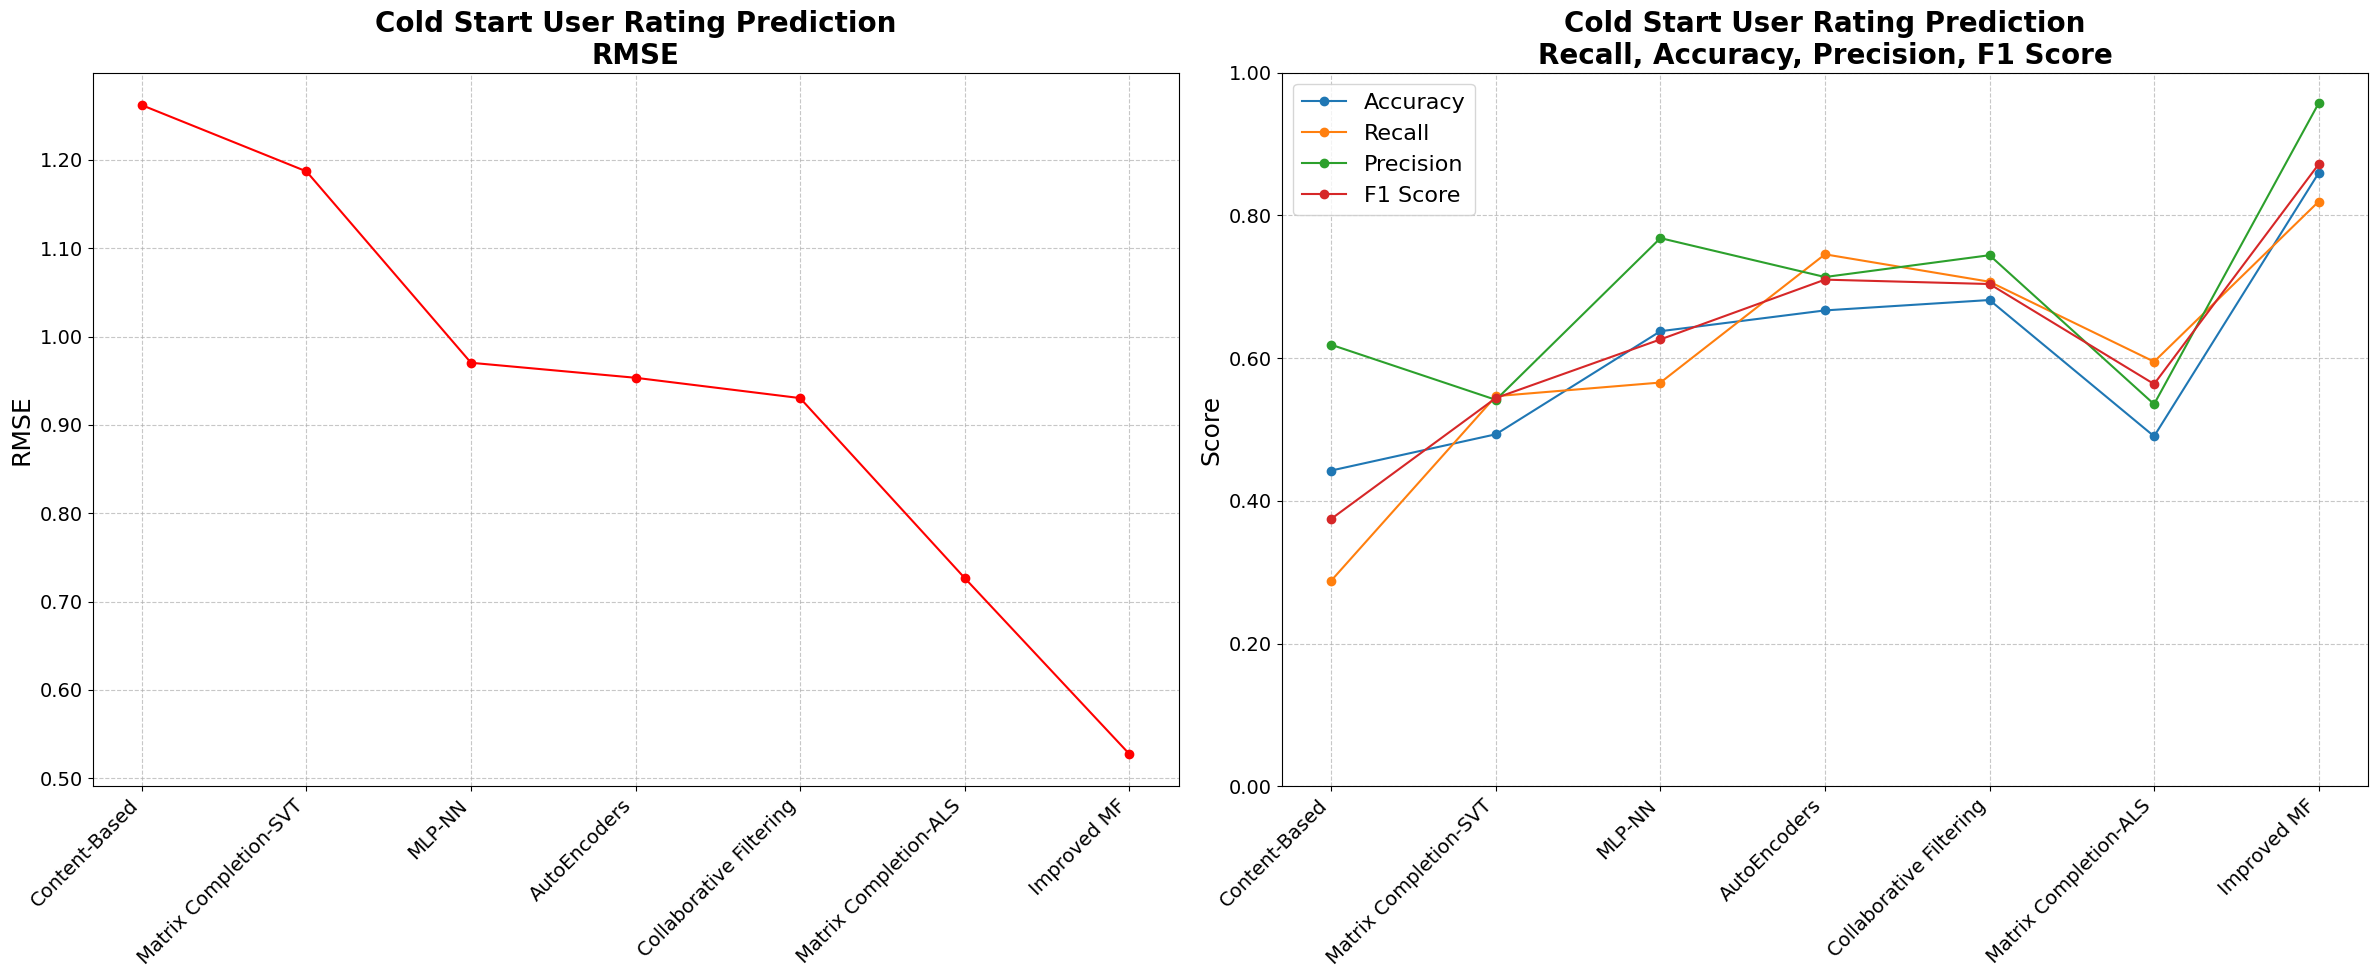

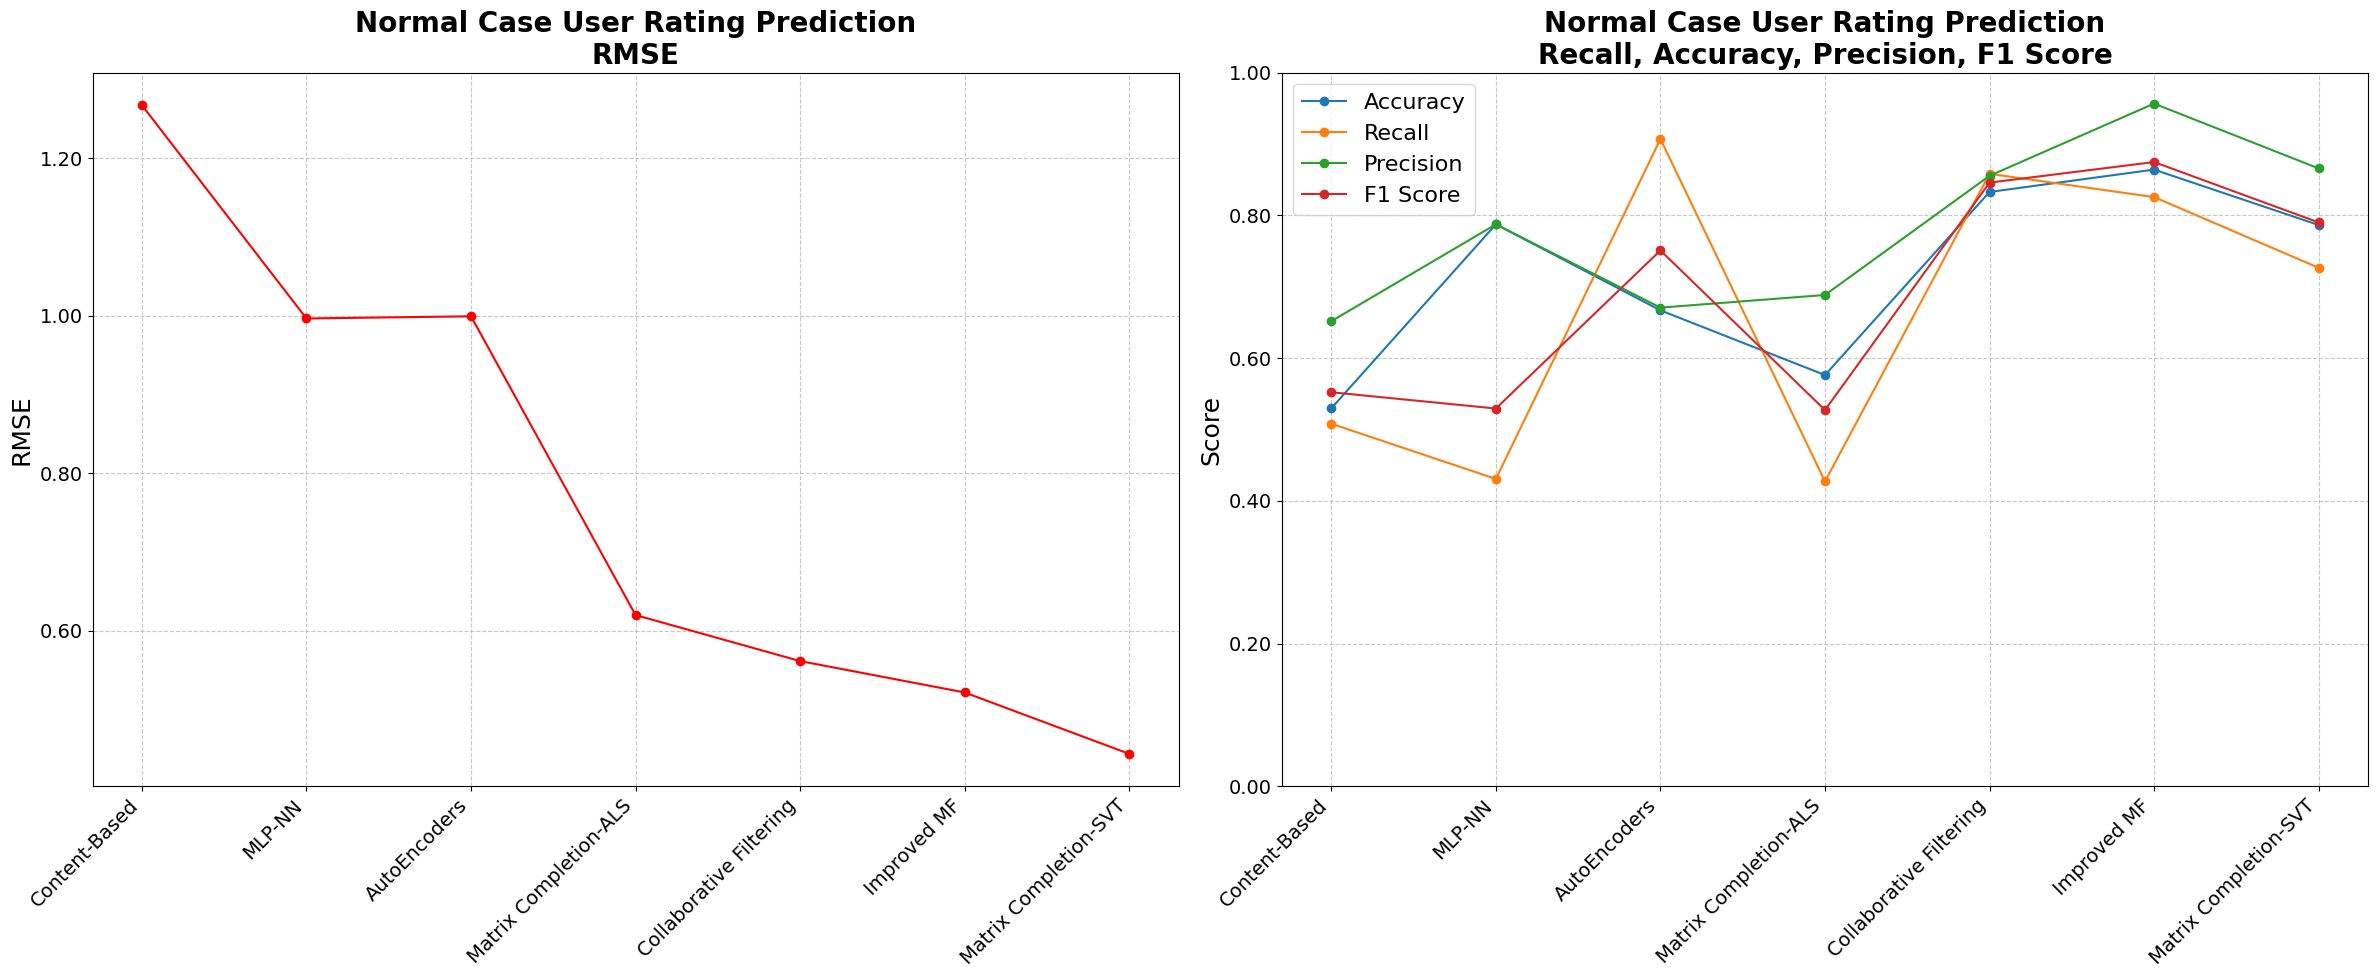

In [ ]:
plt.rcParams.update({'font.size': 14})

models = ['Content-Based', 'Matrix Completion-SVT', 'MLP-NN', 'AutoEncoders', 'Collaborative Filtering', 'Matrix Completion-ALS', 'Improved MF']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

cold_start_data = np.array([
    [accuracy_cold1_1, accuracy_cold3_1_3, accuracy_cold5_1_2, accuracy_cold6_1_2, accuracy_cold2_1_2, accuracy_cold4_1_2, accuracy_cold7_1_3],
    [recall_cold1_1, recall_cold3_1_3, recall_cold5_1_2, recall_cold6_1_2, recall_cold2_1_2, recall_cold4_1_2, recall_cold7_1_3],
    [precision_cold1_1, precision_cold3_1_3, precision_cold5_1_2, precision_cold6_1_2, precision_cold2_1_2, precision_cold4_1_2, precision_cold7_1_3],
    [f1_cold1_1, f1_cold3_1_3, f1_cold5_1_2, f1_cold6_1_2, f1_cold2_1_2, f1_cold4_1_2, f1_cold7_1_3]
])

cold_start_rmse = np.array([rmse_cold1_1, rmse_cold3_1_3, rmse_cold5_1_2, rmse_cold6_1_2, rmse_cold2_1_2, rmse_cold4_1_2, rmse_cold7_1_3])




# Plot for Cold Start User Rating Prediction
plot_metrics_and_rmse(cold_start_data, cold_start_rmse, 'Cold Start User Rating Prediction')


plt.rcParams.update({'font.size': 14})

models = ['Content-Based', 'MLP-NN', 'AutoEncoders', 'Matrix Completion-ALS', 'Collaborative Filtering', 'Improved MF', 'Matrix Completion-SVT']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

partial_ratings_data = np.array([
    [accuracy_partial1_1, precision_partial5_1_2, accuracy_partial6_1, accuracy_partial4_1_2, accuracy_partial2_1_2, accuracy_partial7_1_3, accuracy_partial3_1_3],
    [recall_partial1_1, recall_partial5_1_2, recall_partial6_1, recall_partial4_1_2, recall_partial2_1_2, recall_partial7_1_3, recall_partial3_1_3],
    [precision_partial1_1, precision_partial5_1_2, precision_partial6_1, precision_partial4_1_2, precision_partial2_1_2, precision_partial7_1_3, precision_partial3_1_3],
    [f1_partial1_1, f1_partial5_1_2, f1_partial6_1, f1_partial4_1_2, f1_partial2_1_2, f1_partial7_1_3, f1_partial3_1_3]
])
partial_ratings_rmse = np.array([rmse_partial1_1, rmse_partial5_1_2, rmse_partial6_1, rmse_partial4_1_2, rmse_partial2_1_2, rmse_partial7_1_3, rmse_partial3_1_3])

# Plot for Normal Case User Rating Prediction
plot_metrics_and_rmse(partial_ratings_data, partial_ratings_rmse, 'Normal Case User Rating Prediction')

# Collaborative Filtering - Similarity

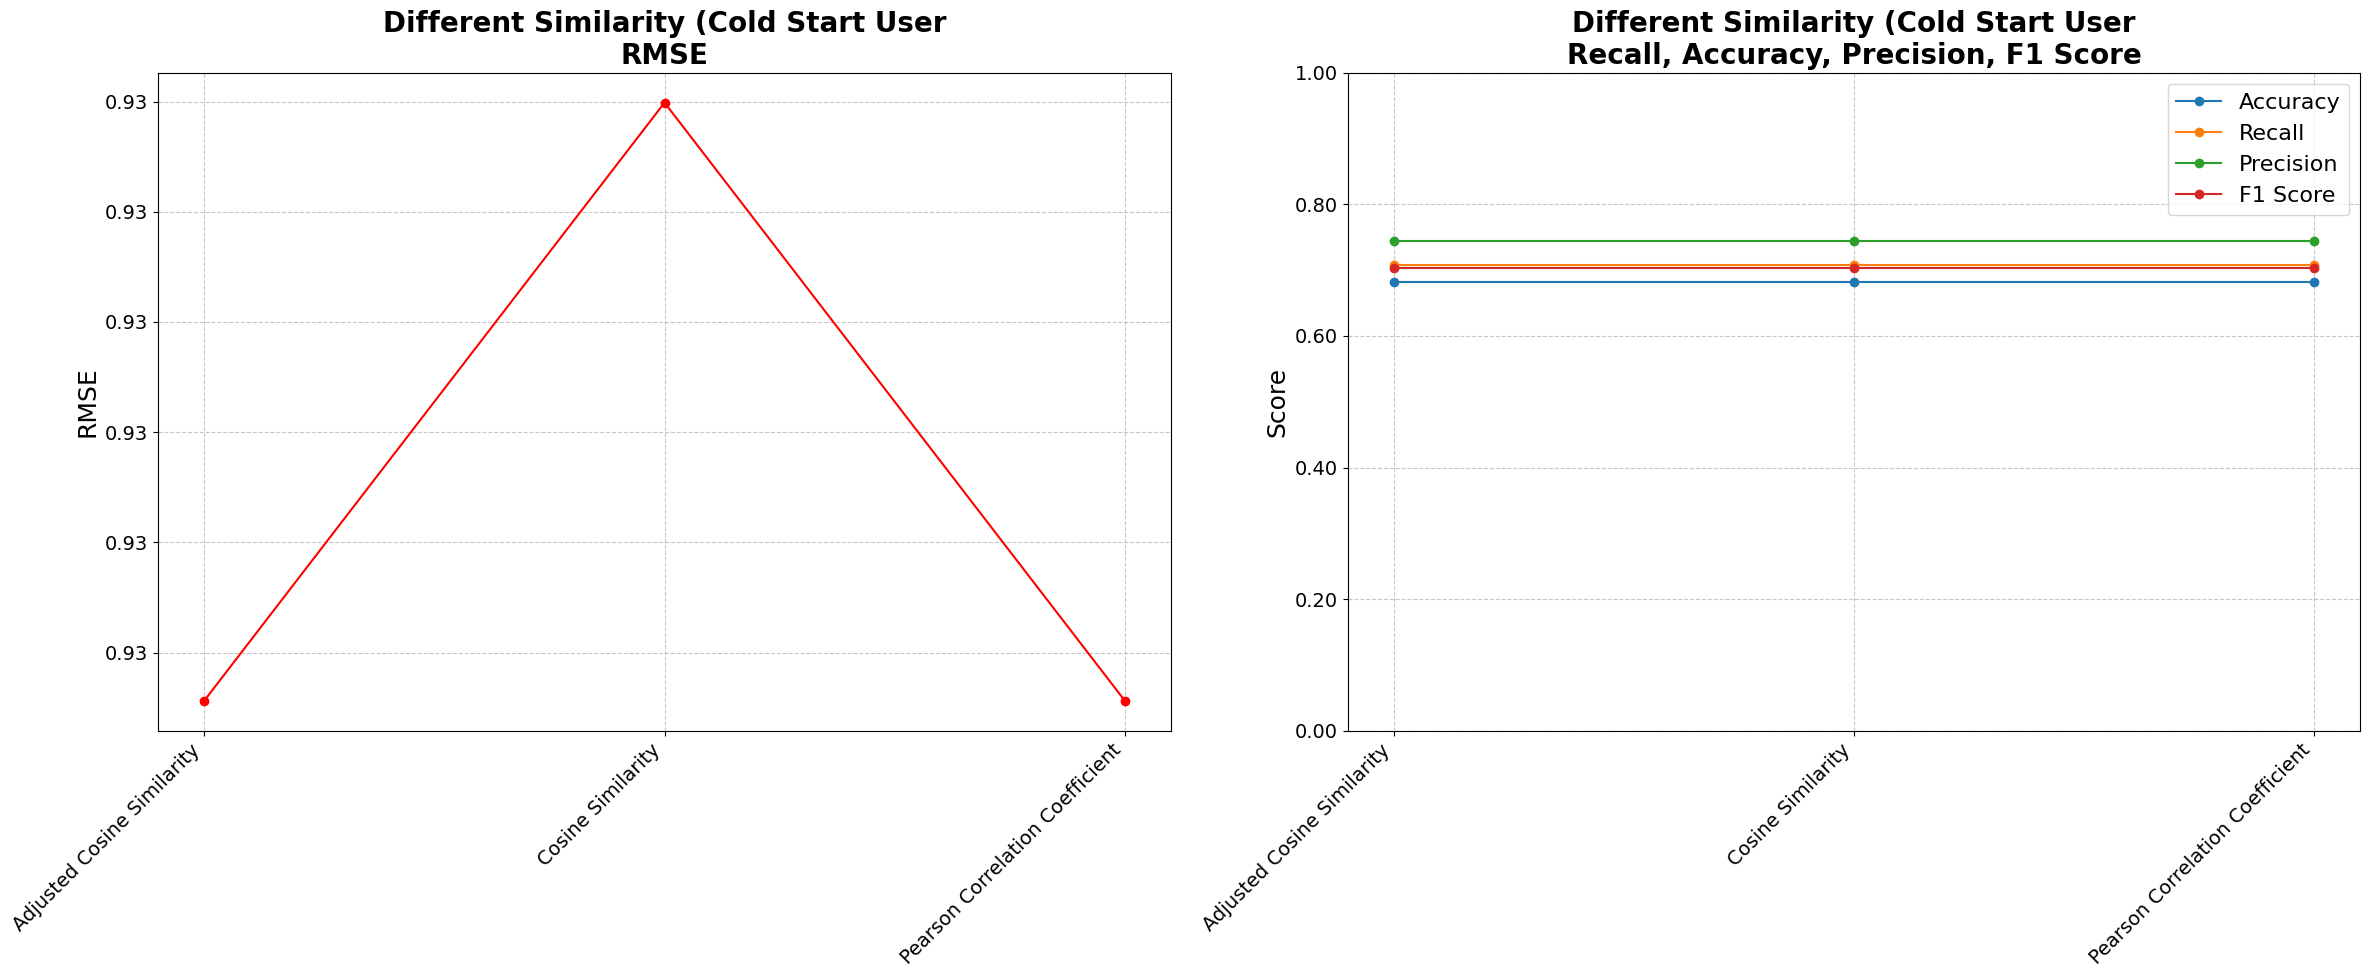

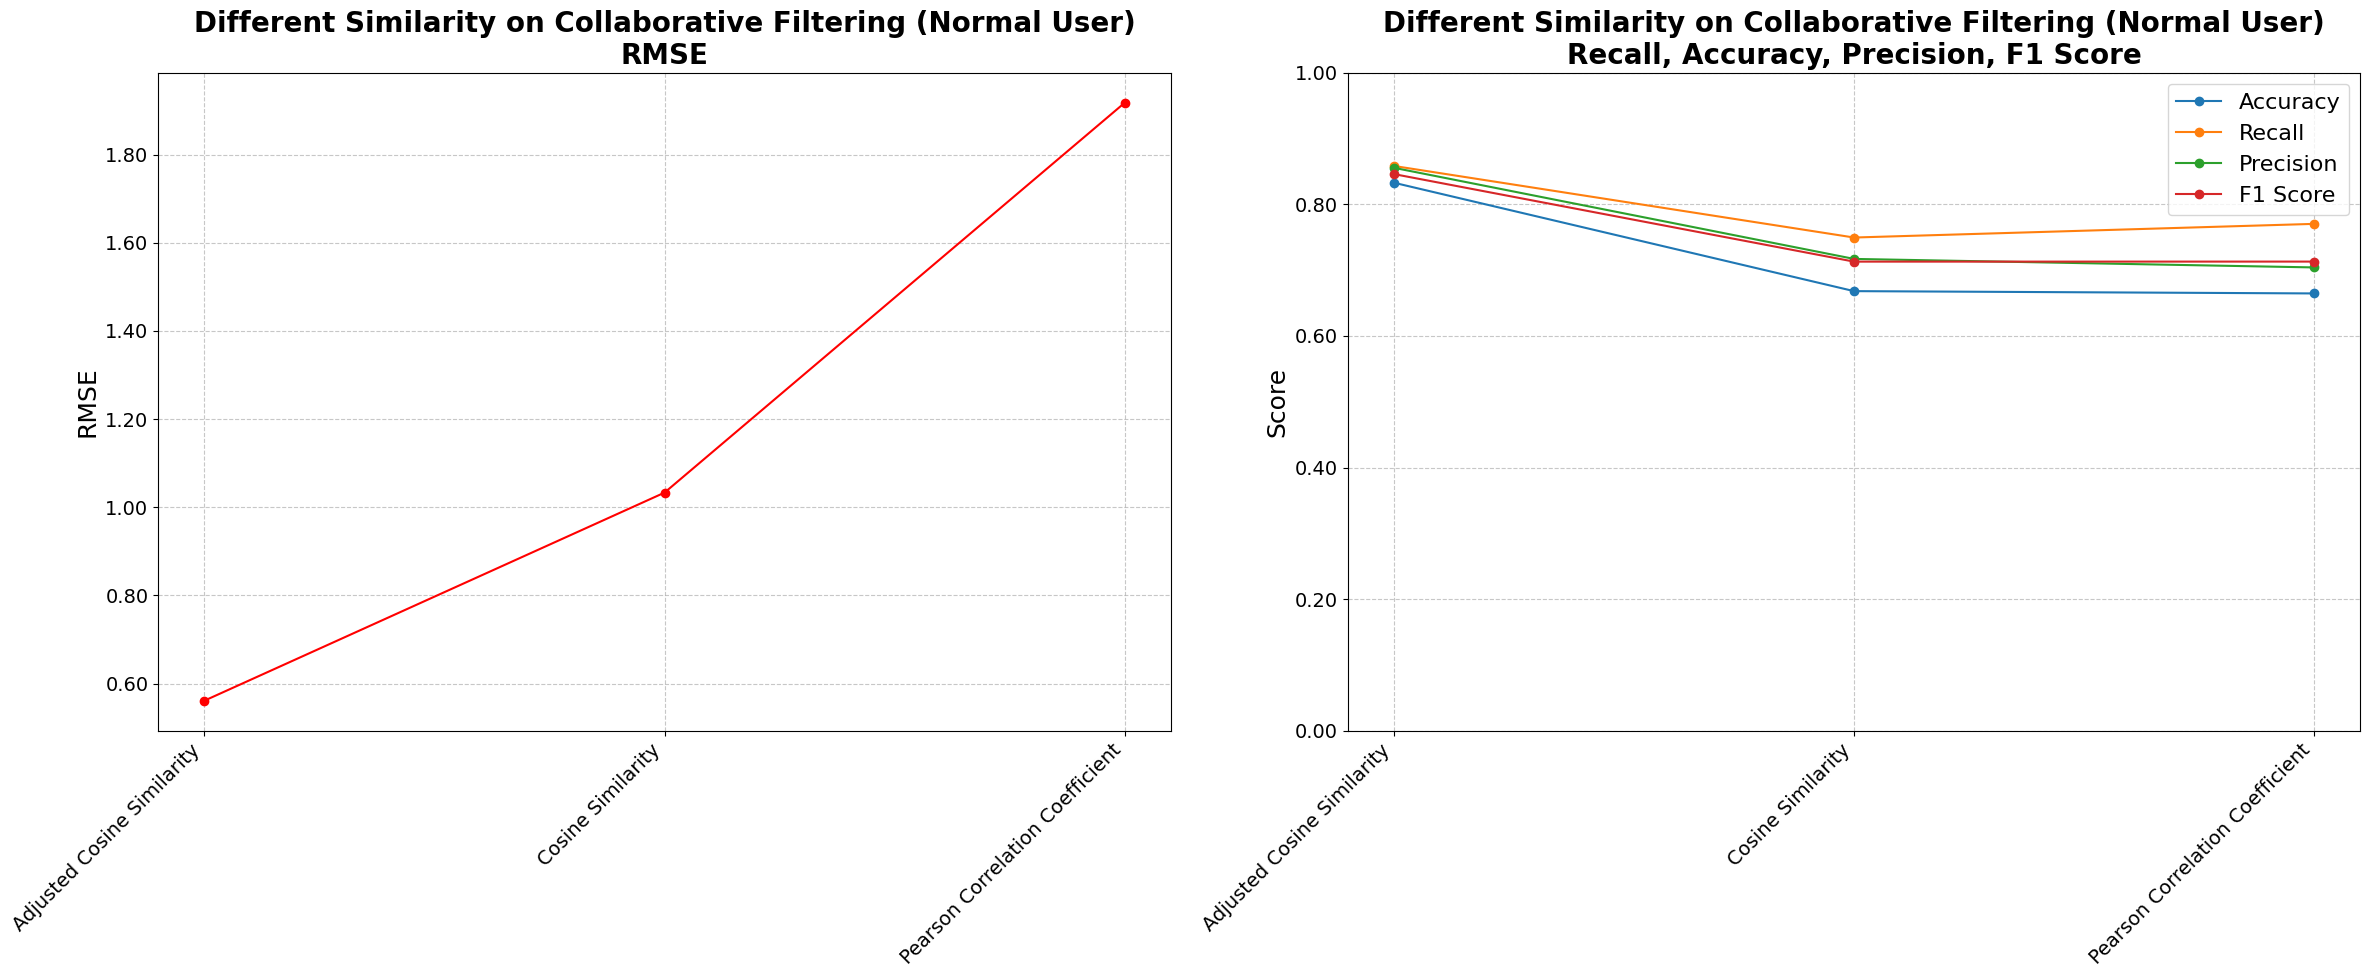

In [ ]:
models = ['Adjusted Cosine Similarity', 'Cosine Similarity', 'Pearson Correlation Coefficient']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

cold_start_data = np.array([
    [accuracy_cold2_1_2, accuracy_cold2_1, accuracy_cold2_1_3],
    [recall_cold2_1_2, recall_cold2_1, recall_cold2_1_3],
    [precision_cold2_1_2, precision_cold2_1, precision_cold2_1_3],
    [f1_cold2_1_2, f1_cold2_1, f1_cold2_1_3] 
])
cold_start_rmse = np.array([rmse_cold2_1_2, rmse_cold2_1, rmse_cold2_1_3])

partial_ratings_data = np.array([
    [accuracy_partial2_1_2, accuracy_partial2_1, accuracy_partial2_1_3],
    [recall_partial2_1_2, recall_partial2_1, recall_partial2_1_3],
    [precision_partial2_1_2, precision_partial2_1, precision_partial2_1_3],
    [f1_partial2_1_2, f1_partial2_1, f1_partial2_1_3]
])
partial_ratings_rmse = np.array([rmse_partial2_1_2, rmse_partial2_1, rmse_partial2_1_3])



# Plot for Cold Start User Rating Prediction
plot_metrics_and_rmse(cold_start_data, cold_start_rmse, 'Different Similarity (Cold Start User')

# Plot for Normal Case User Rating Prediction
plot_metrics_and_rmse(partial_ratings_data, partial_ratings_rmse, 'Different Similarity on Collaborative Filtering (Normal User)')



# SVT - Hyper parameter

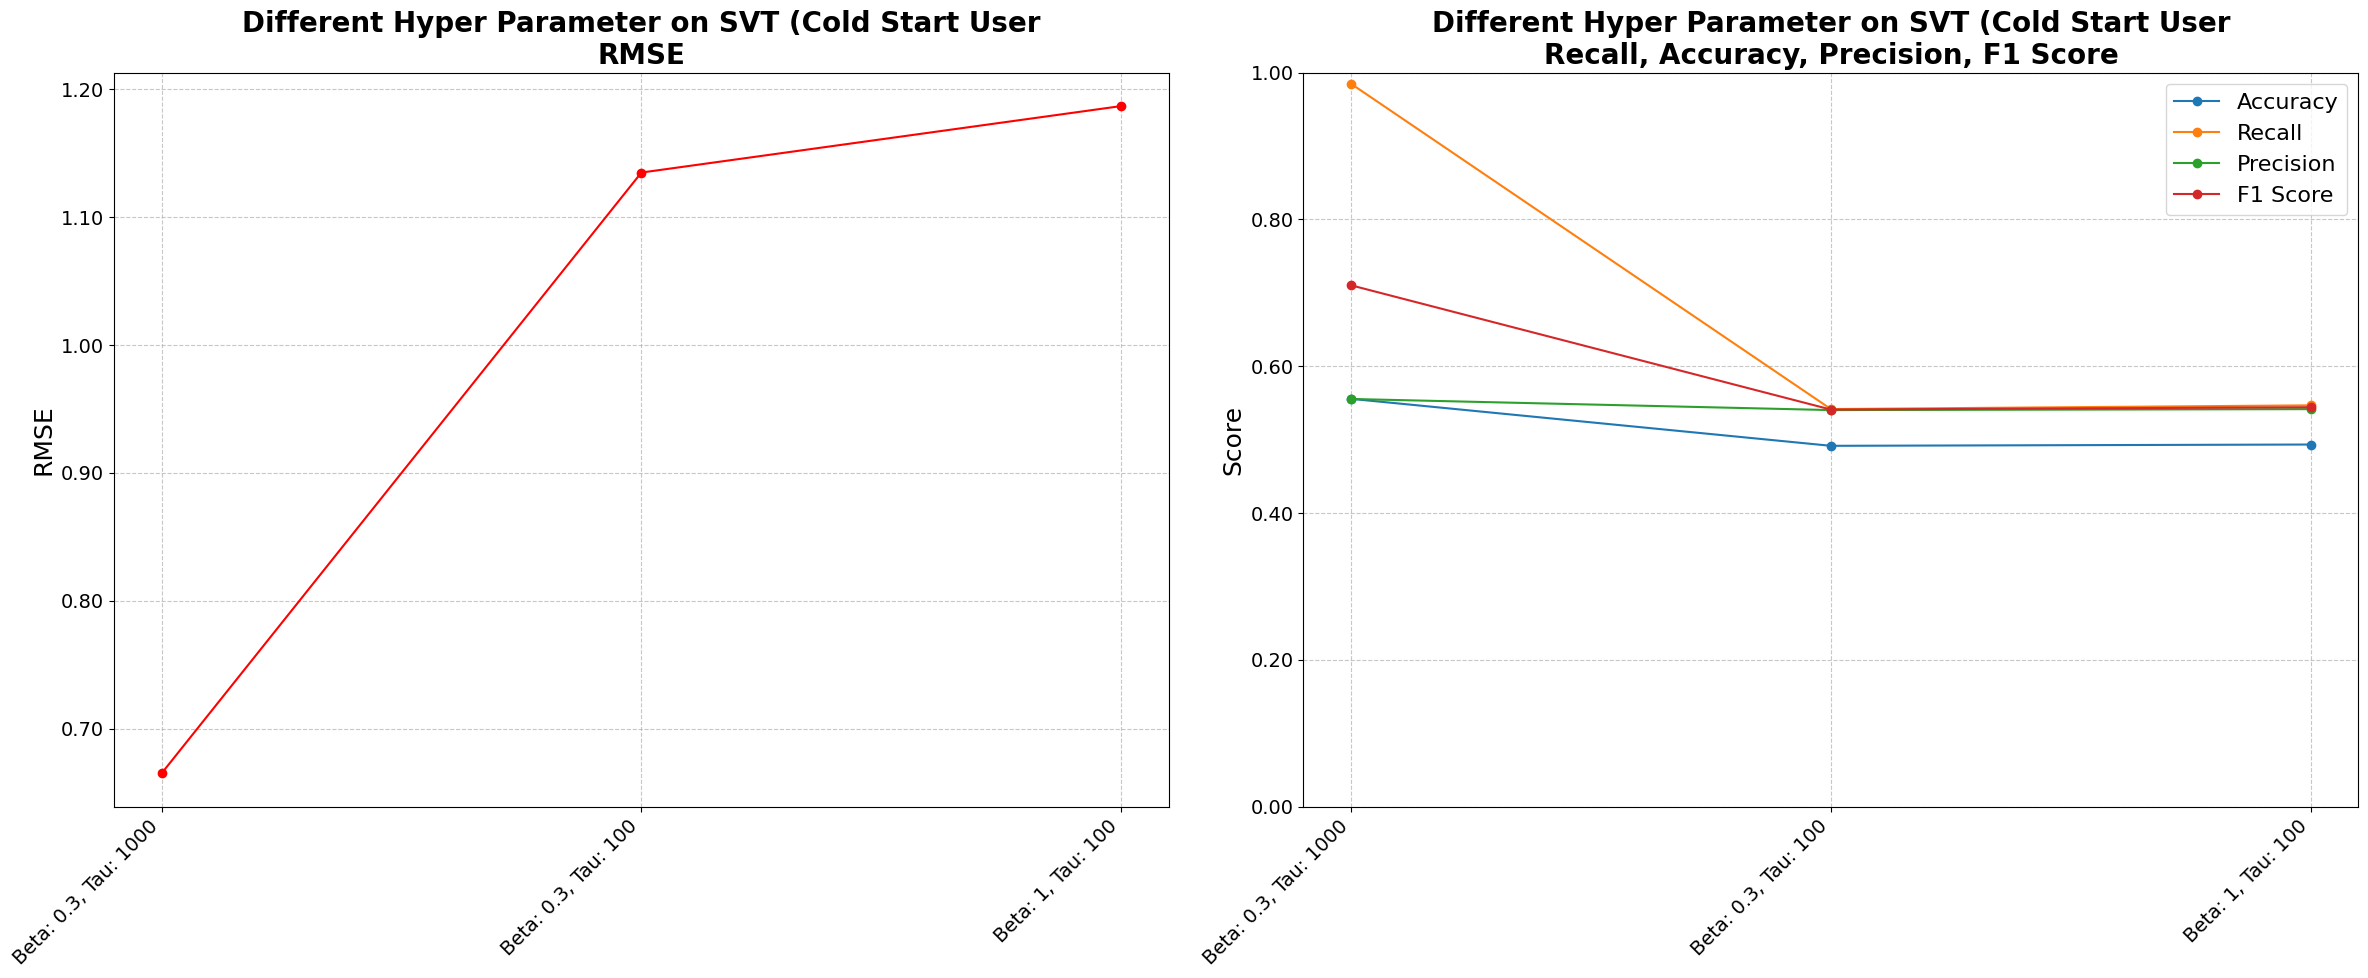

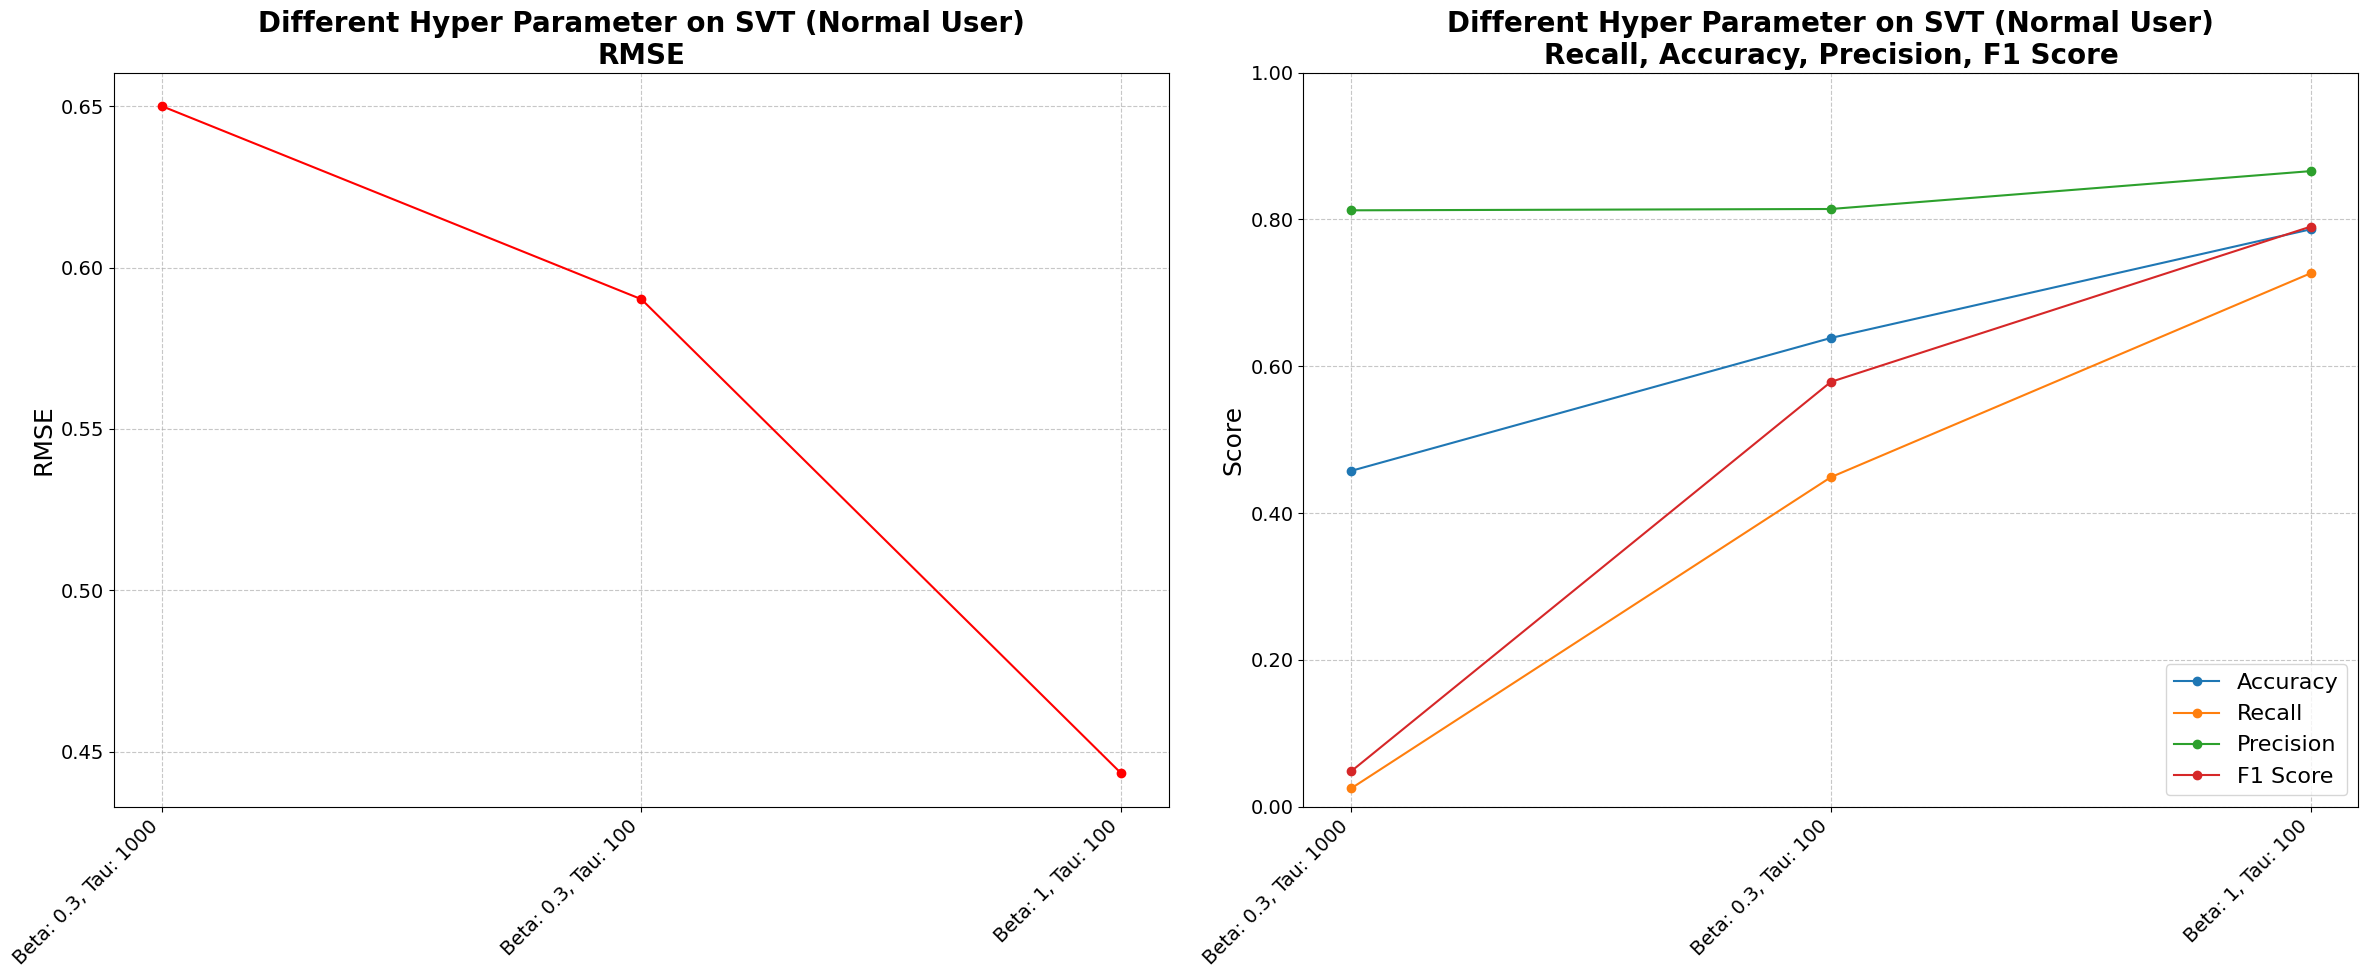

In [ ]:
models = ['Beta: 0.3, Tau: 1000', 'Beta: 0.3, Tau: 100', 'Beta: 1, Tau: 100']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

cold_start_data = np.array([
    [accuracy_cold3_1, accuracy_cold3_1_2, accuracy_cold3_1_3],
    [recall_cold3_1, recall_cold3_1_2, recall_cold3_1_3],
    [precision_cold3_1, precision_cold3_1_2, precision_cold3_1_3],
    [f1_cold3_1, f1_cold3_1_2, f1_cold3_1_3]
 ])
cold_start_rmse = np.array([rmse_cold3_1, rmse_cold3_1_2, rmse_cold3_1_3])

partial_ratings_data = np.array([
    [accuracy_partial3_1, accuracy_partial3_1_2, accuracy_partial3_1_3],
    [recall_partial3_1, recall_partial3_1_2, recall_partial3_1_3],
    [precision_partial3_1, precision_partial3_1_2, precision_partial3_1_3],
    [f1_partial3_1, f1_partial3_1_2, f1_partial3_1_3]
])
partial_ratings_rmse = np.array([rmse_partial3_1, rmse_partial3_1_2, rmse_partial3_1_3])

# Plot for Cold Start User Rating Prediction
plot_metrics_and_rmse(cold_start_data, cold_start_rmse, 'Different Hyper Parameter on SVT (Cold Start User')

# Plot for Normal Case User Rating Prediction
plot_metrics_and_rmse(partial_ratings_data, partial_ratings_rmse, 'Different Hyper Parameter on SVT (Normal User)')



# ALS with Cold User Filled in

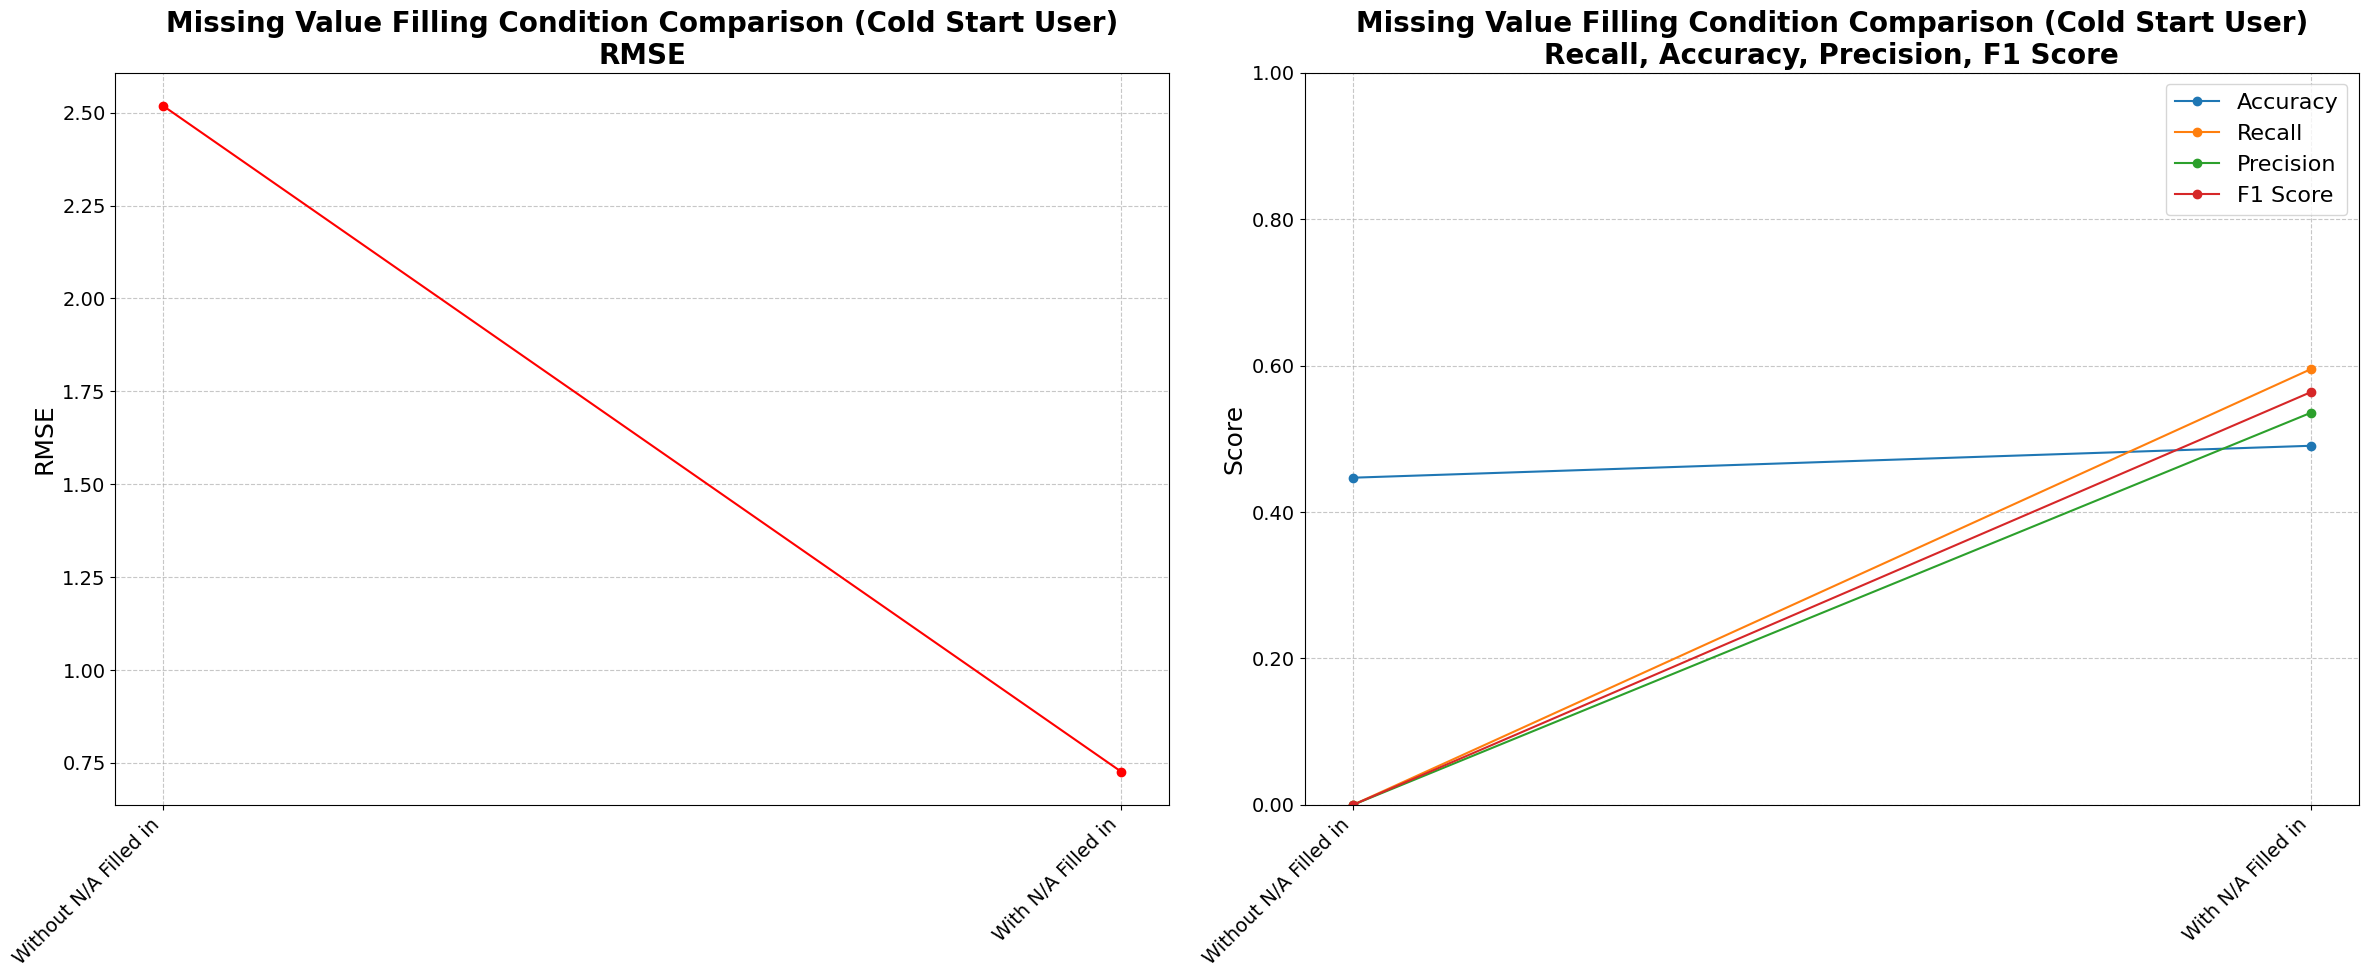

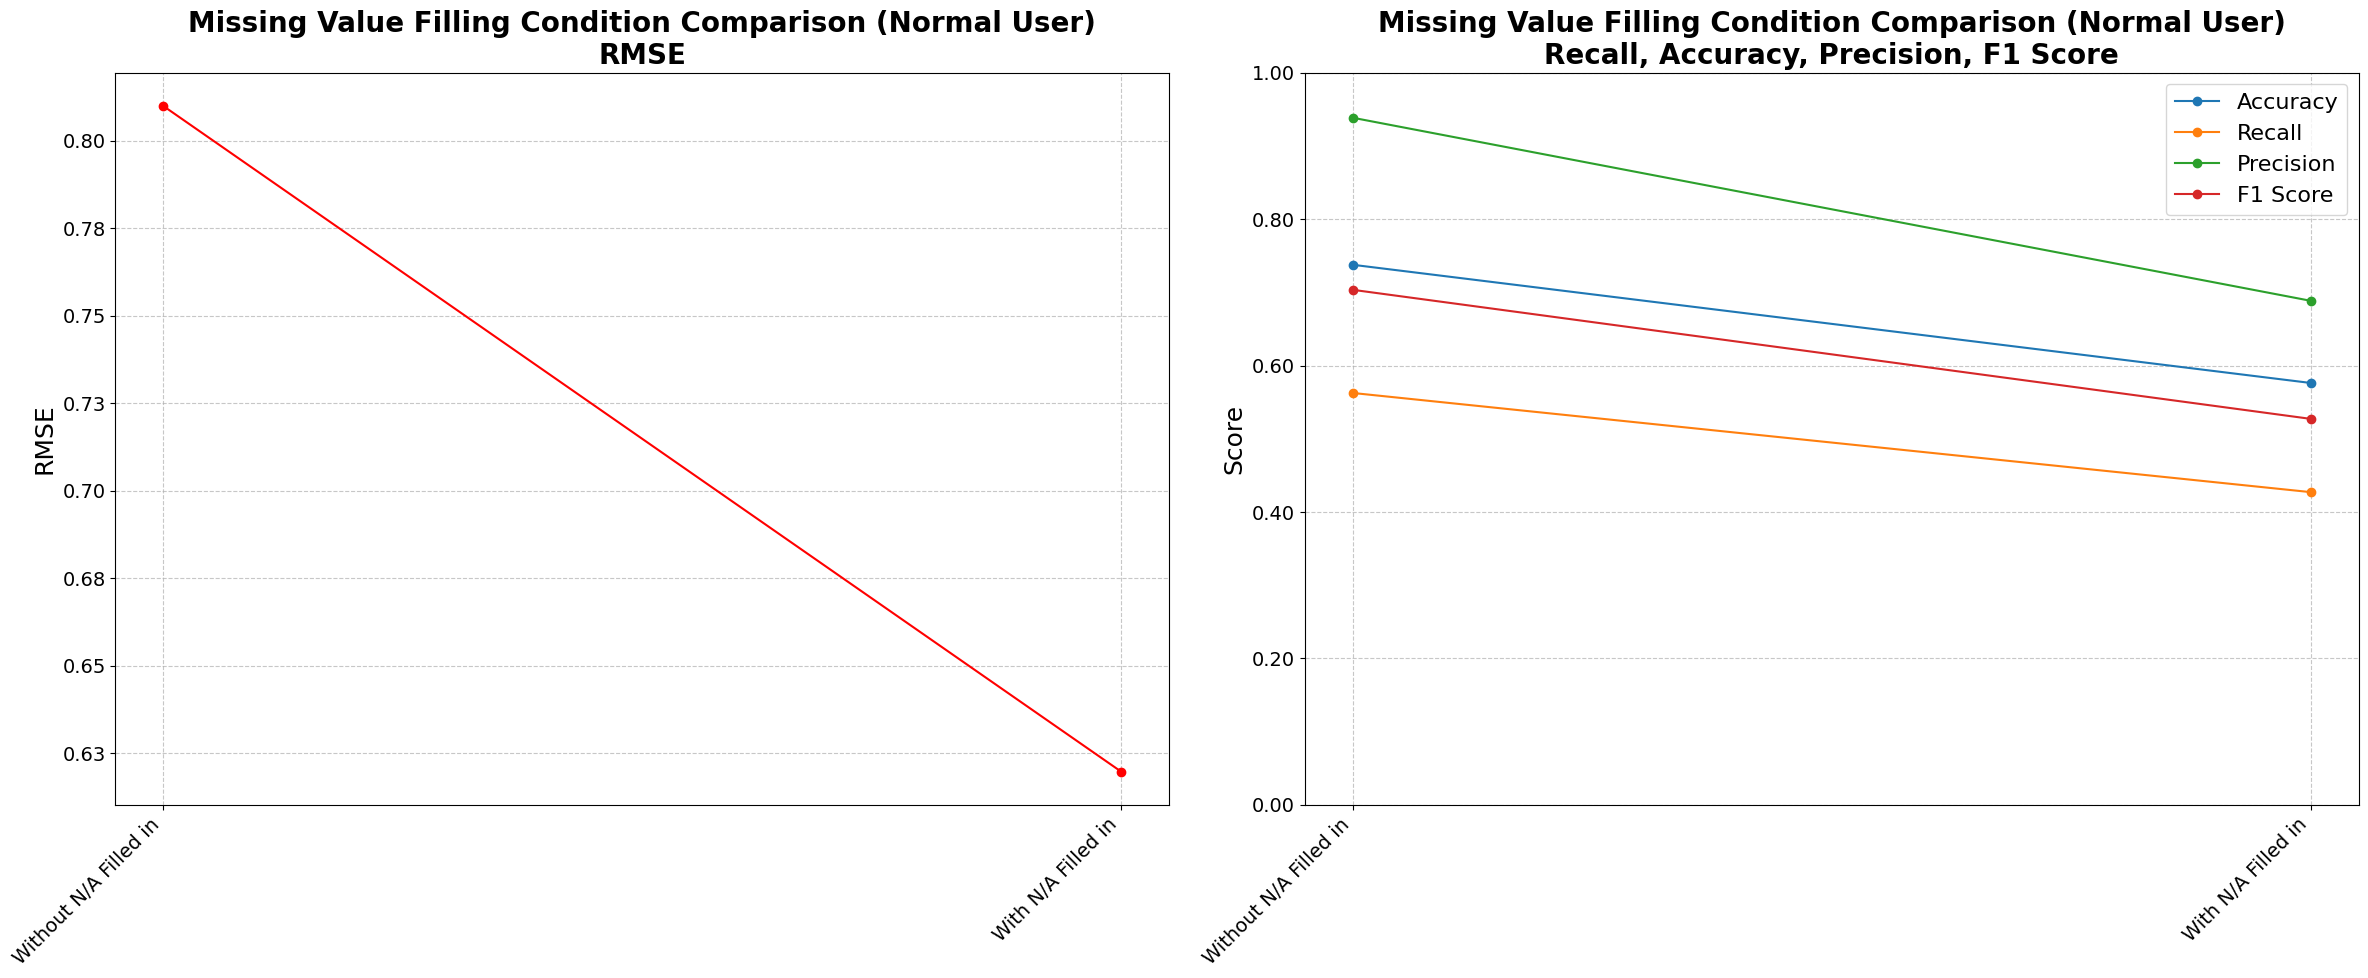

In [ ]:
models = ['Without N/A Filled in', 'With N/A Filled in']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

cold_start_data = np.array([
    [accuracy_cold4_1, accuracy_cold4_1_2],
    [recall_cold4_1, recall_cold4_1_2],
    [precision_cold4_1, precision_cold4_1_2],
    [f1_cold4_1, f1_cold4_1_2]
])
cold_start_rmse = np.array([rmse_cold4_1, rmse_cold4_1_2])

partial_ratings_data = np.array([
    [accuracy_partial4_1, accuracy_partial4_1_2],
    [recall_partial4_1, recall_partial4_1_2],
    [precision_partial4_1, precision_partial4_1_2],
    [f1_partial4_1, f1_partial4_1_2]
])
partial_ratings_rmse = np.array([rmse_partial4_1, rmse_partial4_1_2])

# Plot for Cold Start User Rating Prediction
plot_metrics_and_rmse(cold_start_data, cold_start_rmse, 'Missing Value Filling Condition Comparison (Cold Start User)')

# Plot for Normal Case User Rating Prediction
plot_metrics_and_rmse(partial_ratings_data, partial_ratings_rmse, 'Missing Value Filling Condition Comparison (Normal User)')

# MLP Comparison

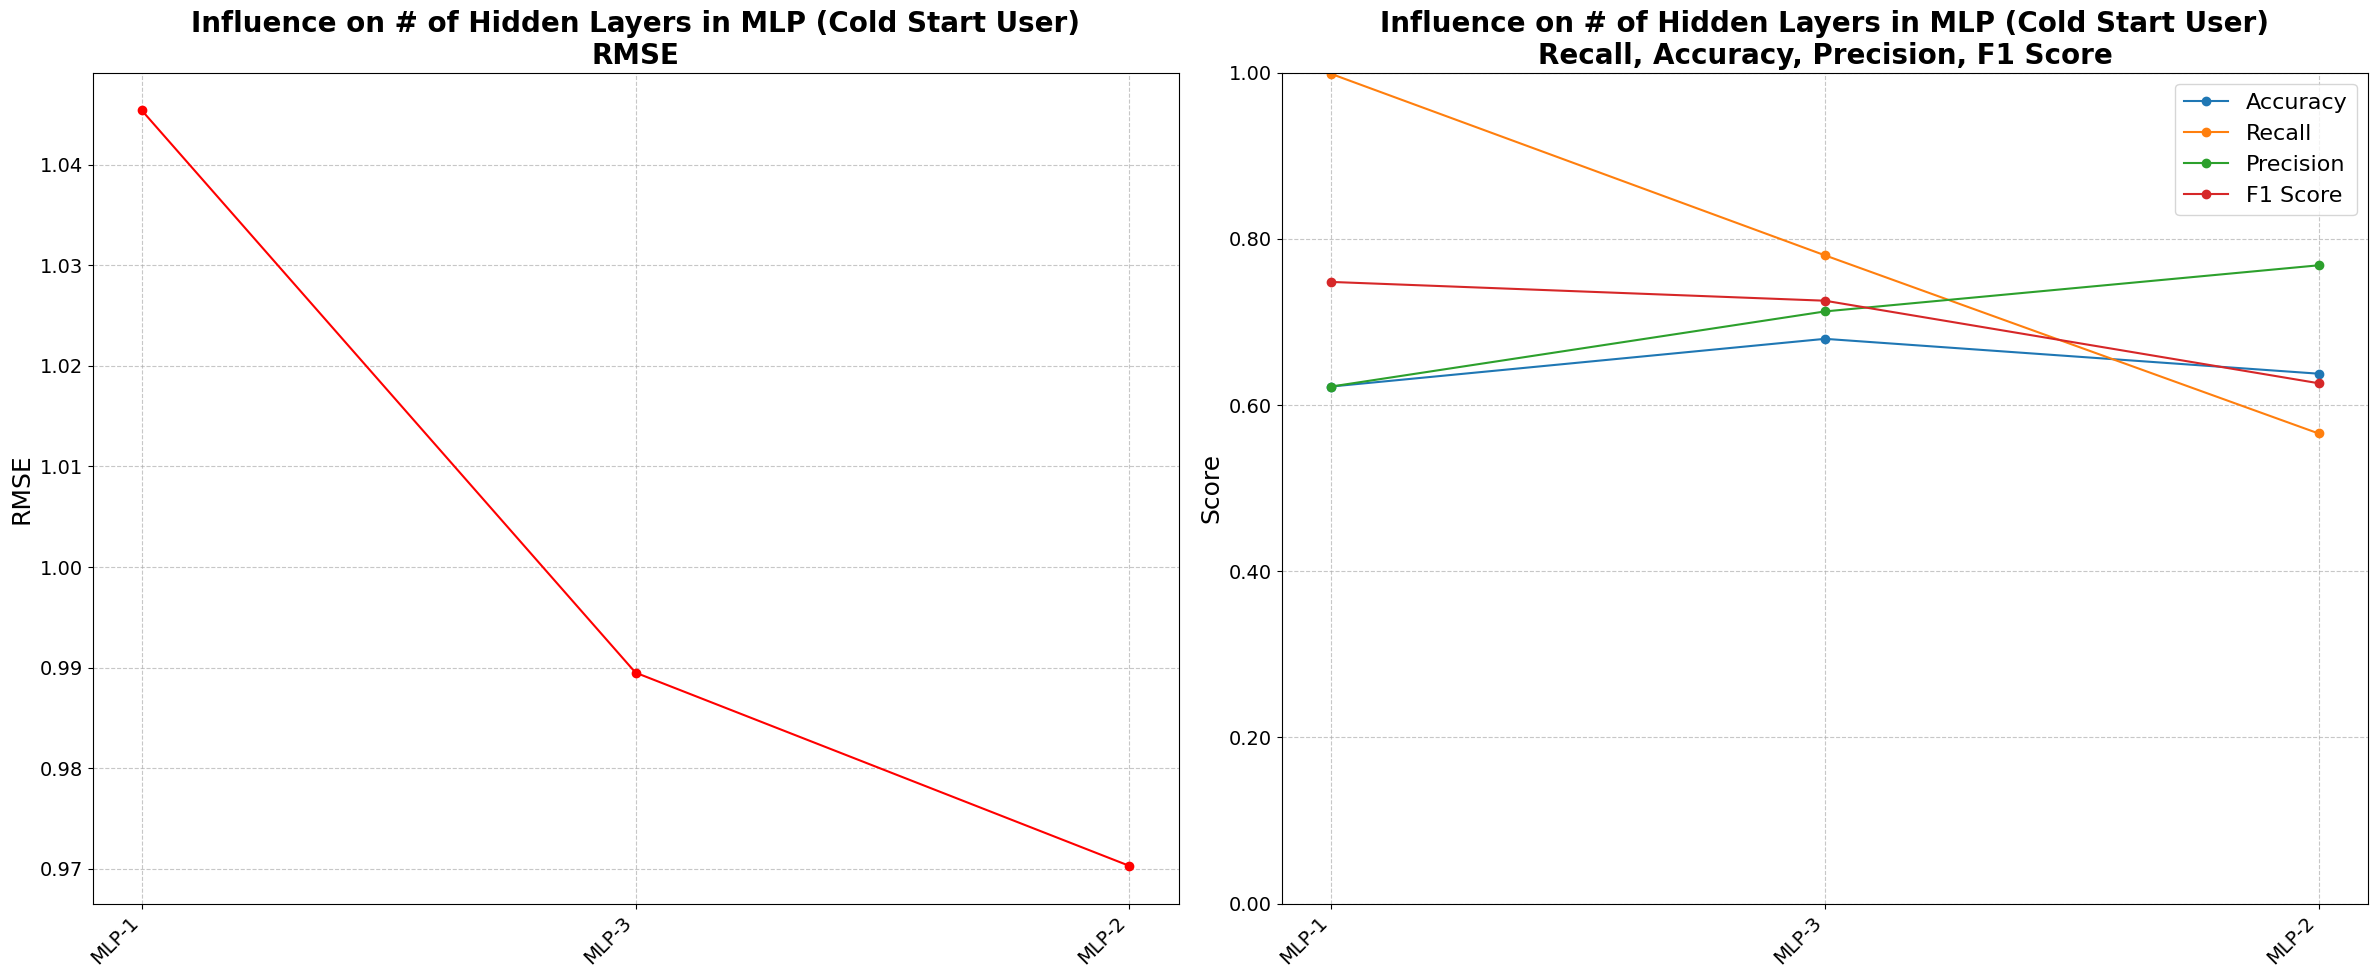

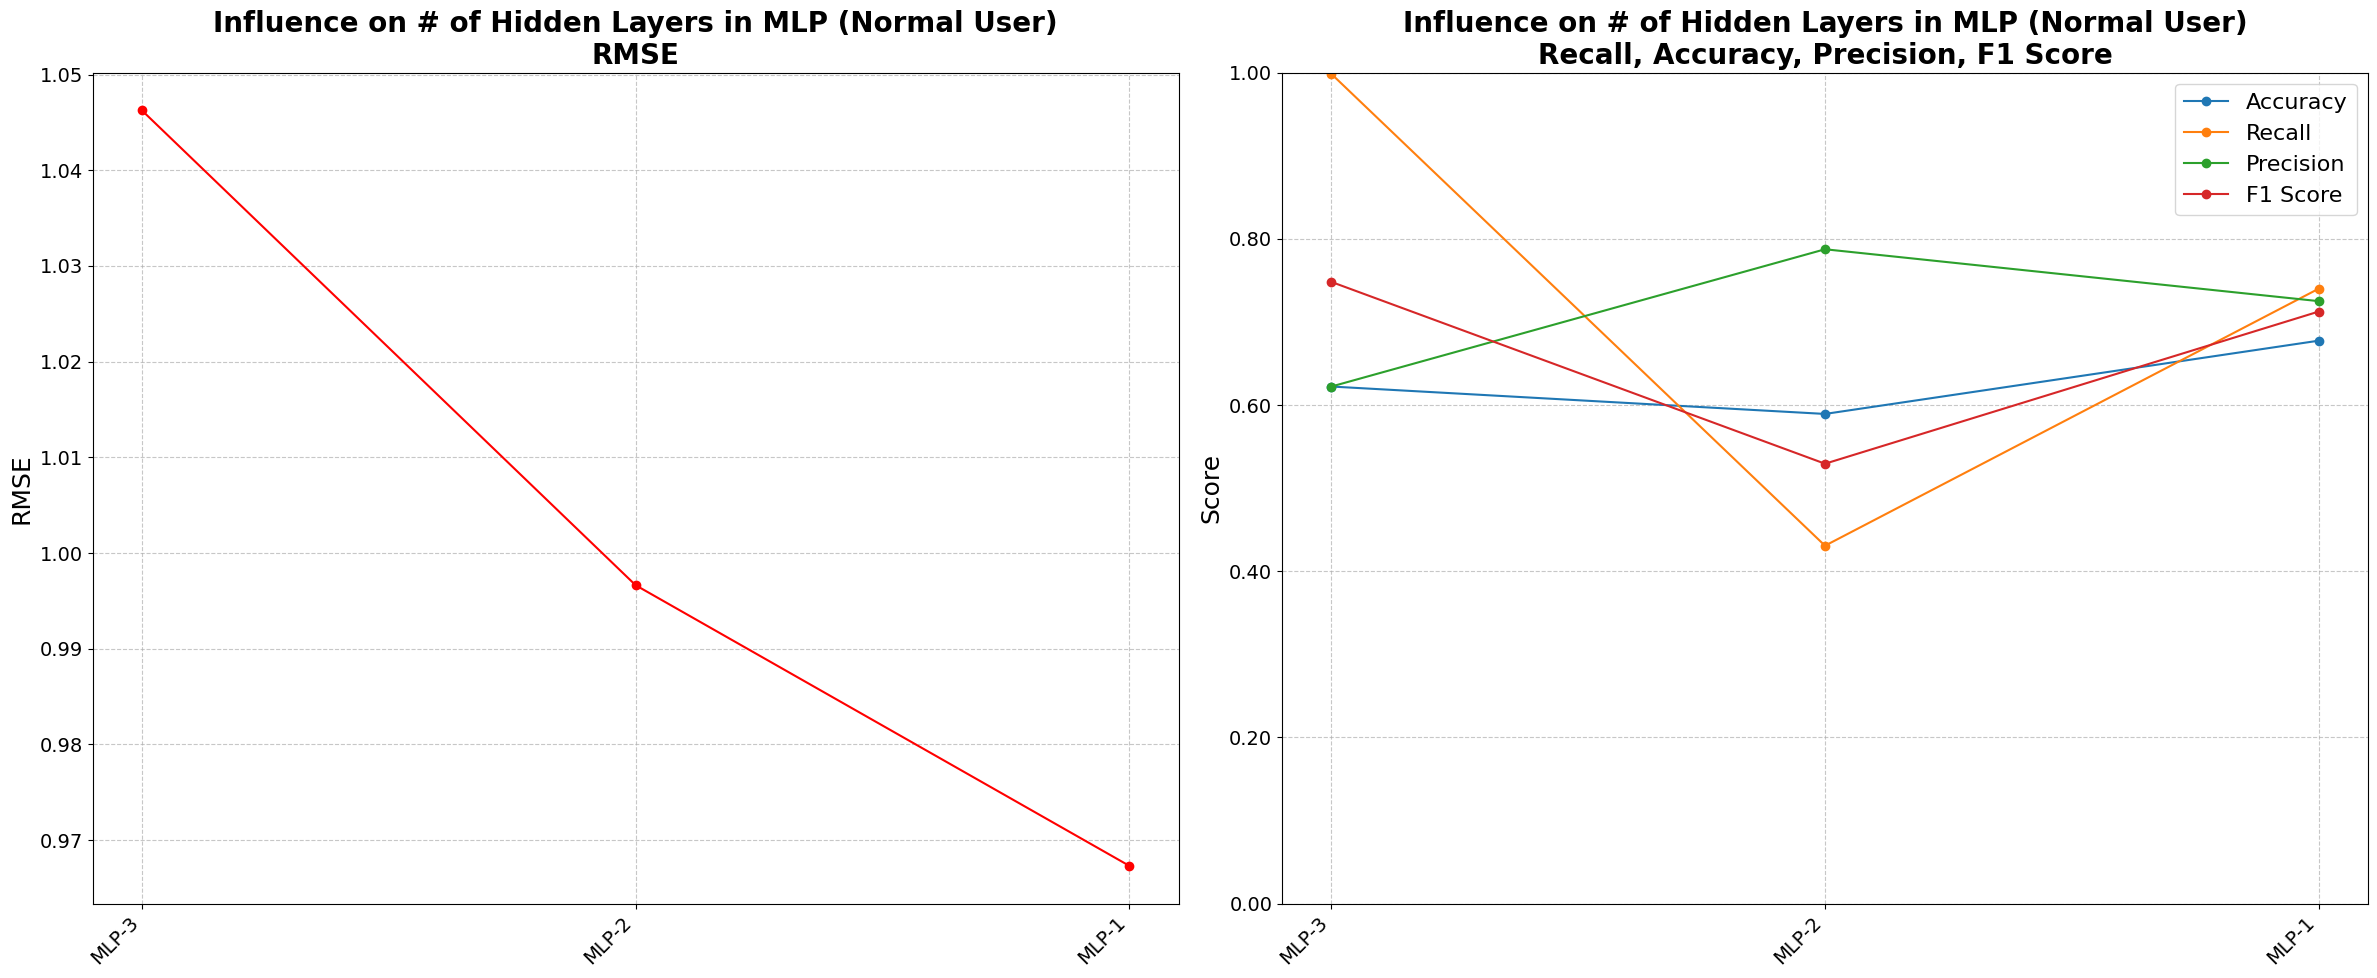

In [ ]:
models = ['MLP-1', 'MLP-3', 'MLP-2']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

cold_start_data = np.array([
    [accuracy_cold5_1, accuracy_cold5_1_3, accuracy_cold5_1_2],
    [recall_cold5_1, recall_cold5_1_3, recall_cold5_1_2],
    [precision_cold5_1, precision_cold5_1_3, precision_cold5_1_2],
    [f1_cold5_1, f1_cold5_1_3, f1_cold5_1_2]
])
cold_start_rmse = np.array([rmse_cold5_1, rmse_cold5_1_3, rmse_cold5_1_2])


# Plot for Cold Start User Rating Prediction
plot_metrics_and_rmse(cold_start_data, cold_start_rmse, 'Influence on # of Hidden Layers in MLP (Cold Start User)')

models = ['MLP-3', 'MLP-2', 'MLP-1']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

partial_ratings_data = np.array([
    [accuracy_partial5_1_3, accuracy_partial5_1_2, accuracy_partial5_1],
    [recall_partial5_1_3, recall_partial5_1_2, recall_partial5_1],
    [precision_partial5_1_3, precision_partial5_1_2, precision_partial5_1],
    [f1_partial5_1_3, f1_partial5_1_2, f1_partial5_1]
])
partial_ratings_rmse = np.array([rmse_partial5_1_3, rmse_partial5_1_2, rmse_partial5_1])
# Plot for Normal Case User Rating Prediction
plot_metrics_and_rmse(partial_ratings_data, partial_ratings_rmse, 'Influence on # of Hidden Layers in MLP (Normal User)')


# AutoEncoder, User Based vs Item Based

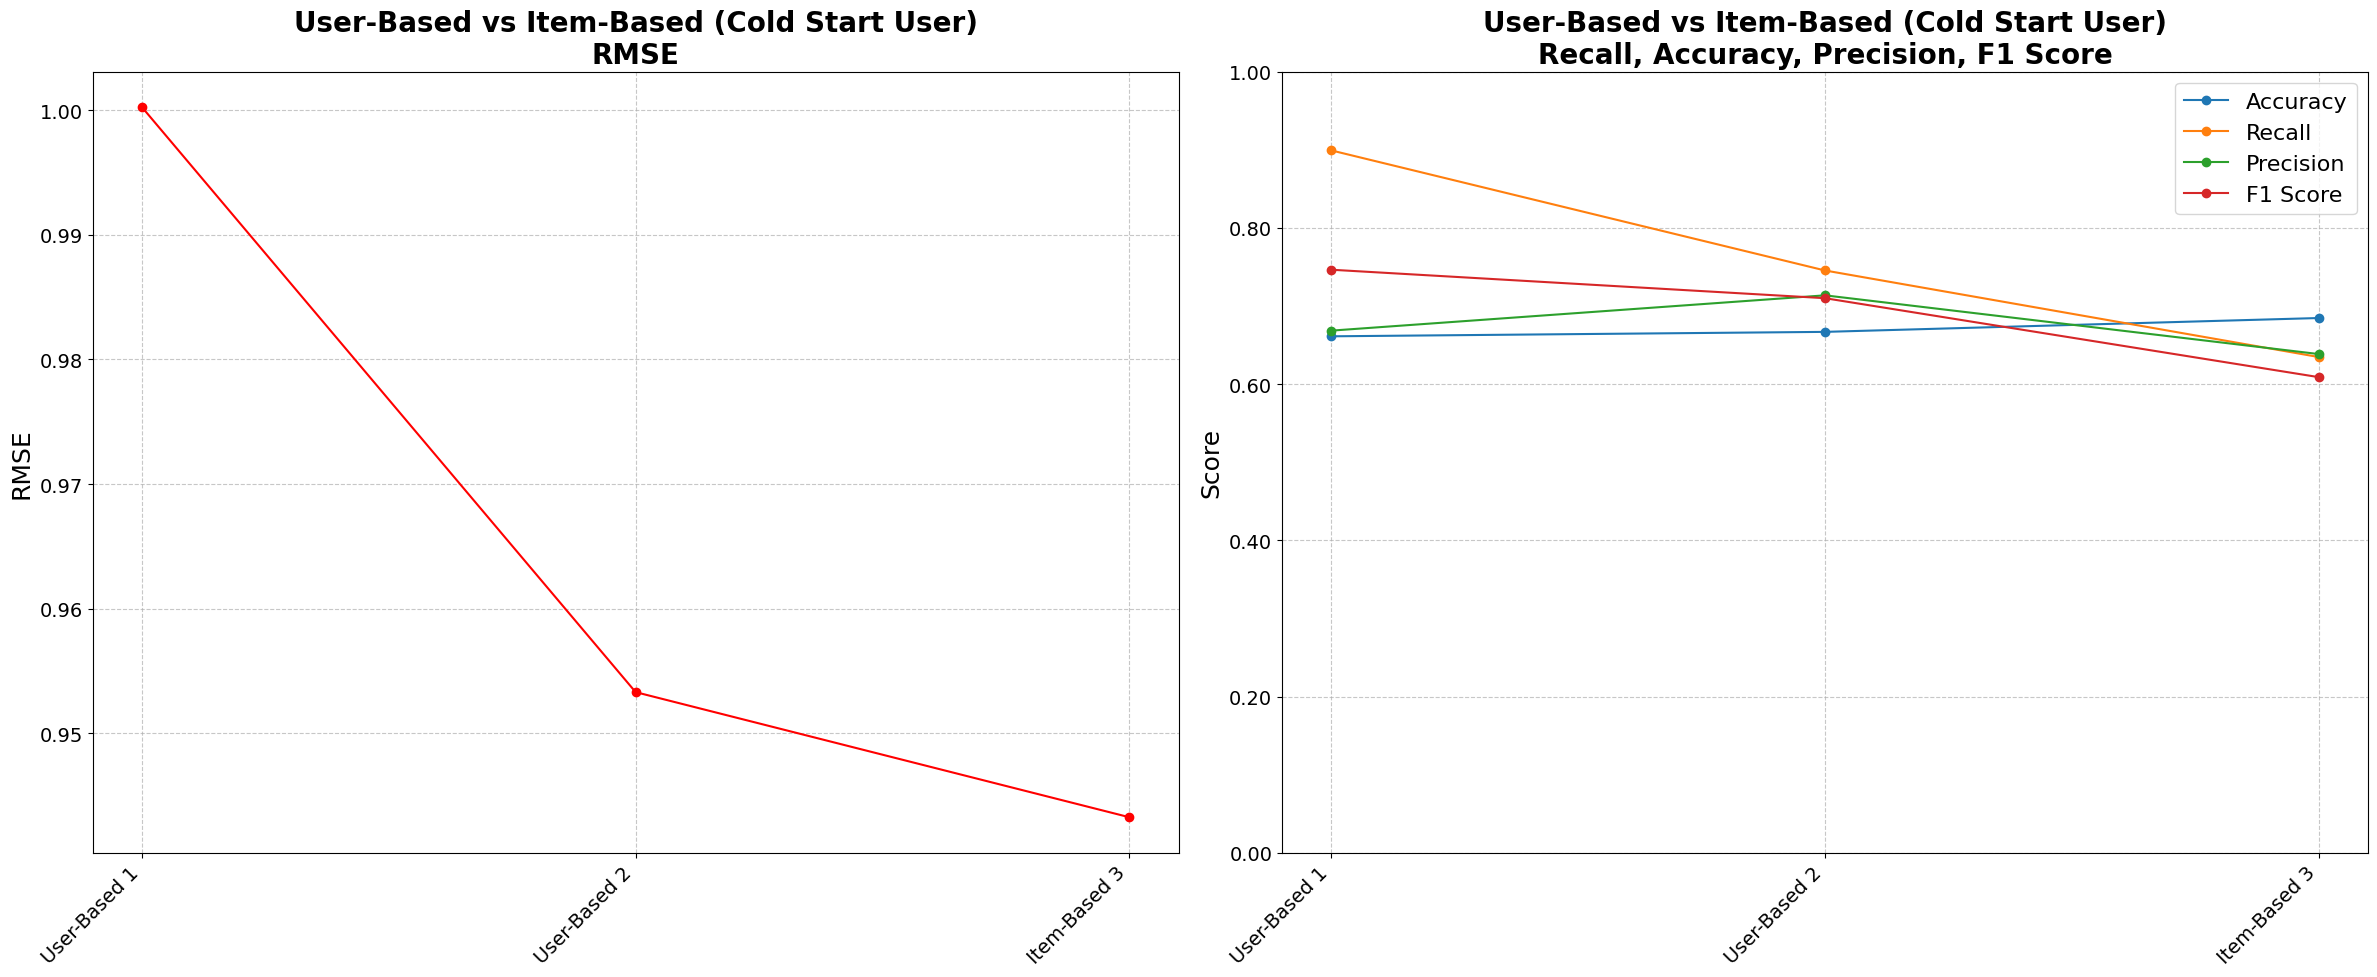

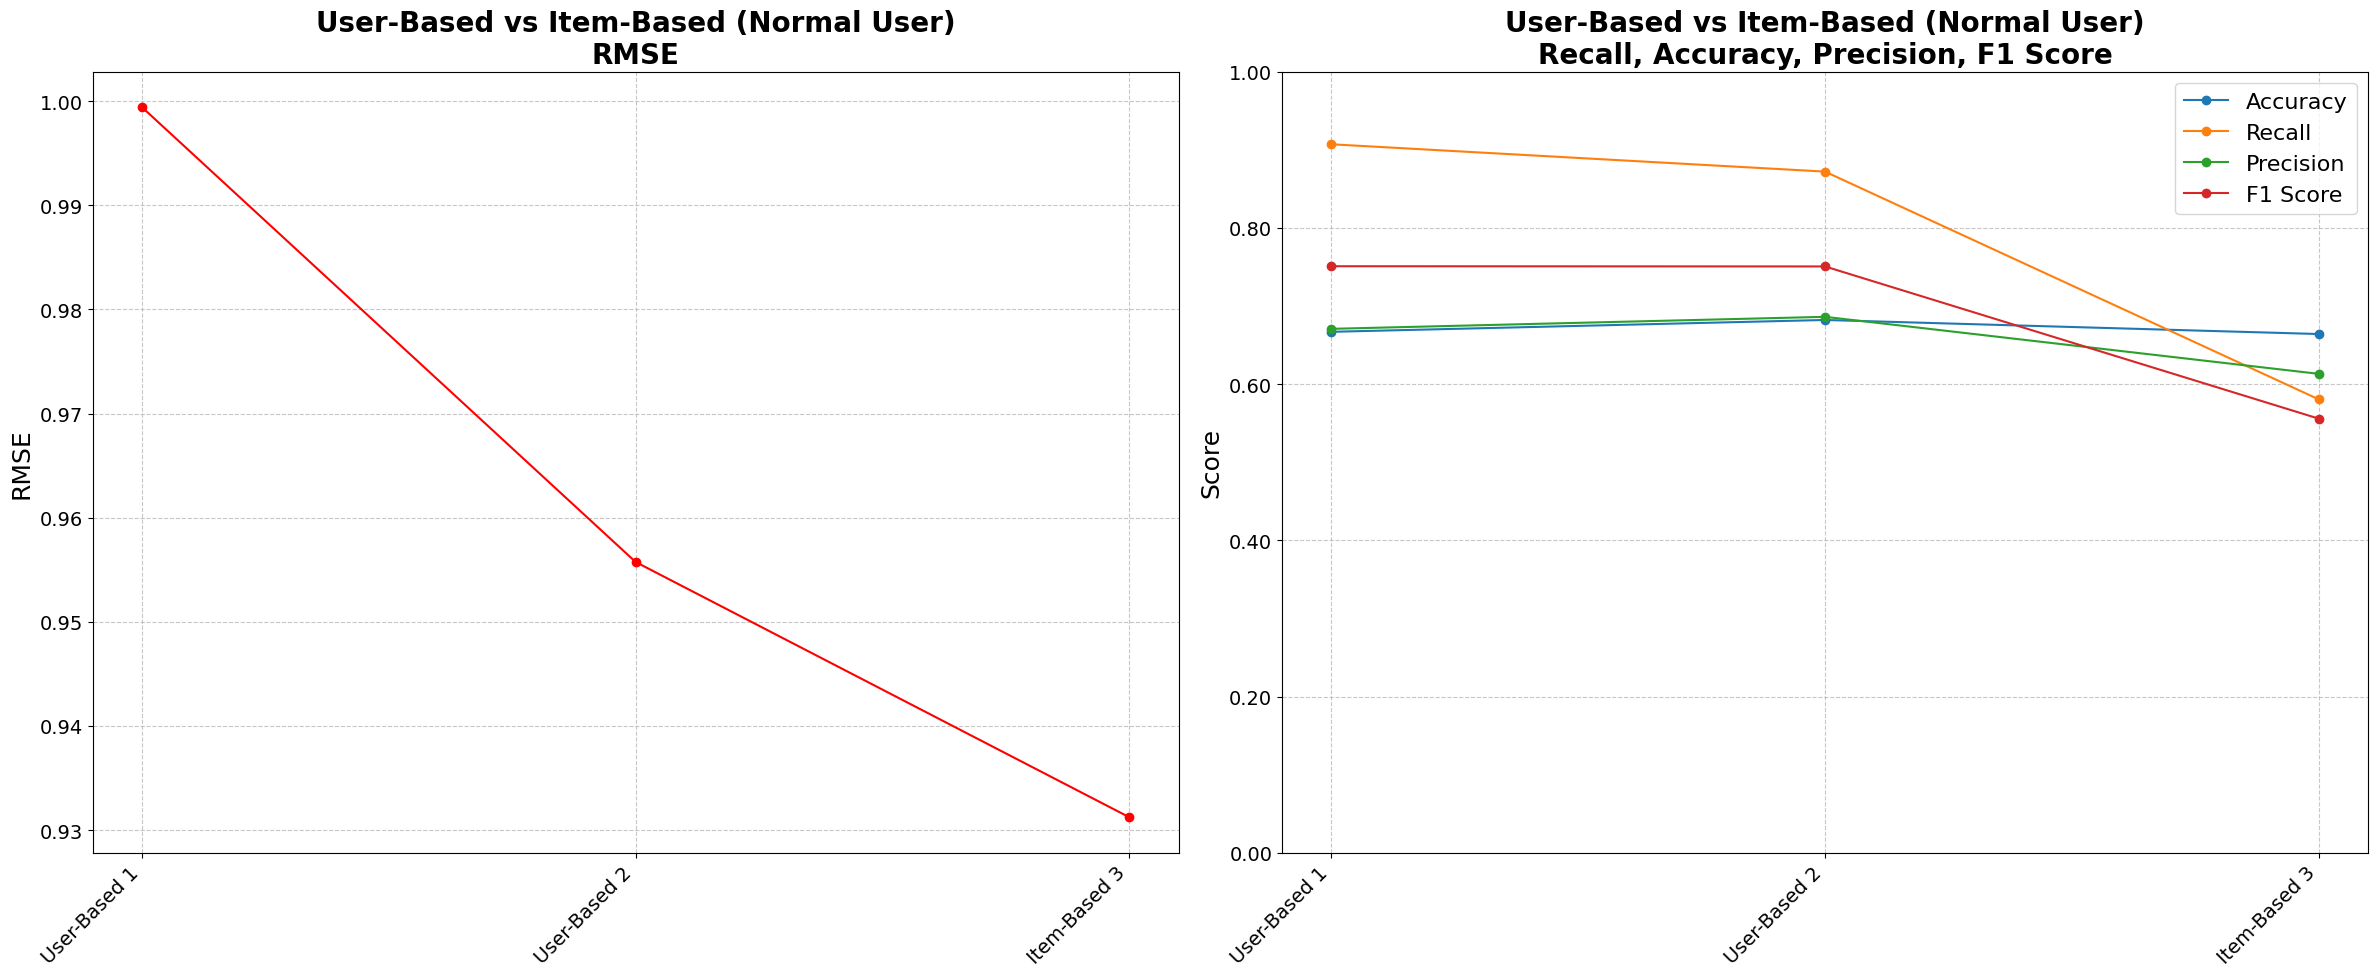

In [ ]:
models = ['User-Based 1', 'User-Based 2', 'Item-Based 3']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

cold_start_data = np.array([
    [accuracy_cold6_1, accuracy_cold6_1_2, accuracy_cold6_1_3],
    [recall_cold6_1, recall_cold6_1_2, recall_cold6_1_3],
    [precision_cold6_1, precision_cold6_1_2, precision_cold6_1_3],
    [f1_cold6_1, f1_cold6_1_2, f1_cold6_1_3]
])
cold_start_rmse = np.array([rmse_cold6_1, rmse_cold6_1_2, rmse_cold6_1_3])

partial_ratings_data = np.array([
    [accuracy_partial6_1, accuracy_partial6_1_2, accuracy_partial6_1_3],
    [recall_partial6_1, recall_partial6_1_2, recall_partial6_1_3],
    [precision_partial6_1, precision_partial6_1_2, precision_partial6_1_3],
    [f1_partial6_1, f1_partial6_1_2, f1_partial6_1_3]
])
partial_ratings_rmse = np.array([rmse_partial6_1, rmse_partial6_1_2, rmse_partial6_1_3])

# Plot for Cold Start User Rating Prediction
plot_metrics_and_rmse(cold_start_data, cold_start_rmse, 'User-Based vs Item-Based (Cold Start User)')

# Plot for Normal Case User Rating Prediction
plot_metrics_and_rmse(partial_ratings_data, partial_ratings_rmse, 'User-Based vs Item-Based (Normal User)')



# MF Comparion

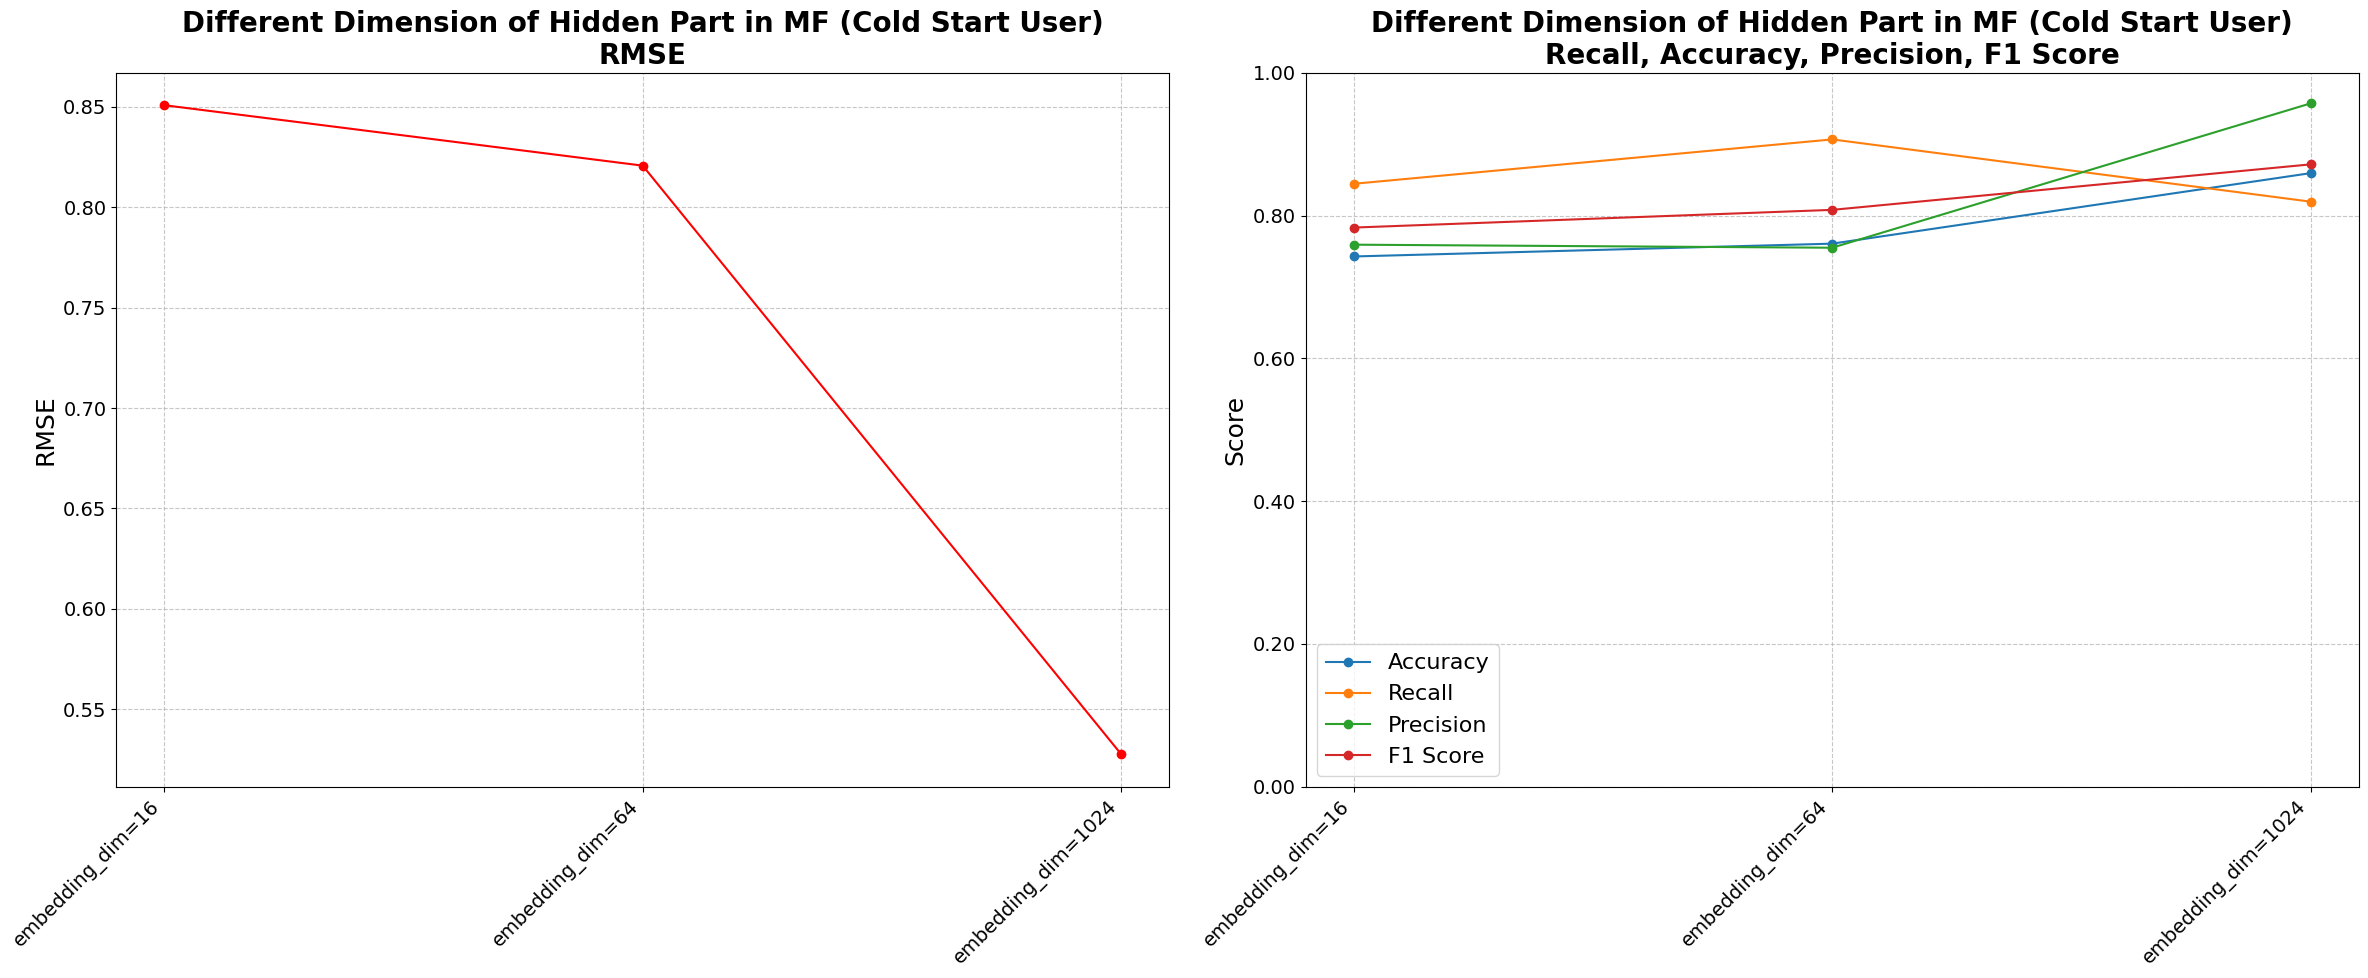

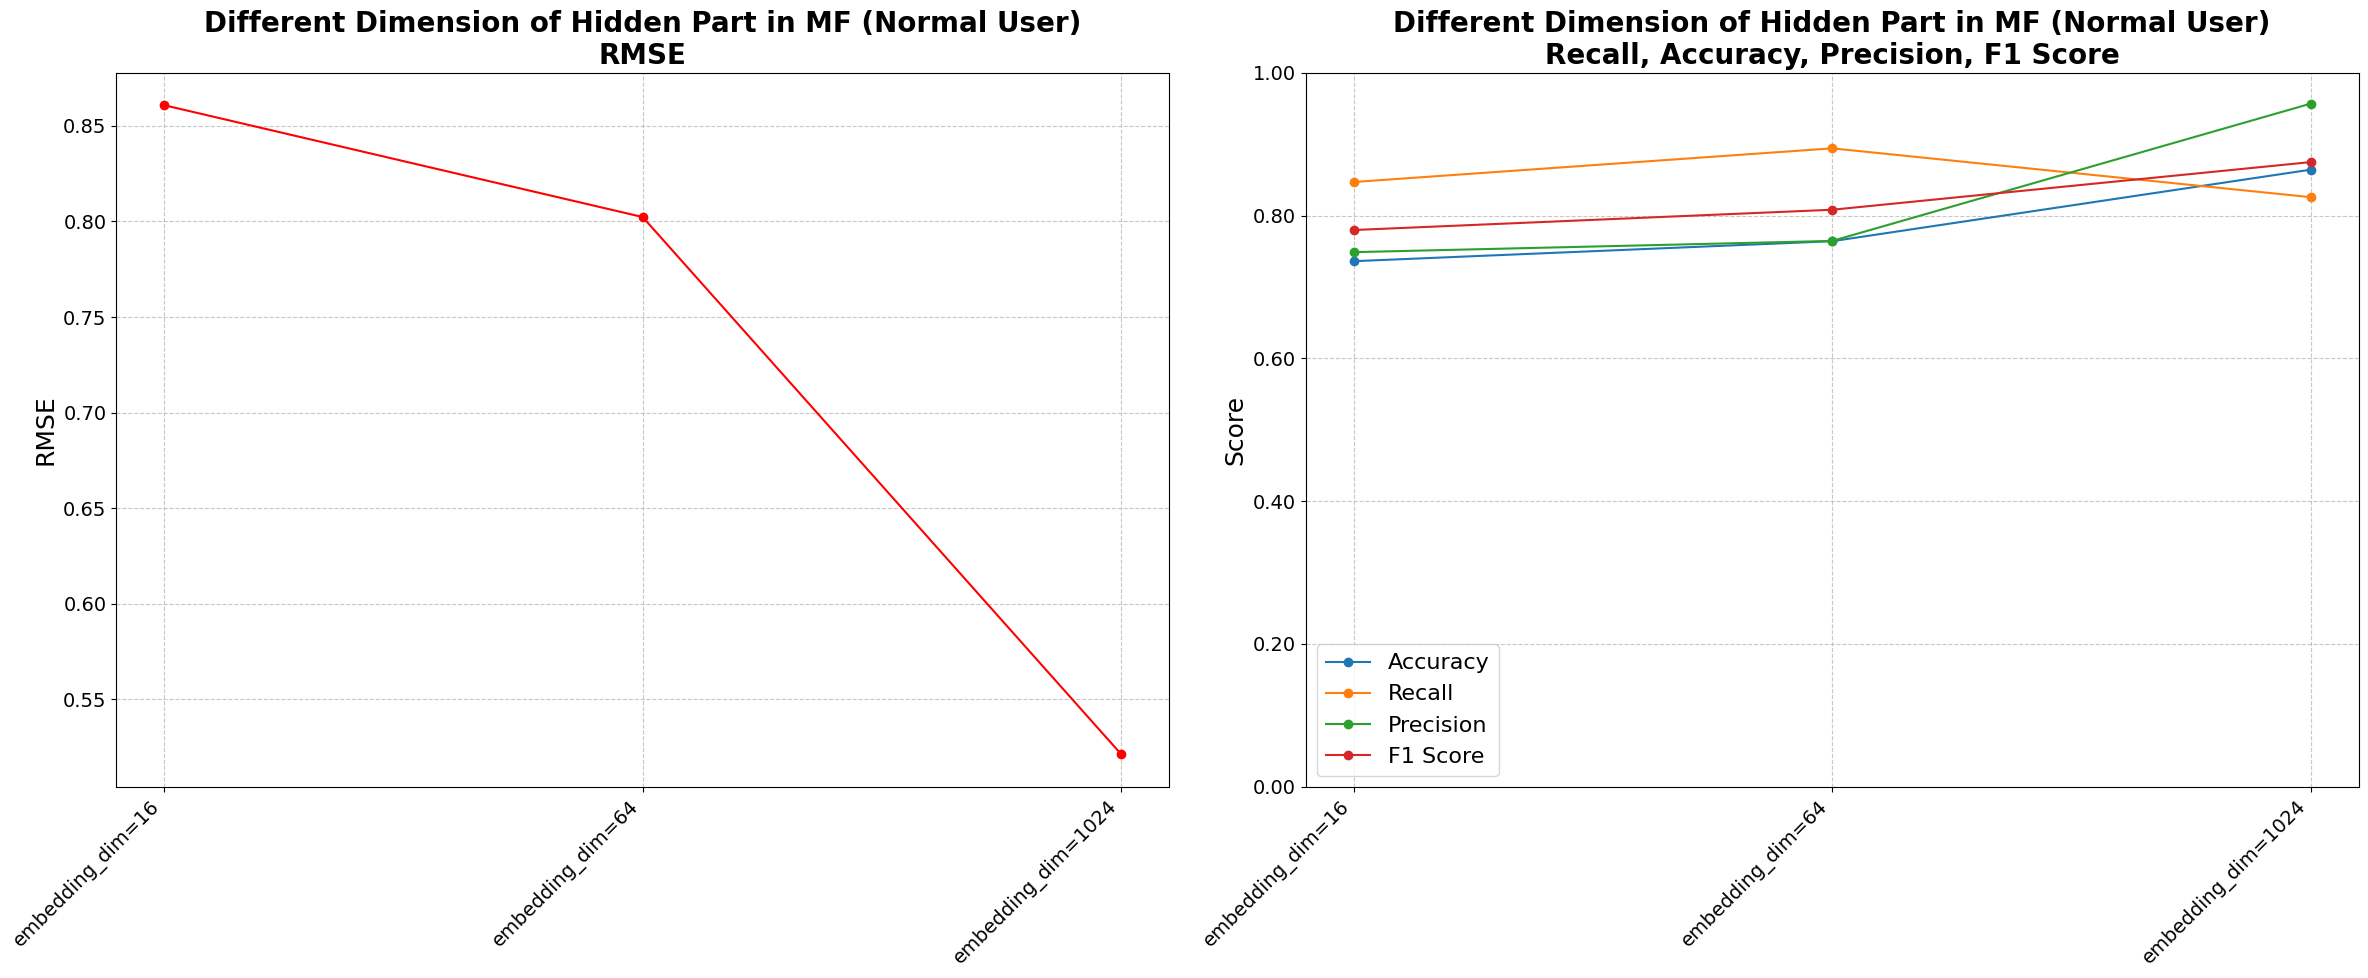

In [ ]:
models = ['embedding_dim=16', 'embedding_dim=64', 'embedding_dim=1024']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

cold_start_data = np.array([
    [accuracy_cold7_1_2, accuracy_cold7_1, accuracy_cold7_1_3],
    [recall_cold7_1_2, recall_cold7_1, recall_cold7_1_3],
    [precision_cold7_1_2, precision_cold7_1, precision_cold7_1_3],
    [f1_cold7_1_2, f1_cold7_1, f1_cold7_1_3]
])
cold_start_rmse = np.array([rmse_cold7_1_2, rmse_cold7_1, rmse_cold7_1_3])

partial_ratings_data = np.array([
    [accuracy_partial7_1_2, accuracy_partial7_1, accuracy_partial7_1_3],
    [recall_partial7_1_2, recall_partial7_1, recall_partial7_1_3],
    [precision_partial7_1_2, precision_partial7_1, precision_partial7_1_3],
    [f1_partial7_1_2, f1_partial7_1, f1_partial7_1_3]
])
partial_ratings_rmse = np.array([rmse_partial7_1_2, rmse_partial7_1, rmse_partial7_1_3])

# Plot for Cold Start User Rating Prediction
plot_metrics_and_rmse(cold_start_data, cold_start_rmse, 'Different Dimension of Hidden Part in MF (Cold Start User)')

# Plot for Normal Case User Rating Prediction
plot_metrics_and_rmse(partial_ratings_data, partial_ratings_rmse, 'Different Dimension of Hidden Part in MF (Normal User)')


In [ ]:
# # raise error the stop the code here
# raise ValueError("Stop the code here")

# Back up sections